In [43]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

from alrd.run_spot import SessionBuffer, DataBuffer, TransitionData, StateData, TimeData
from alrd.spot_gym.model.robot_state import SpotState
from alrd.utils.data_utils import project_angle

# load data
# file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240731-115035/session_buffer.pickle"
# file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240821-105835_action_delay/session_buffer.pickle"
# file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240821-110049_action_delay_ee/session_buffer.pickle"
file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240909-142029_v4_1/session_buffer.pickle"
# file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240906-171829_vonly_rotation/session_buffer.pickle"
# file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240906-171626_vonly_base_linear/session_buffer.pickle"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# get data structures
transitions = data.data_buffers[0].transitions
states = data.data_buffers[0].states


In [ ]:
# plot actions vs commands

# parse data
actions = [t.action for t in transitions if t.action is not None]
actions = np.array(actions)
commands = [t.cmd for t in transitions if t.cmd is not None]

# plot
fig, axs = plt.subplots(6, 1, figsize=(25, 30))
labels = ["vx", "vy", "vrot", "hand_vx", "hand_vy", "hand_vz", "hand_vrx", "hand_vry", "hand_vrz"]

# plot commands
axs[0].plot([c.vx for c in commands], label="command")
axs[1].plot([c.vy for c in commands], label="command")
axs[2].plot([c.vrz for c in commands], label="command")
axs[3].plot([c.ee_vx for c in commands], label="command")
axs[4].plot([c.ee_vy for c in commands], label="command")
axs[5].plot([c.ee_vz for c in commands], label="command")

# plot actions
for i in range(6):
    if i < 2:
        axs[i].plot(actions[:, i], label="action")
        axs[i].set_ylabel("velocity [m/s]")
    else:
        axs[i].plot(actions[:, i], label="action")
        axs[i].set_ylabel("angular velocity [rad/s]")
    axs[i].set_title(labels[i])
    axs[i].legend()




In [ ]:
# ee to body distance

# parse data
body_states = [s.next_state.pose_of_body_in_vision for s in states if s.next_state is not None]
hand_in_body = [s.next_state.pose_of_hand_in_body for s in states if s.next_state is not None]
hand_states = [s.next_state.pose_of_hand_in_vision for s in states if s.next_state is not None]
body_states = np.array(body_states)
hand_states = np.array(hand_states)
hand_in_body = np.array(hand_in_body)

body_z_const = 1.48
# body_states = np.concatenate([body_states[:, :2], np.ones((len(body_states), 1)) * body_z_const], axis=1)


distance = np.linalg.norm(hand_states[:, :3] - body_states[:, :3], axis=1)
distance_test = np.linalg.norm(hand_in_body[:, :3], axis=1)
# max distance
print("max distance", np.max(distance))

# plot
fig, axs = plt.subplots(1, 1, )
axs.plot(distance, label="distance")
axs.plot(distance_test, label="distance test")
axs.set_ylabel("distance [m]")
axs.legend()

plt.show()


In [ ]:
# plot states
FRAME = "vision"

# parse data
if FRAME == "vision":
    base_states = [s.next_state.pose_of_body_in_vision for s in states if s.next_state.pose_of_body_in_vision is not None]
    ee_states = [s.next_state.pose_of_hand_in_vision for s in states if s.next_state.pose_of_hand_in_vision is not None]
    base_velocity = [s.next_state.velocity_of_body_in_vision for s in states if s.next_state.velocity_of_body_in_vision is not None]
    ee_velocity = [s.next_state.velocity_of_hand_in_vision for s in states if s.next_state.velocity_of_hand_in_vision is not None]
elif FRAME == "odom":
    base_states = [s.next_state.pose_of_body_in_odom for s in states if s.next_state.pose_of_body_in_odom is not None]
    ee_states = [s.next_state.pose_of_hand_in_odom for s in states if s.next_state.pose_of_hand_in_odom is not None]
    base_velocity = [s.next_state.velocity_of_body_in_odom for s in states if s.next_state.velocity_of_body_in_odom is not None]
    ee_velocity = [s.next_state.velocity_of_hand_in_odom for s in states if s.next_state.velocity_of_hand_in_odom is not None]
base_states = np.array(base_states)
ee_states = np.array(ee_states)
base_velocity = np.array(base_velocity)
ee_velocity = np.array(ee_velocity)

# convert quaternions to euler angles
def quat_to_euler(qx, qy, qz, qw):
    euler_angles = R.from_quat([qx, qy, qz, qw]).as_euler("xyz", degrees=False)
    euler_angles = np.array([project_angle(a) for a in euler_angles])
    return euler_angles

base_states_euler = np.array([quat_to_euler(qx, qy, qz, qw) for qx, qy, qz, qw in base_states[:, 3:]])
ee_states_euler = np.array([quat_to_euler(qx, qy, qz, qw) for qx, qy, qz, qw in ee_states[:, 3:]])

base_states_full = np.concatenate([base_states[:, :3], base_states_euler], axis=1)
ee_states_full = np.concatenate([ee_states[:, :3], ee_states_euler], axis=1)

# get transformed data from /home/bhoffman/Documents/MT FS24/active-learning-dynamics/data_analysis/learning_data/dataset_learn_jax_test20240909-142029_v4_1.pickle to check if it is correct

# load data
file_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/data_analysis/learning_data/dataset_learn_jax_test20240909-142029_v4_1.pickle"
with open(file_path, 'rb') as file:
    prev_state, u, next_state = pickle.load(file)

# convert to np
prev_state = np.array(prev_state)
u = np.array(u)
next_state = np.array(next_state)

# plot
base_lables = ["base_x", "base_y", "base_z", "yaw", "base_vx", "base_vy", "base_vz"]
ee_lables = ["ee_x", "ee_y", "ee_z", "ee_vx", "ee_vy", "ee_vz"]

# print initial state
init_state_str = ""
init_state_str += f"{base_lables[0]}: {base_states_full[0, 0]}\n"
init_state_str += f"{base_lables[1]}: {base_states_full[0, 1]}\n"
init_state_str += f"{base_lables[2]}: {base_states_full[0, 2]}\n"
init_state_str += f"{base_lables[3]}: {base_states_full[0, 5]}\n"
init_state_str += f"{base_lables[4]}: {base_velocity[0, 0]}\n"
init_state_str += f"{base_lables[5]}: {base_velocity[0, 1]}\n"
init_state_str += f"{base_lables[6]}: {base_velocity[0, 2]}\n"
init_state_str += f"{ee_lables[0]}: {ee_states_full[0, 0]}\n"
init_state_str += f"{ee_lables[1]}: {ee_states_full[0, 1]}\n"
init_state_str += f"{ee_lables[2]}: {ee_states_full[0, 2]}\n"
init_state_str += f"{ee_lables[3]}: {ee_velocity[0, 0]}\n"
init_state_str += f"{ee_lables[4]}: {ee_velocity[0, 1]}\n"
init_state_str += f"{ee_lables[5]}: {ee_velocity[0, 2]}\n"
print(init_state_str)

fig, axs = plt.subplots(7, 2, figsize=(25, 30))
axs[0, 0].plot(base_states_full[:, 0], label=base_lables[0])
axs[1, 0].plot(base_states_full[:, 1], label=base_lables[1])
axs[2, 0].plot(base_states_full[:, 2], label=base_lables[2])
axs[3, 0].plot(base_states_full[:, 5], label=base_lables[3])
axs[4, 0].plot(base_velocity[:, 0], label=base_lables[4])
axs[5, 0].plot(base_velocity[:, 1], label=base_lables[5])
axs[6, 0].plot(base_velocity[:, 2], label=base_lables[6])

axs[0, 1].plot(ee_states_full[:, 0], label=ee_lables[0])
axs[1, 1].plot(ee_states_full[:, 1], label=ee_lables[1])
axs[2, 1].plot(ee_states_full[:, 2], label=ee_lables[2])
axs[3, 1].plot(ee_velocity[:, 0], label=ee_lables[3])
axs[4, 1].plot(ee_velocity[:, 1], label=ee_lables[4])
axs[5, 1].plot(ee_velocity[:, 2], label=ee_lables[5])

# plot converted data
axs[0, 0].plot(next_state[:, 0], label=base_lables[0])
axs[1, 0].plot(next_state[:, 1], label=base_lables[1])
axs[3, 0].plot(next_state[:, 2], label=base_lables[3])
axs[4, 0].plot(next_state[:, 3], label=base_lables[4])
axs[5, 0].plot(next_state[:, 4], label=base_lables[5])

axs[0, 1].plot(next_state[:, 6], label=ee_lables[0])
axs[1, 1].plot(next_state[:, 7], label=ee_lables[1])
axs[2, 1].plot(next_state[:, 8], label=ee_lables[2])
axs[3, 1].plot(next_state[:, 9], label=ee_lables[3])
axs[4, 1].plot(next_state[:, 10], label=ee_lables[4])
axs[5, 1].plot(next_state[:, 11], label=ee_lables[5])



for i in range(7):
    if i < len(base_lables):
        axs[i, 0].set_title(base_lables[i])
        axs[i, 0].legend()
    if i < len(ee_lables):
        axs[i, 1].set_title(ee_lables[i])
        axs[i, 1].legend()

In [ ]:
# plot delta_t of states

# parse data
delta_ts = [s.delta_t for s in states]
delta_ts = np.array(delta_ts)

# plot
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(1/-delta_ts, label="cmd_freq")
# plot line at 0.1=1/cmd_freq where cmd_freq=10Hz
axs.axhline(y=10, color='r', linestyle='--')
axs.set_ylabel("frequency [Hz]")
plt.legend()


In [ ]:
# plot time data

# parse data
time_data = data.data_buffers[0].times
agent_time = np.array([t.agent_time for t in time_data])
step_time = np.array([t.step_time for t in time_data])
save_time = np.array([t.save_time for t in time_data])
cmd_time = np.array([t.cmd_time for t in time_data])
inner_step_time = np.array([t.inner_step_time for t in time_data])
additional_time = np.array([t.additional_time for t in time_data])

# plot
fig = plt.figure(figsize=(10, 5))
plt.plot(agent_time, label="agent_time")
# plt.plot(step_time, label="step_time")
plt.plot(save_time, label="save_time")
plt.plot(cmd_time, label="cmd_time")
plt.plot(inner_step_time, label="inner_step_time")
plt.plot(additional_time, label="additional_time")
plt.legend()

plt.show()



In [ ]:
# test command tracking for arm joint commands

# get arm joint commands
arm_joint_commands = [transition.cmd.commanded_arm_joint_positions for transition in transitions]
command_steps = [transition.step for transition in transitions]

# get arm joint states
arm_joint_states = [state.last_state.arm_joint_positions for state in states]
state_steps = [state.step for state in states]

# cut off at 150
arm_joint_commands = arm_joint_commands[:150]
command_steps = command_steps[:150]
arm_joint_states = arm_joint_states[:150]
state_steps = state_steps[:150]


# plot seperately in subplot for each joint (sh0, sh1, el0, el1, wr0, wr1)
fig, axs = plt.subplots(6, 1, figsize=(25, 20))
joint_names = ["sh0", "sh1", "el0", "el1", "wr0", "wr1"]
for i in range(6):
    axs[i].plot(command_steps, [np.rad2deg(command[i]) for command in arm_joint_commands], label="command")
    axs[i].plot(state_steps, [np.rad2deg(state[i]) for state in arm_joint_states], label="state")
    axs[i].set_title(joint_names[i])
    axs[i].legend()
    # set x and y labels
    if i == 5:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("angle [deg]")

plt.show()

In [ ]:
# test command tracking for velocity commands to determine action delay

# load data
body_commands = [[transition.cmd.vx, transition.cmd.vy, transition.cmd.vrz] for transition in transitions if transition.cmd is not None]
ee_commands = [[transition.cmd.ee_vx, transition.cmd.ee_vy, transition.cmd.ee_vz] for transition in transitions if transition.cmd is not None]
body_velocity_states = [[state.last_state.velocity_of_body_in_vision[0], state.last_state.velocity_of_body_in_vision[1], state.last_state.velocity_of_body_in_vision[5]] for state in states if state.last_state is not None]
ee_velocity_states = [[state.last_state.velocity_of_hand_in_vision[0], state.last_state.velocity_of_hand_in_vision[1], state.last_state.velocity_of_hand_in_vision[2]] for state in states if state.last_state is not None]

body_position_states = [[state.last_state.pose_of_body_in_vision[0], state.last_state.pose_of_body_in_vision[1], state.last_state.pose_of_body_in_vision[2]] for state in states if state.last_state is not None]
ee_position_states = [[state.last_state.pose_of_hand_in_vision[0], state.last_state.pose_of_hand_in_vision[1], state.last_state.pose_of_hand_in_vision[2]] for state in states if state.last_state is not None]

idx_lower_lim = 140 + 35
idx_upper_lim = 180 + 45
body_commands, body_velocity_states = body_commands[idx_lower_lim:idx_upper_lim], body_velocity_states[idx_lower_lim:idx_upper_lim]
ee_commands, ee_velocity_states = ee_commands[idx_lower_lim:idx_upper_lim], ee_velocity_states[idx_lower_lim:idx_upper_lim]
body_position_states, ee_position_states = body_position_states[idx_lower_lim:idx_upper_lim], ee_position_states[idx_lower_lim:idx_upper_lim]

# action delay
action_delay_base = 2
action_delay_ee = 1
# shift commands forward by action delay using zeros in beginning using concat
body_commands_delayed = np.concatenate((np.zeros((action_delay_base, 3)), body_commands))
ee_commands_delay = np.concatenate((np.zeros((action_delay_ee, 3)), ee_commands))


# plot for velocities
fig, axs = plt.subplots(6, 1, figsize=(10, 30))
body_names = ["vx", "vy", "vrz"]
ee_names = ["ee_vx", "ee_vy", "ee_vz"]
for i in range(3):
    axs[i].plot([command[i] for command in body_commands], label="commanded velocity", color="lightblue")
    axs[i].plot([command[i] for command in body_commands_delayed], label="commanded velocity delayed", color="blue")
    axs[i].plot([state[i] for state in body_velocity_states], label="measured velocity", color="orange")
    axs[i].set_title(body_names[i])
    axs[i].legend()
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("velocity [m/s]")
    axs[i].set_xticks(np.arange(0,idx_upper_lim-idx_lower_lim,1.0))
    
    axs[i+3].plot([command[i] for command in ee_commands], label="commanded velocity", color="lightblue")
    axs[i+3].plot([command[i] for command in ee_commands_delay], label="commanded velocity delayed", color="blue")
    axs[i+3].plot([state[i] for state in ee_velocity_states], label="measured velocity", color="orange")
    axs[i+3].set_title(ee_names[i])
    axs[i+3].legend()
    if i == 2:
        axs[i+3].set_xlabel("step")
    axs[i+3].set_ylabel("velocity [m/s]")
    axs[i+3].set_xticks(np.arange(0,idx_upper_lim-idx_lower_lim,1.0))

plt.show()

# plot for positions
fig, axs = plt.subplots(6, 1, figsize=(10, 30))
body_names = ["body_x", "body_y", "body_z"]
ee_names = ["ee_x", "ee_y", "ee_z"]
for i in range(3):
    axs[i].plot([command[i] for command in body_commands], label="commanded position", color="lightblue")
    axs[i].plot([command[i] for command in body_commands_delayed], label="commanded velocity delayed", color="blue")
    axs[i].plot([state[i] for state in body_position_states], label="measured position", color="orange")
    axs[i].set_title(body_names[i])
    axs[i].legend()
    if i == 2:
        axs[i].set_xlabel("step")
    axs[i].set_ylabel("position [m]")
    axs[i].set_xticks(np.arange(0,idx_upper_lim-idx_lower_lim,1.0))

    axs[i+3].plot([command[i] for command in ee_commands], label="commanded position", color="lightblue")
    axs[i+3].plot([command[i] for command in ee_commands_delay], label="commanded velocity delayed", color="blue")
    axs[i+3].plot([state[i] for state in ee_position_states], label="measured position", color="orange")
    axs[i+3].set_title(ee_names[i])
    axs[i+3].legend()
    if i == 2:
        axs[i+3].set_xlabel("step")
    axs[i+3].set_ylabel("position [m]")
    axs[i+3].set_xticks(np.arange(0,idx_upper_lim-idx_lower_lim,1.0))


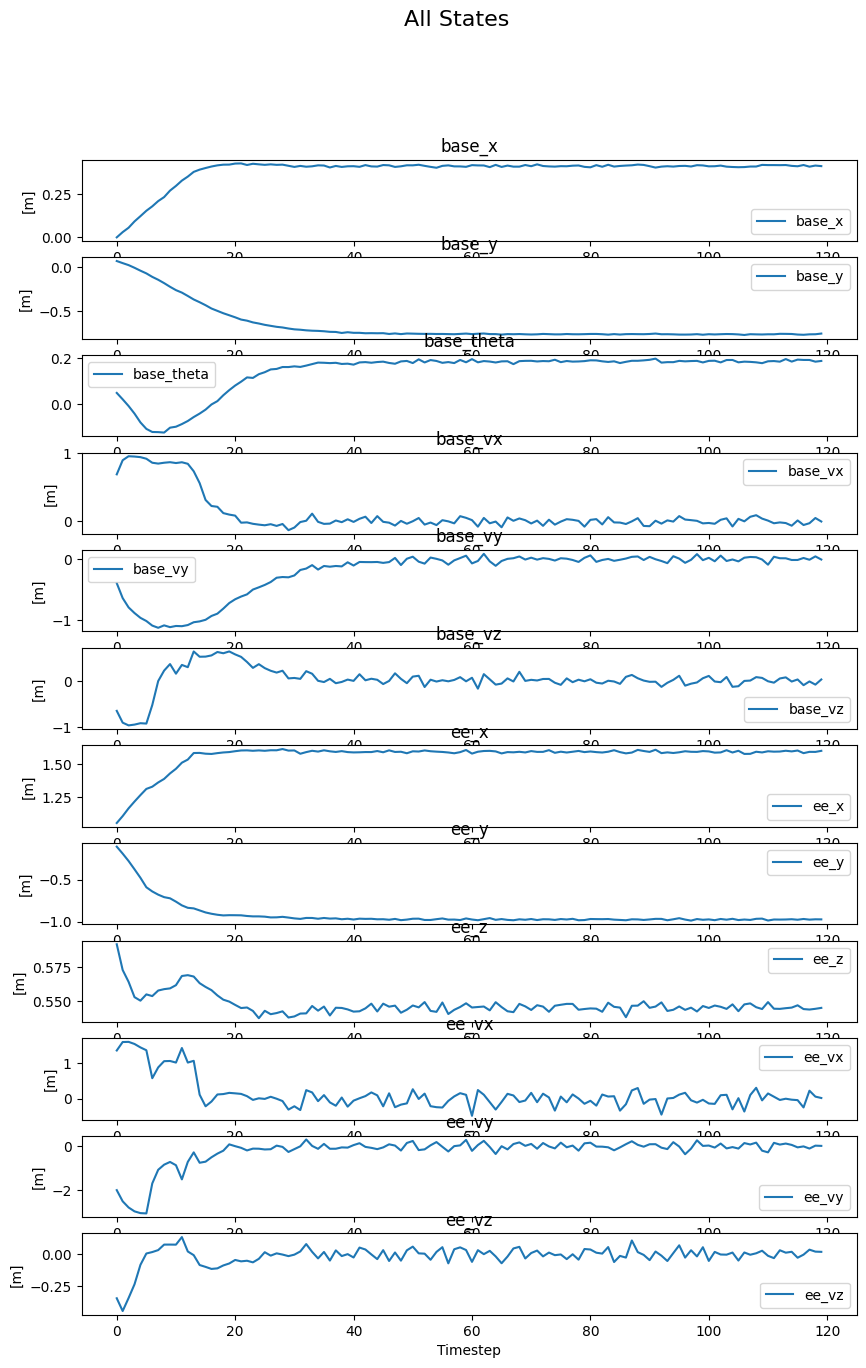

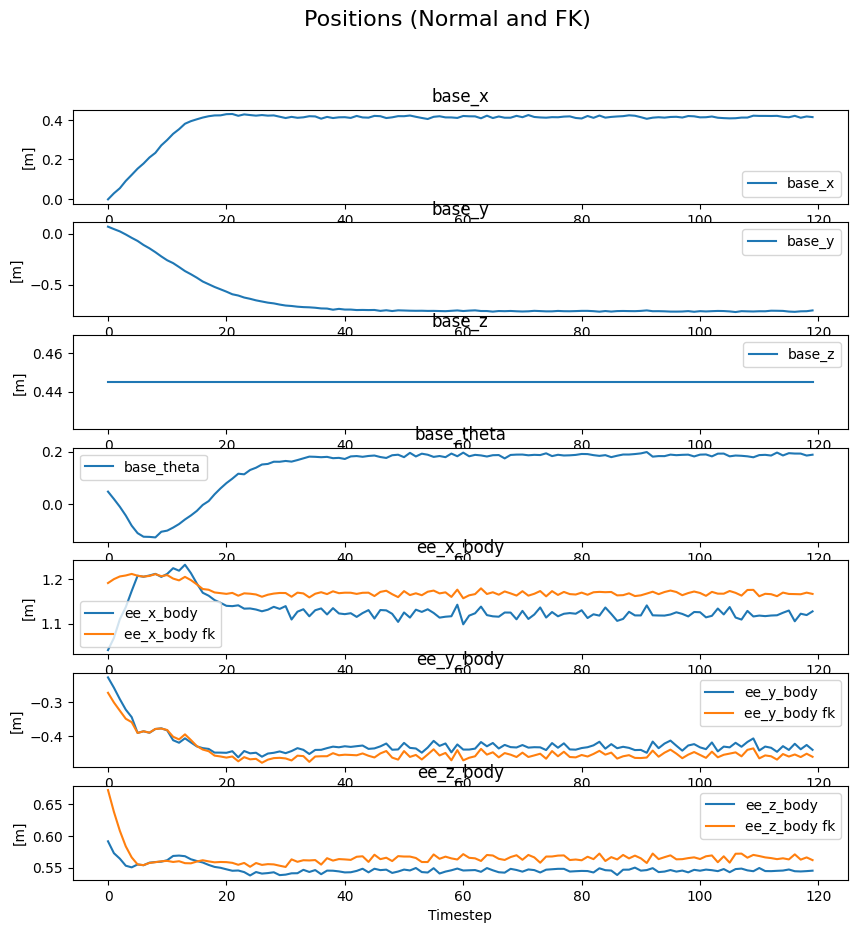

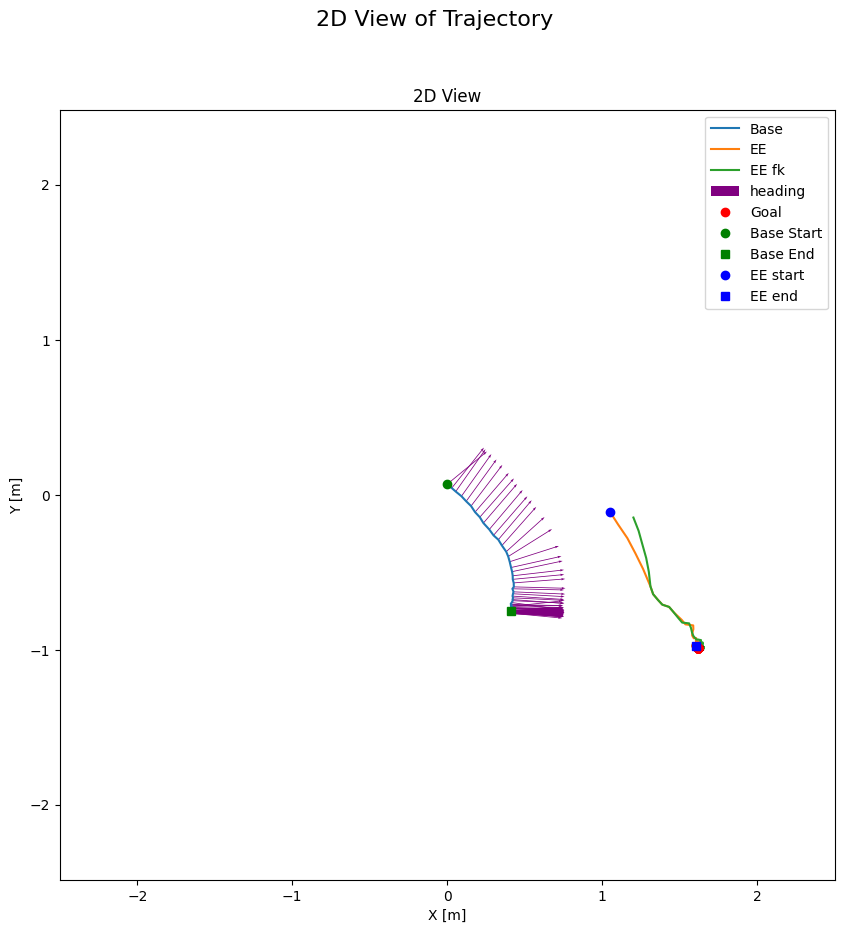

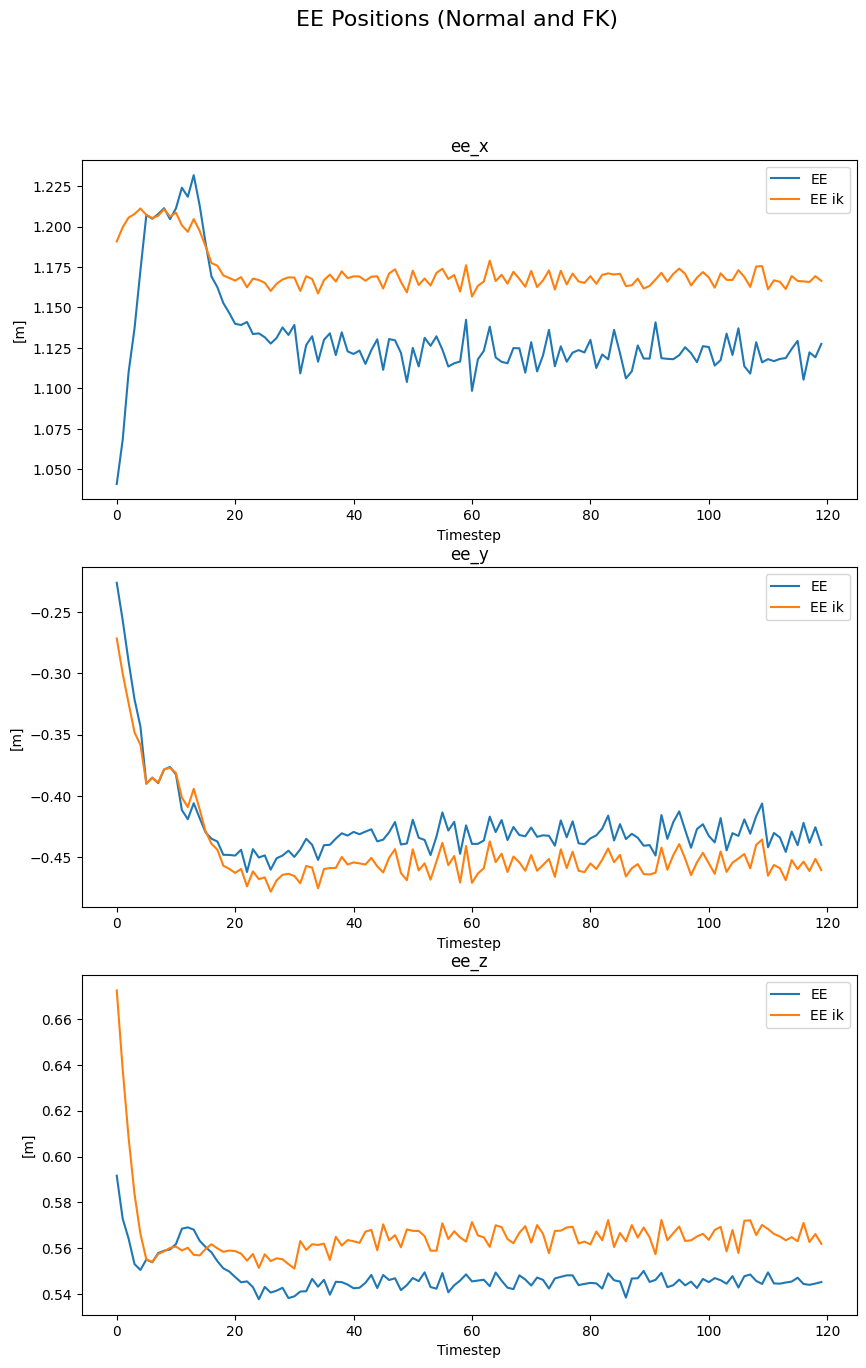

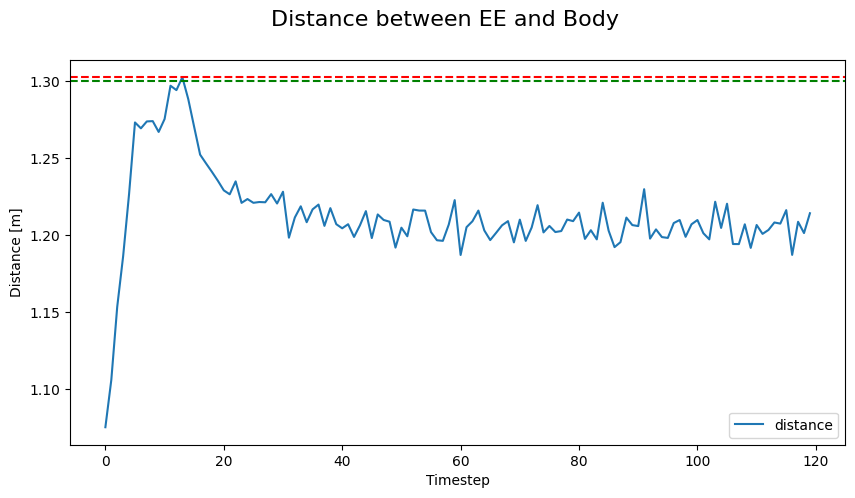

In [8]:
import ikpy.chain
import pickle
import numpy as np
import matplotlib.pyplot as plt
import ikpy.utils.plot as plot_utils

# Load trajectory from policy simulation
file_path = "/home/bhoffman/Documents/MT_FS24/simulation_transfer/results/policies_traj/trajectories_all.pkl"
with open(file_path, 'rb') as file:
    data_all = pickle.load(file)

# Pick trajectory
data = data_all[50]

# Transform ee positions from world to body frame
def world_to_body_frame(base_pos, theta, ee_pos):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ee_x_local = cos_theta * (ee_pos[0] - base_pos[0]) + sin_theta * (ee_pos[1] - base_pos[1])
    ee_y_local = -sin_theta * (ee_pos[0] - base_pos[0]) + cos_theta * (ee_pos[1] - base_pos[1])
    ee_z_local = ee_pos[2]
    ee_body = [ee_x_local, ee_y_local, ee_z_local]
    return ee_body

# Transform ee positions from body to world frame
def body_to_world_frame(base_pos, theta, ee_pos):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ee_x_world = cos_theta * ee_pos[0] - sin_theta * ee_pos[1] + base_pos[0]
    ee_y_world = sin_theta * ee_pos[0] + cos_theta * ee_pos[1] + base_pos[1]
    ee_z_world = ee_pos[2]
    ee_world = [ee_x_world, ee_y_world, ee_z_world]
    return ee_world

# Get base and ee positions
base_positions = np.concatenate([data[:, 0:2], 0.445*np.ones((len(data), 1))], axis=1)
base_theta = data[:, 2]
ee_positions_world = data[:, 6:9]
ee_positions_body = np.array([world_to_body_frame(base_positions[i], base_theta[i], ee_positions_world[i]) for i in range(len(data))])
data_ee_transformed = np.concatenate([base_positions, base_theta.reshape(-1, 1), ee_positions_body], axis=1)

# Build inverse kinematics chain
ik_chain = ikpy.chain.Chain.from_urdf_file(
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/alrd/spot_gym/utils/spot_urdf_model/spot_with_arm.urdf",
    base_elements=["base"],
    last_link_vector=[0.19557, 0, 0],
    active_links_mask=[
        True,
        True,
        True,
        True,
        True,
        False,
        False,
        False,
        False,
    ],
)

# Get joints and fk positions
ik_arm_joint_positions = [ik_chain.inverse_kinematics(ee_position_body) for ee_position_body in ee_positions_body]
ee_fk_positions_body = np.array([ik_chain.forward_kinematics(arm_joint_position)[:3, 3] for arm_joint_position in ik_arm_joint_positions])
ee_fk_positions_world = np.array([body_to_world_frame(base_positions[i], base_theta[i], ee_fk_positions_body[i]) for i in range(len(data))])

# Define labels
labels_state = ["base_x", "base_y", "base_theta", "base_vx", "base_vy", "base_vz", "ee_x", "ee_y", "ee_z", "ee_vx", "ee_vy", "ee_vz"]
labels_pos = ["base_x", "base_y", "base_z", "base_theta", "ee_x_body", "ee_y_body", "ee_z_body"]

# Plot all states
fig, axs = plt.subplots(12, 1, figsize=(10, 15))
for i in range(12):
    axs[i].plot(data[:, i], label=f"{labels_state[i]}")
    axs[i].set_title(labels_state[i])
    axs[i].legend()
    axs[i].set_xlabel("Timestep")
    if 'x' in labels_state[i] or 'y' in labels_state[i] or 'z' in labels_state[i]:
        axs[i].set_ylabel("[m]")
fig.suptitle("All States", fontsize=16)
plt.show()

# Plot individual positions
fig, axs = plt.subplots(7, 1, figsize=(10, 10))
for i in range(7):
    axs[i].plot(data_ee_transformed[:, i], label=f"{labels_pos[i]}")
    if i > 3:
        axs[i].plot(ee_fk_positions_body[:, i-4], label=f"{labels_pos[i]} fk")
    axs[i].set_title(labels_pos[i])
    axs[i].legend()
    axs[i].set_xlabel("Timestep")
    if 'x' in labels_pos[i] or 'y' in labels_pos[i] or 'z' in labels_pos[i]:
        axs[i].set_ylabel("[m]")
fig.suptitle("Positions (Normal and FK)", fontsize=16)
plt.show()

# Plot 2D view
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
u = np.cos(data[:, 3])
v = np.sin(data[:, 3])
axs.plot(data[:, 0], data[:, 1], label="Base")
axs.plot(data[:, 6], data[:, 7], label="EE")
axs.plot(ee_fk_positions_world[:, 0], ee_fk_positions_world[:, 1], label="EE fk")
axs.quiver(data[:, 0], data[:, 1], u, v, angles='xy', scale_units='xy', scale=3, width=0.001, color='purple', label='heading')
axs.plot(data[:, -3], data[:, -2], 'ro', label="Goal")
axs.plot(data[0, 0], data[0, 1], 'go', label="Base Start")
axs.plot(data[-1, 0], data[-1, 1], 'gs', label="Base End")
axs.plot(data[0, 6], data[0, 7], 'bo', label="EE start")
axs.plot(data[-1, 6], data[-1, 7], 'bs', label="EE end")
axs.set_title("2D View")
axs.legend()
axs.set_xlabel("X [m]")
axs.set_ylabel("Y [m]")
axs.axis('equal')
axs.set_xlim(-2.5, 2.5)
axs.set_ylim(-4.5, 4.5)
fig.suptitle("2D View of Trajectory", fontsize=16)
plt.show()

# Plot the fk and normal ee positions
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
ee_names = ["ee_x", "ee_y", "ee_z"]
for i in range(3):
    axs[i].plot(data_ee_transformed[:, 4+i], label="EE")
    axs[i].plot(ee_fk_positions_body[:, i], label="EE ik")
    axs[i].set_title(ee_names[i])
    axs[i].legend()
    axs[i].set_xlabel("Timestep")
    axs[i].set_ylabel("[m]")
fig.suptitle("EE Positions (Normal and FK)", fontsize=16)
plt.show()

# Plot distance between ee and body
distance = np.linalg.norm(ee_positions_world - base_positions, axis=1)
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(distance, label="distance")
axs.axhline(y=np.max(distance), color='r', linestyle='--')
axs.axhline(y=1.3, color='g', linestyle='--')
axs.set_xlabel("Timestep")
axs.set_ylabel("Distance [m]")
axs.legend()
fig.suptitle("Distance between EE and Body", fontsize=16)
plt.show()


Trajectory 1


/tmp/ipykernel_2571595/2886852584.py:28: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(data[0, 0], data[0, 1], 'go', marker='o', label="Base Start")
/tmp/ipykernel_2571595/2886852584.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "gs" (-> marker='s'). The keyword argument will take precedence.
  ax1.plot(data[-1, 0], data[-1, 1], 'gs', marker='s', label="Base End")
/tmp/ipykernel_2571595/2886852584.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(data[0, 6], data[0, 7], 'bo', marker='o', label="EE Start")
/tmp/ipykernel_2571595/2886852584.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bs" (-> marker='s'). The keyword argument w

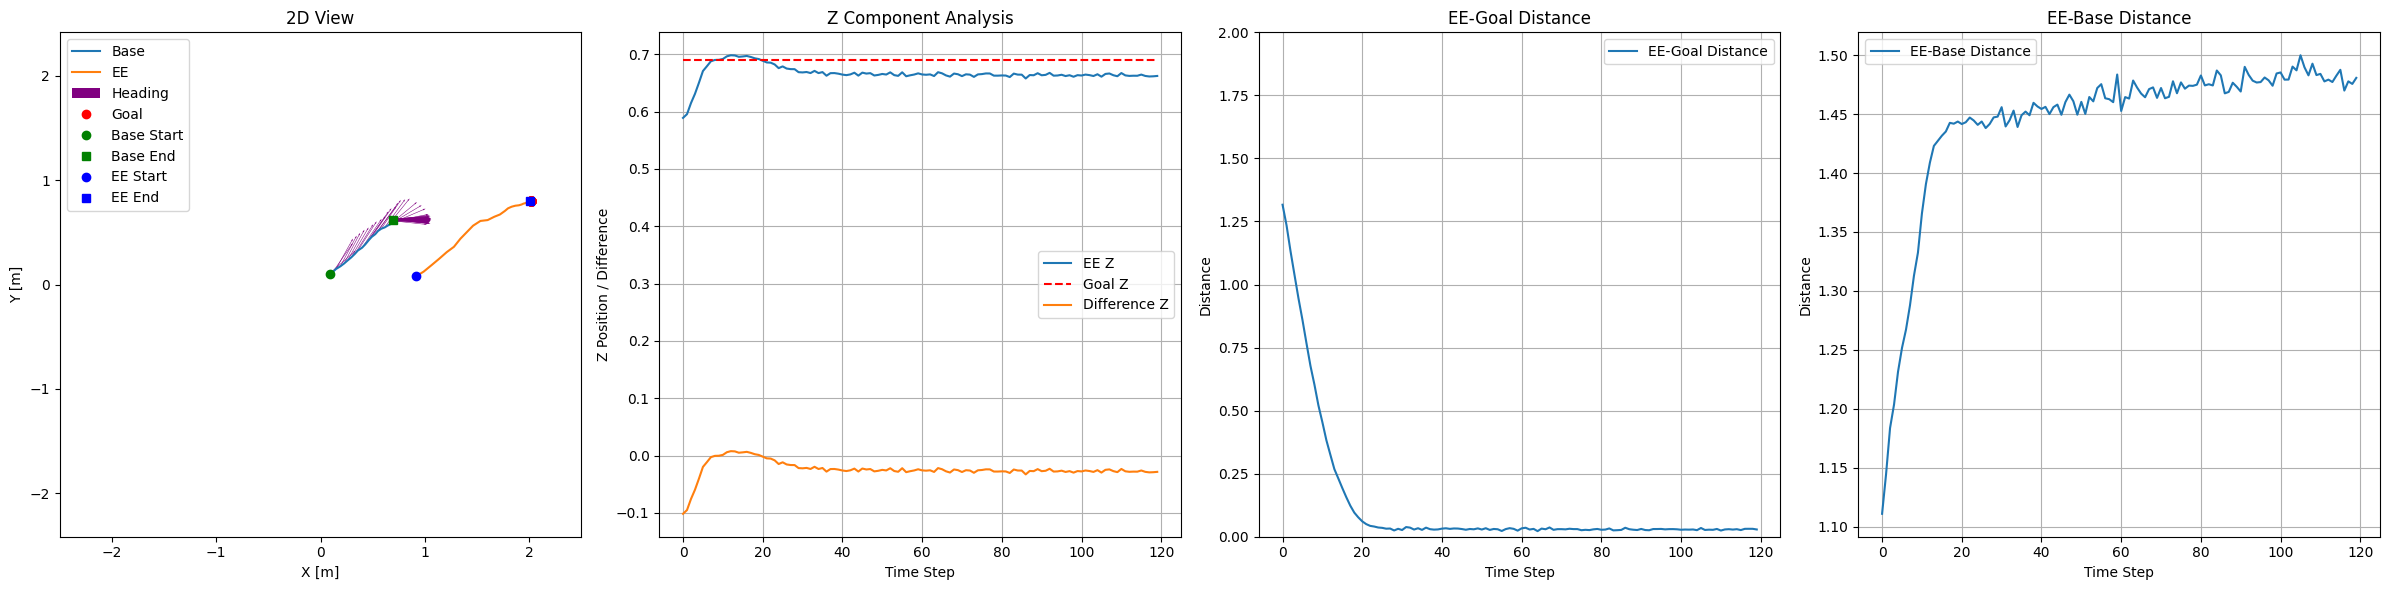

Trajectory 2


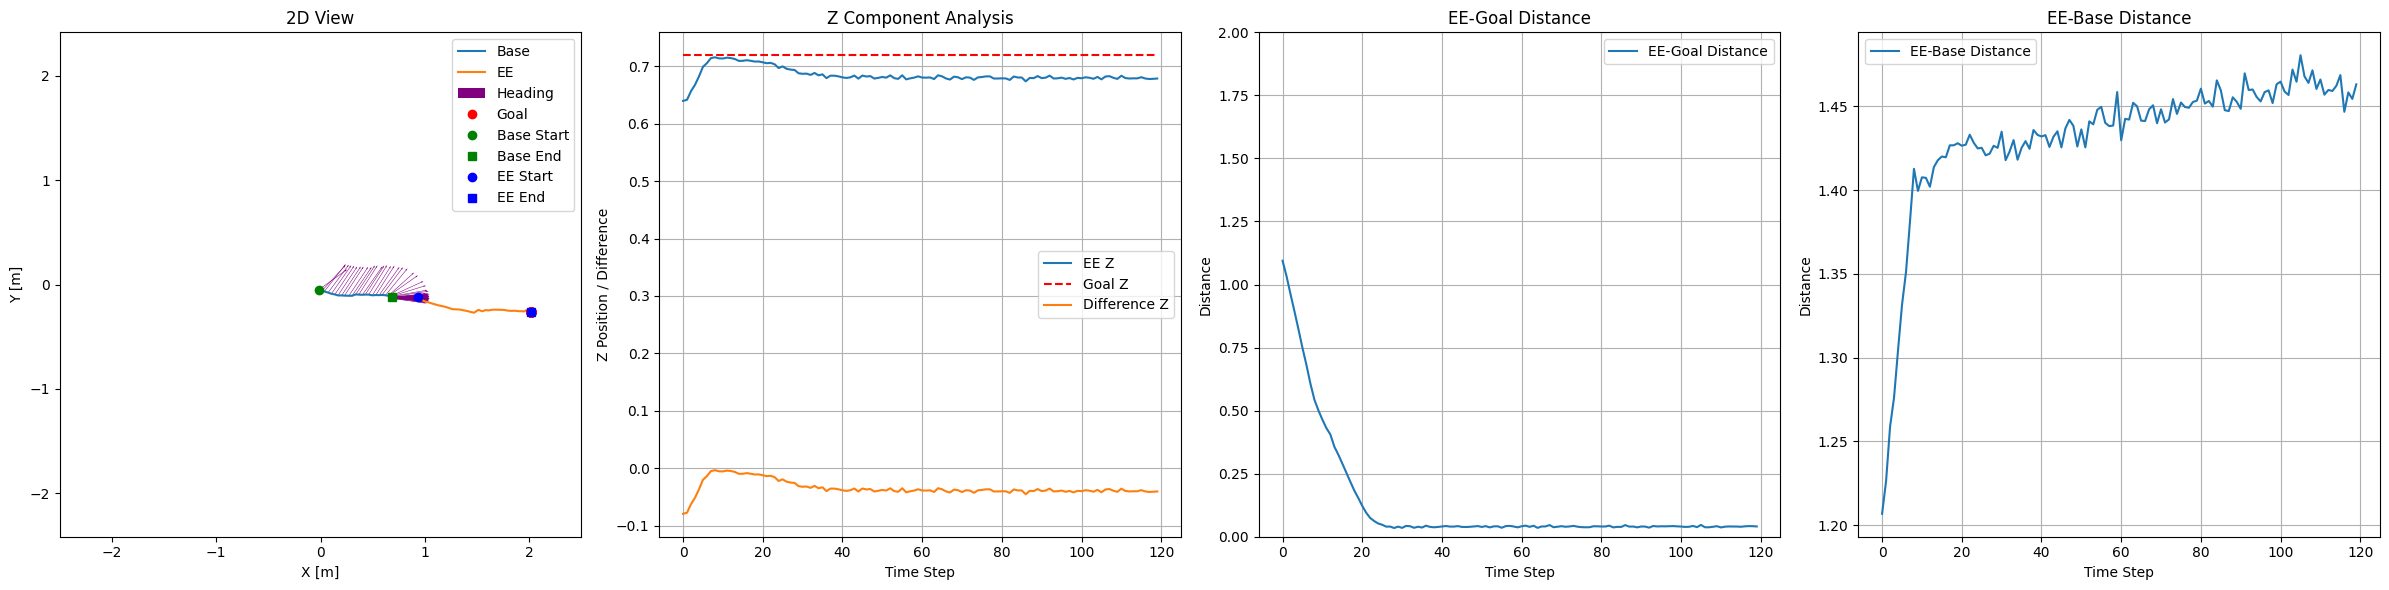

Trajectory 3


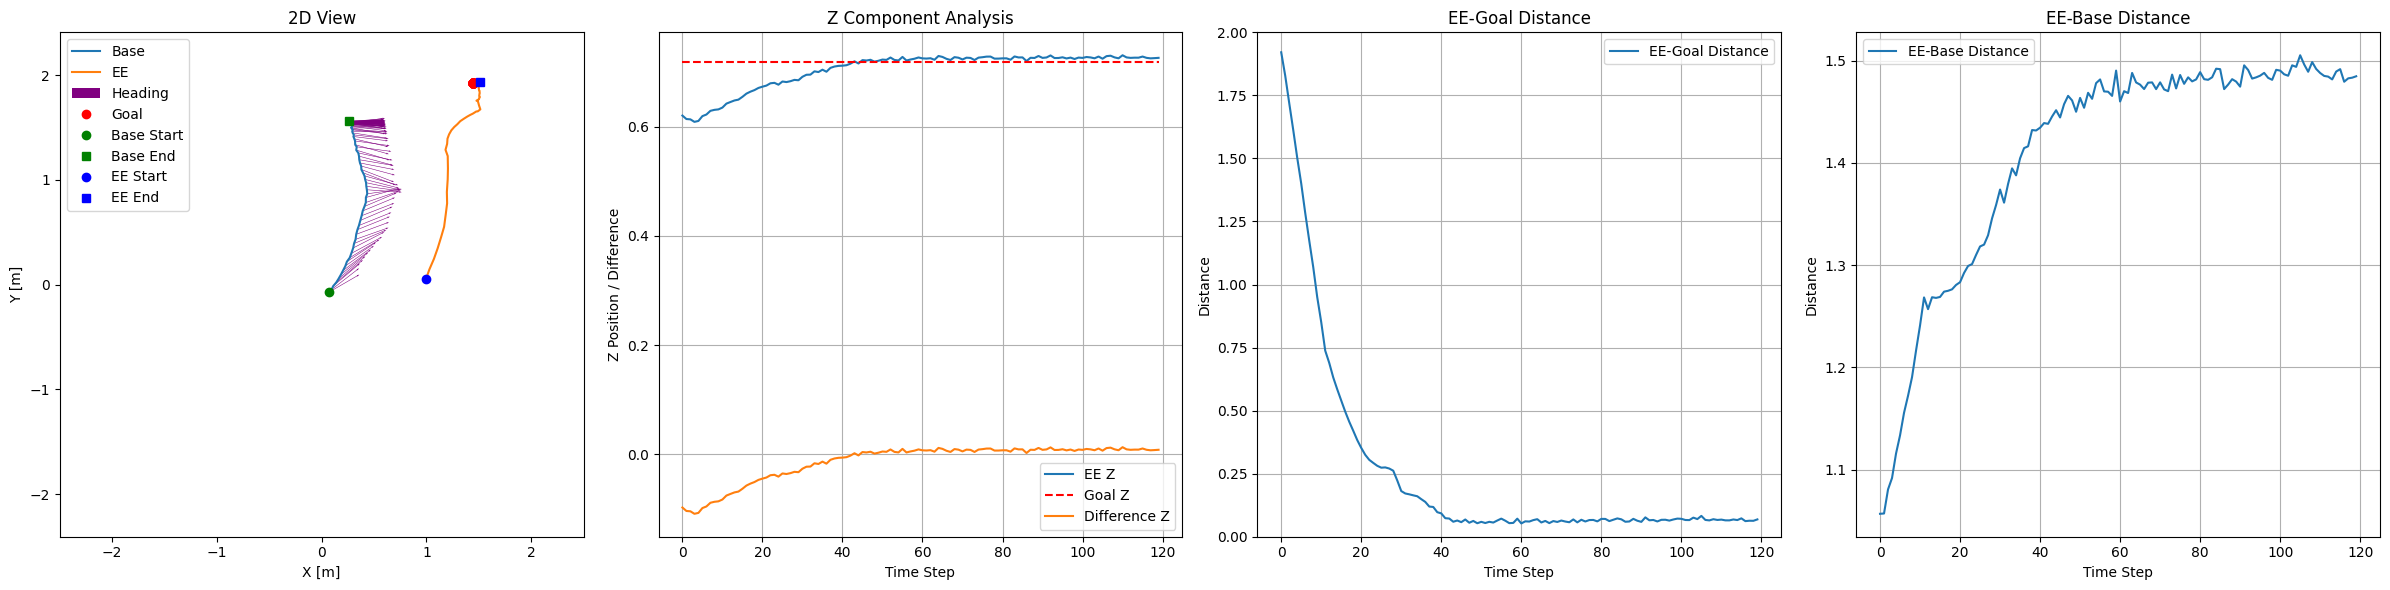

Trajectory 4


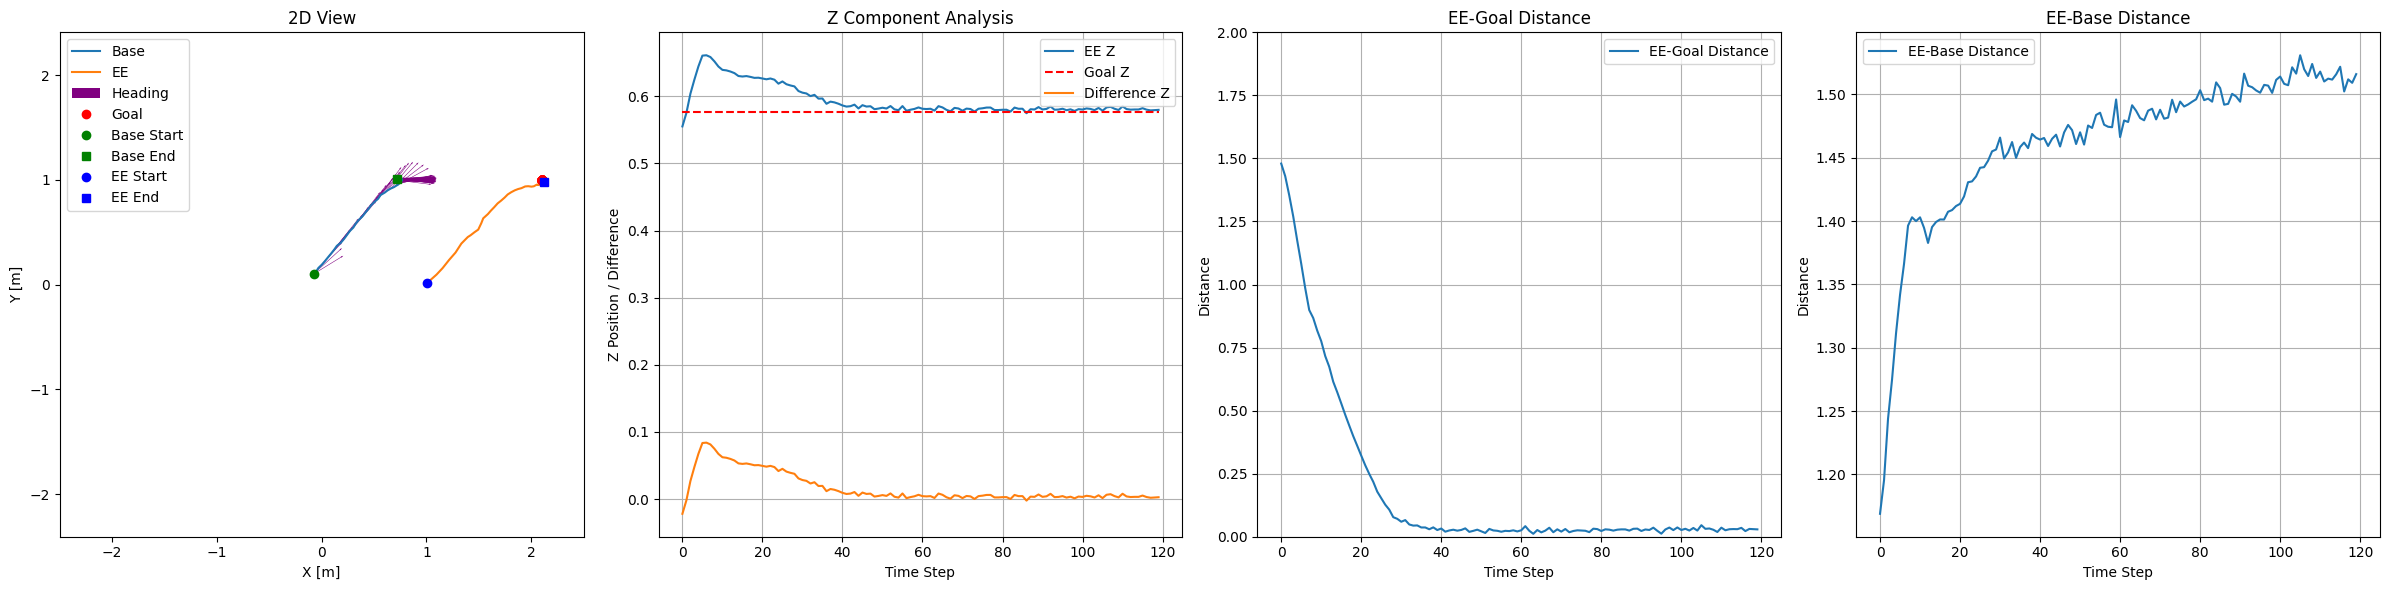

Trajectory 5


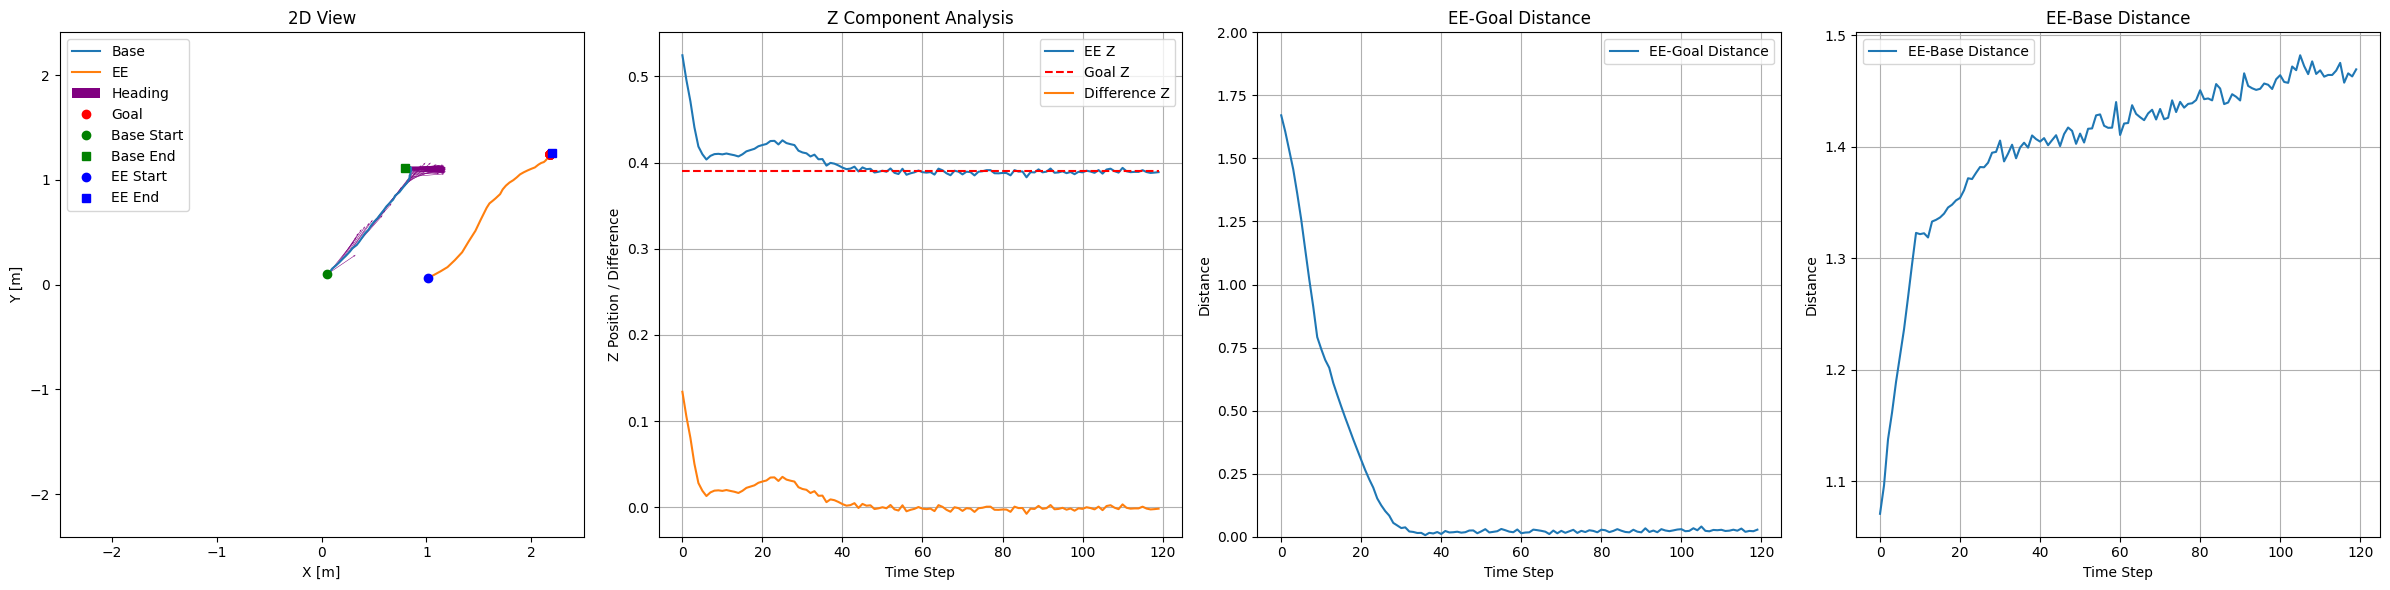

Trajectory 6


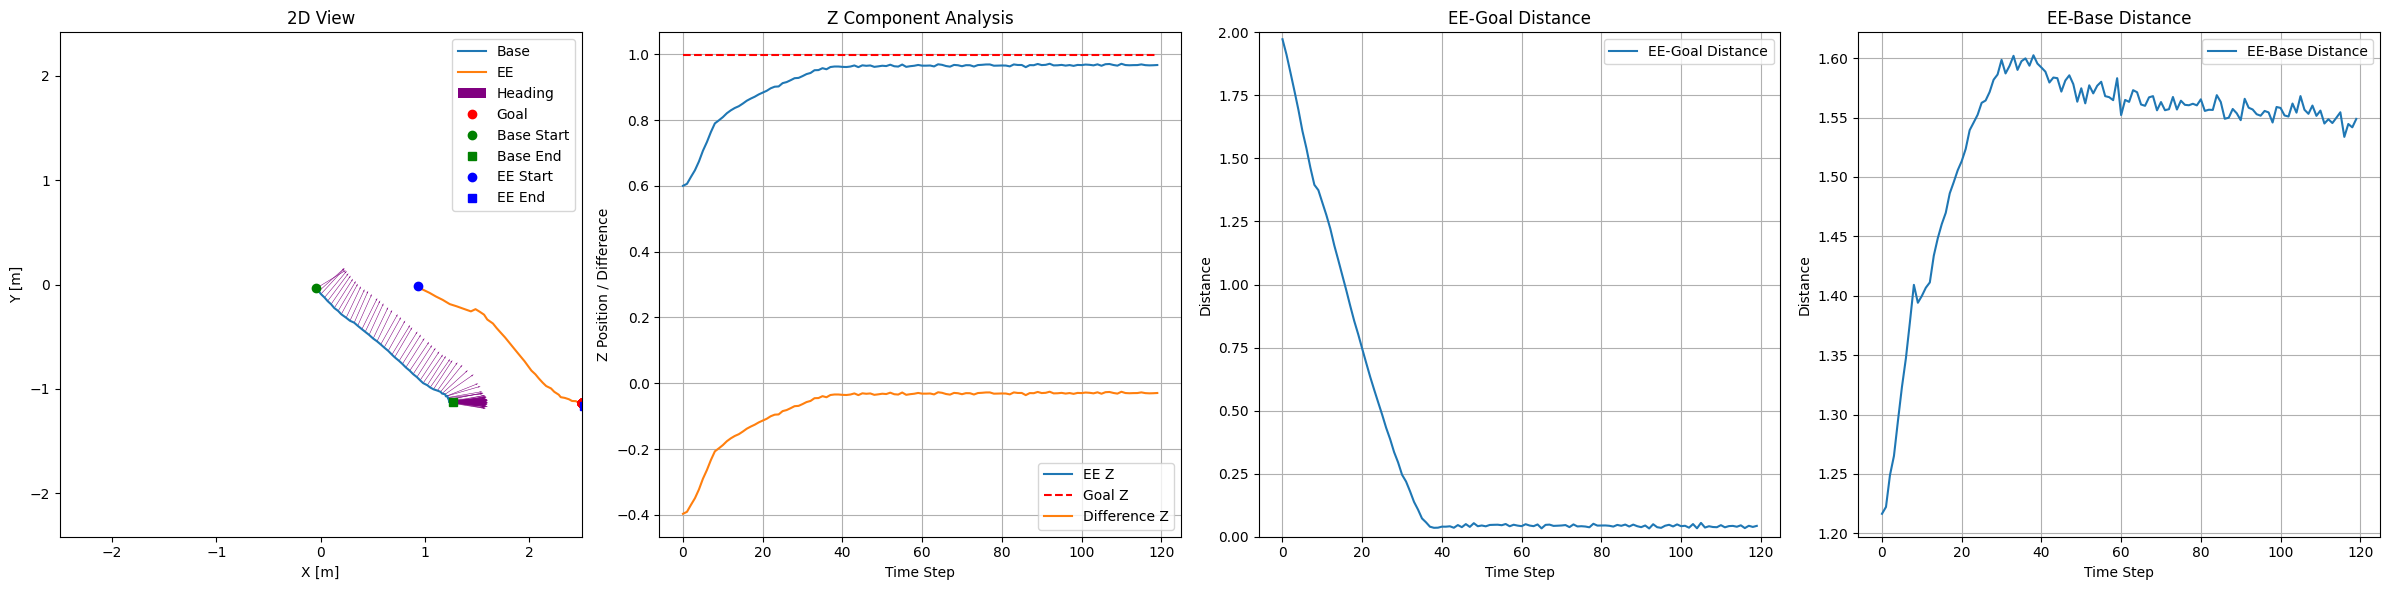

Trajectory 7


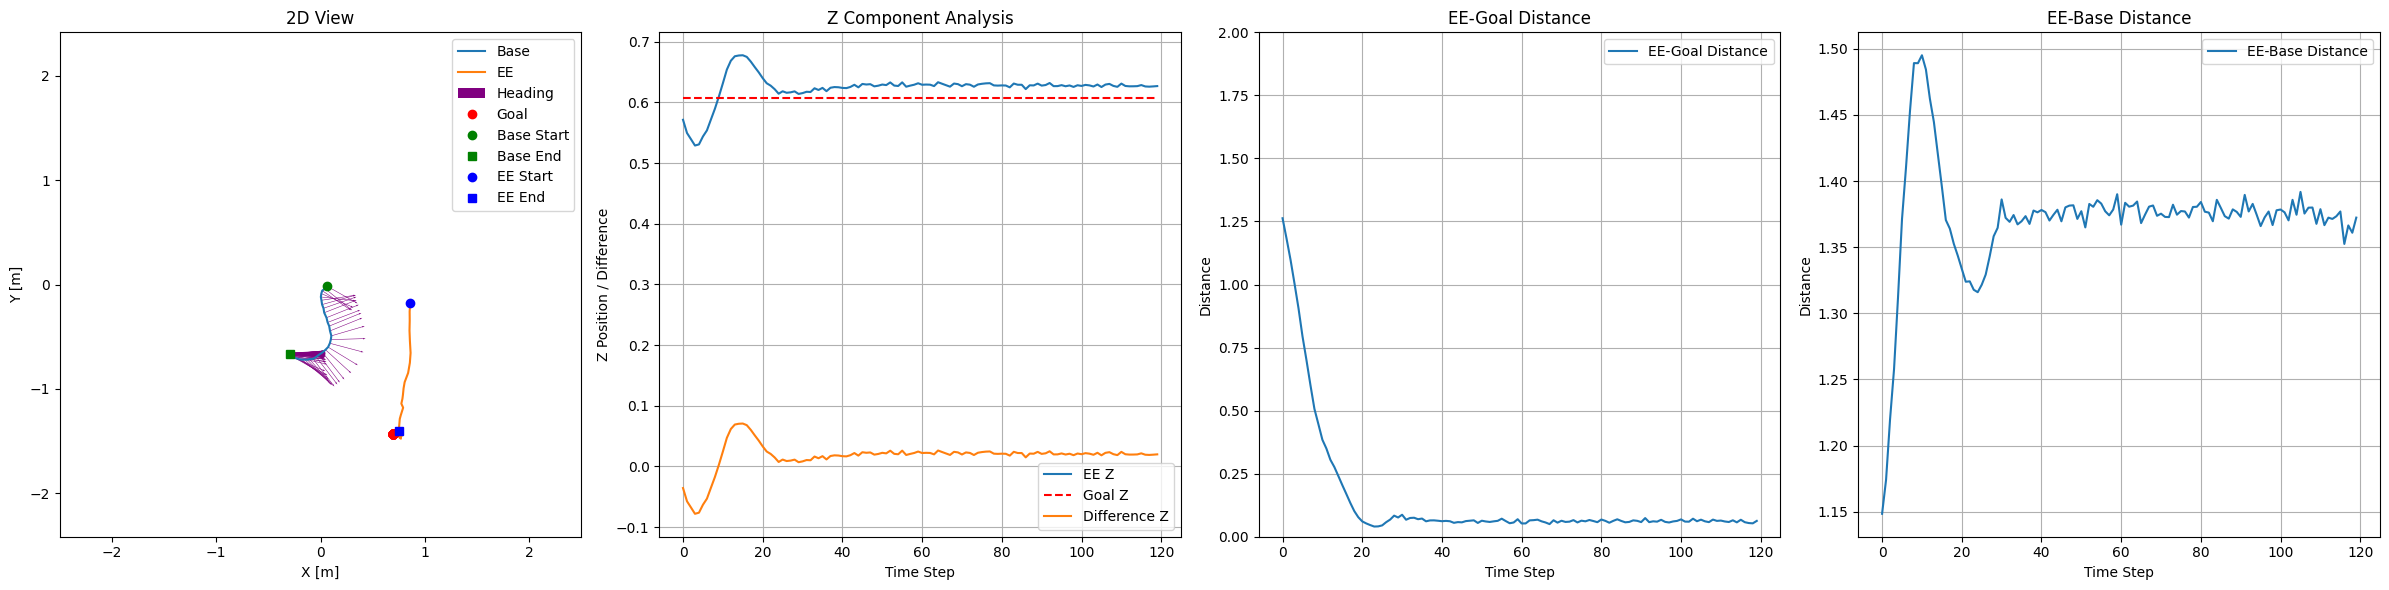

Trajectory 8


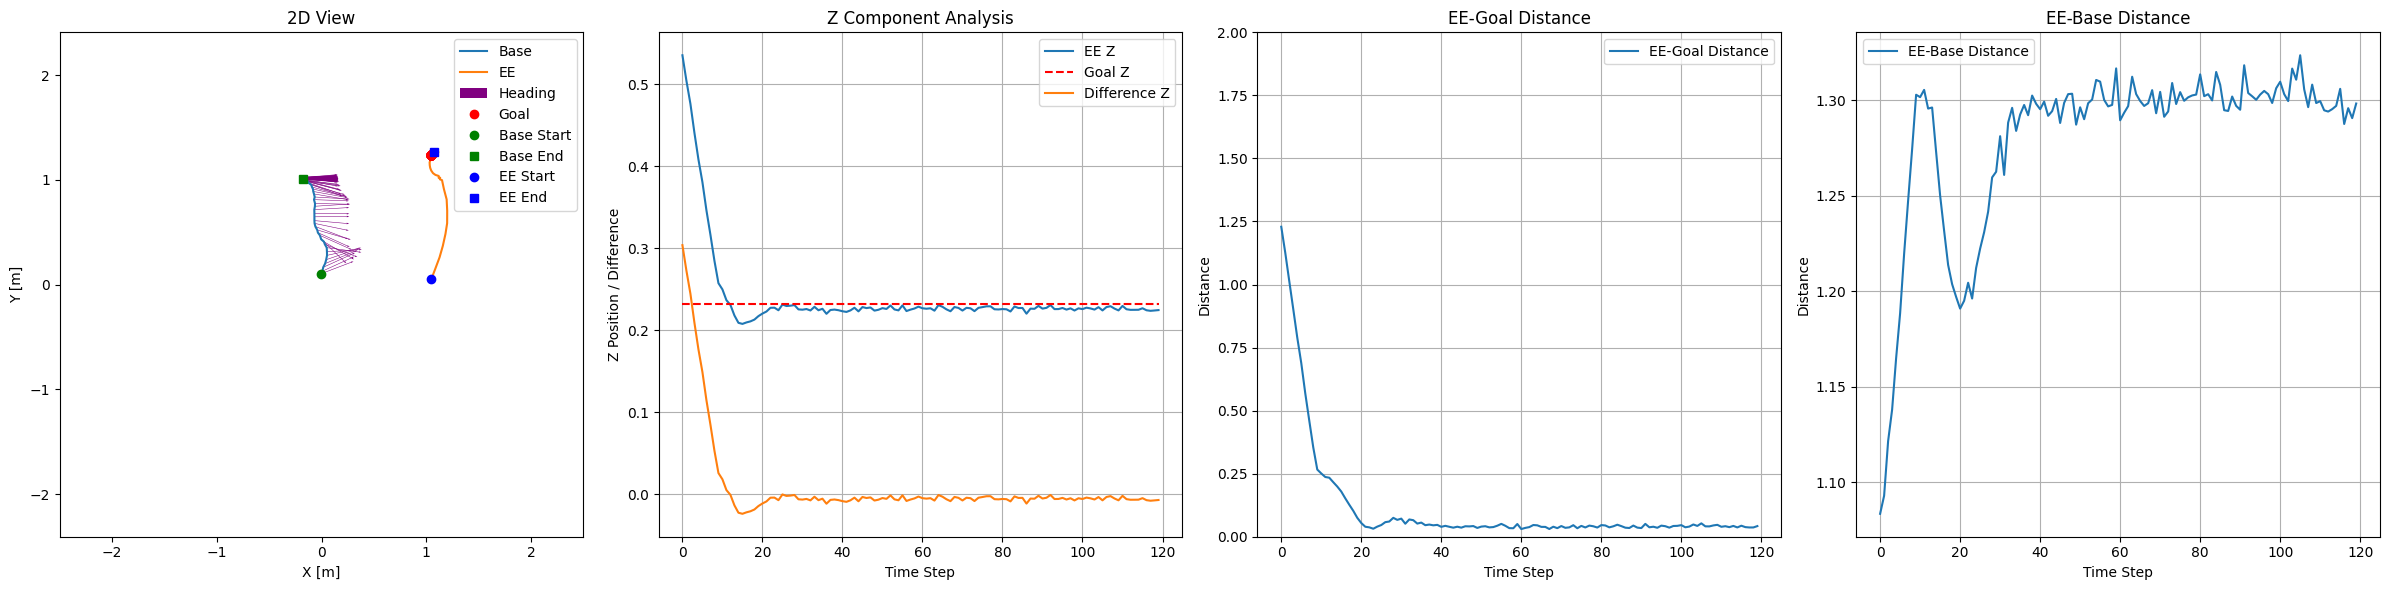

Trajectory 9


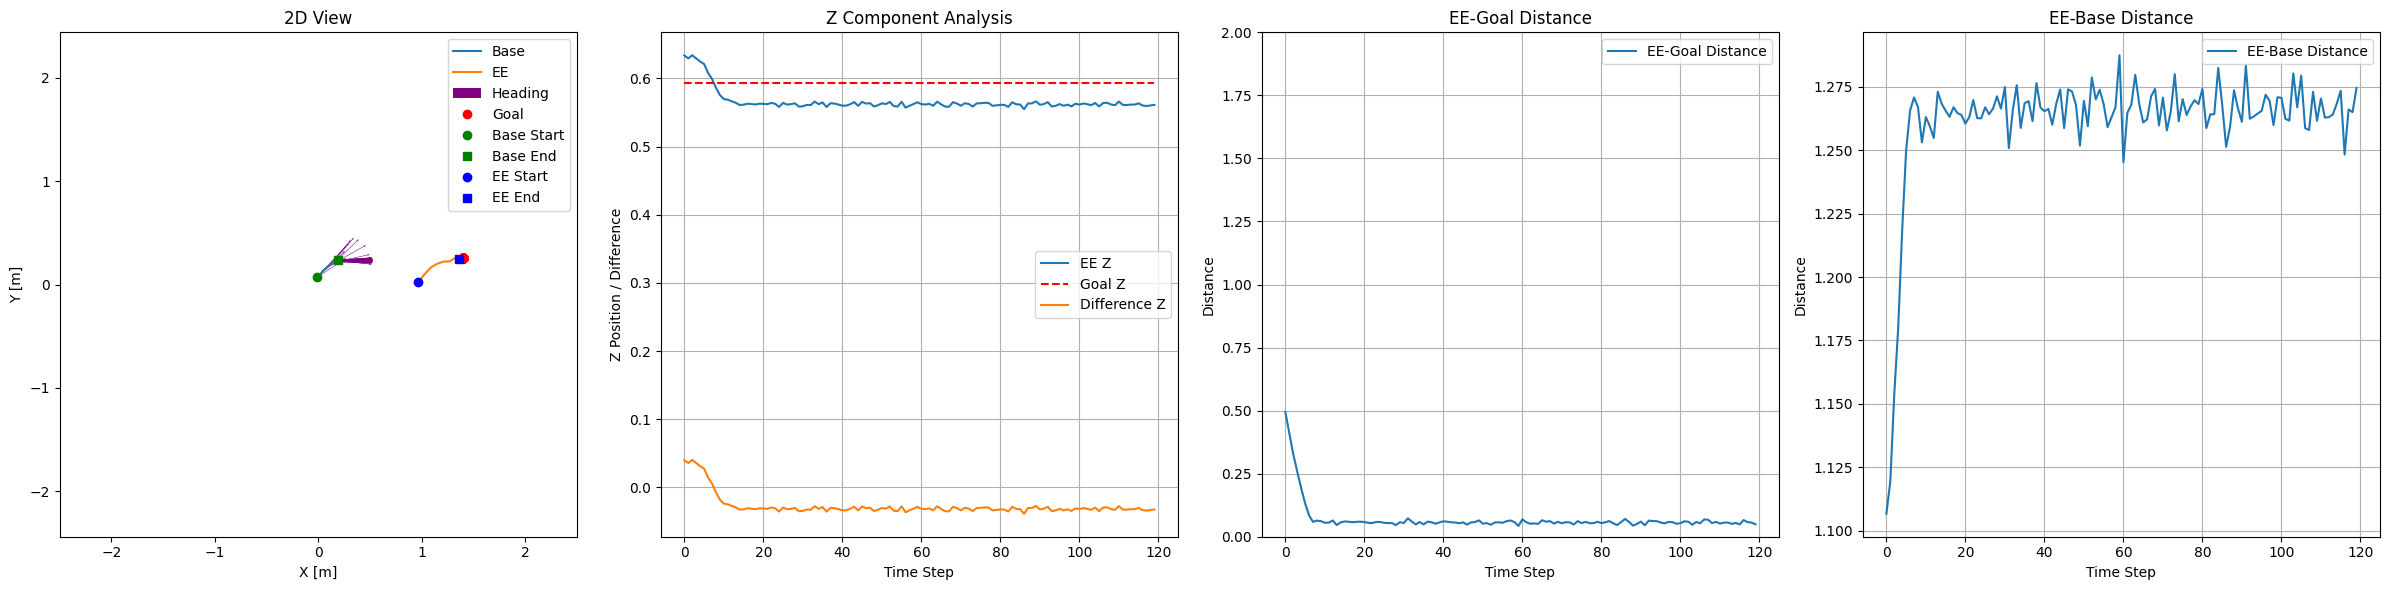

Trajectory 10


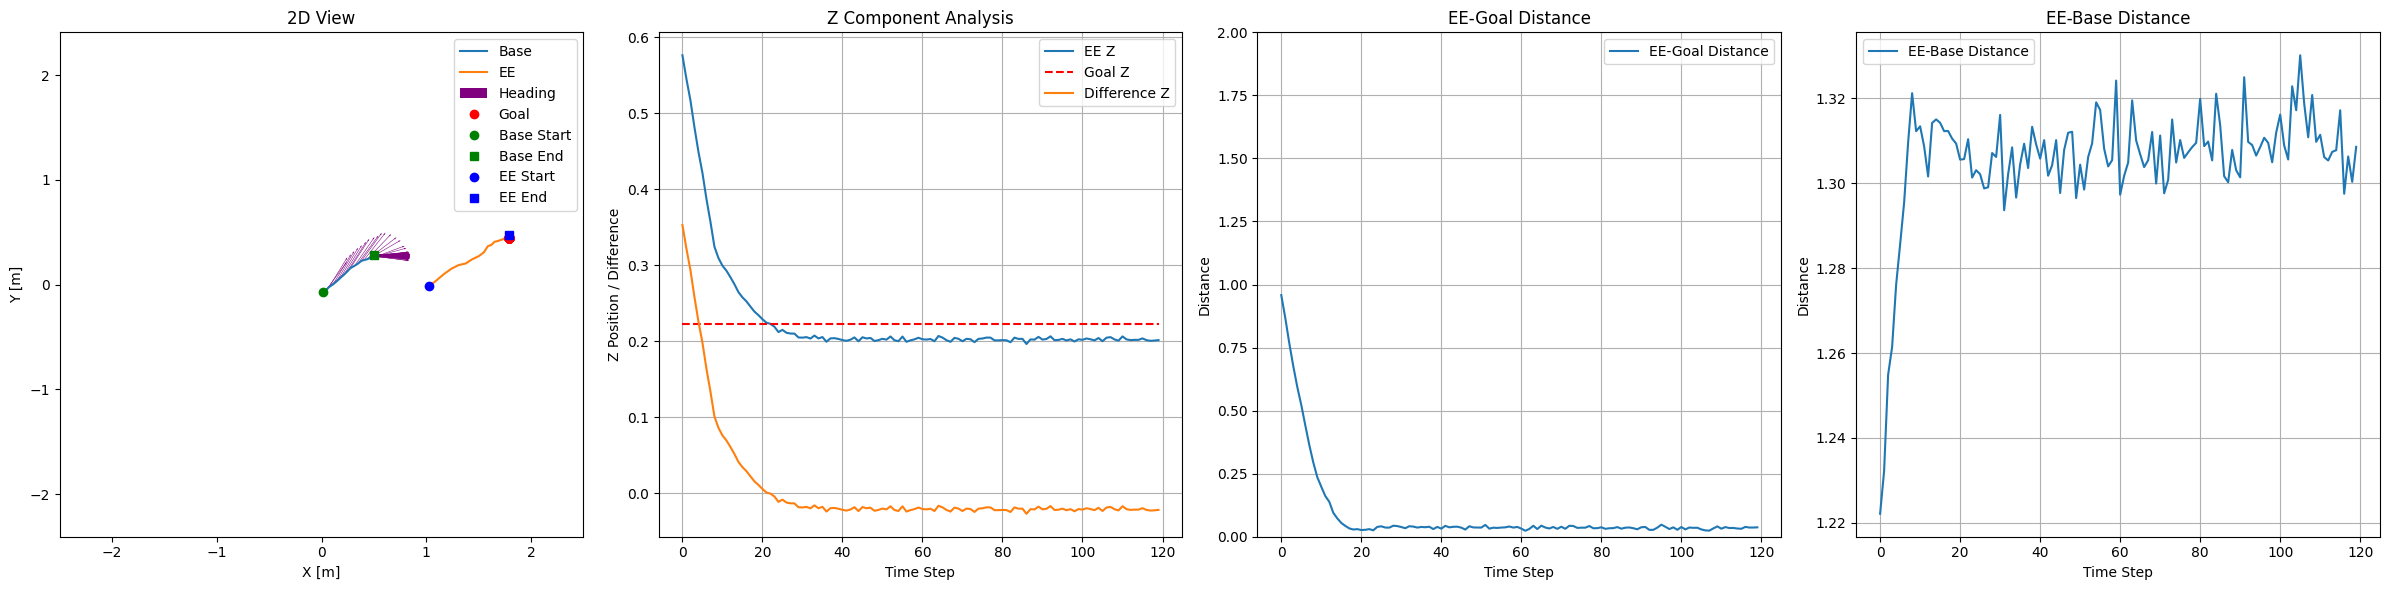

Trajectory 11


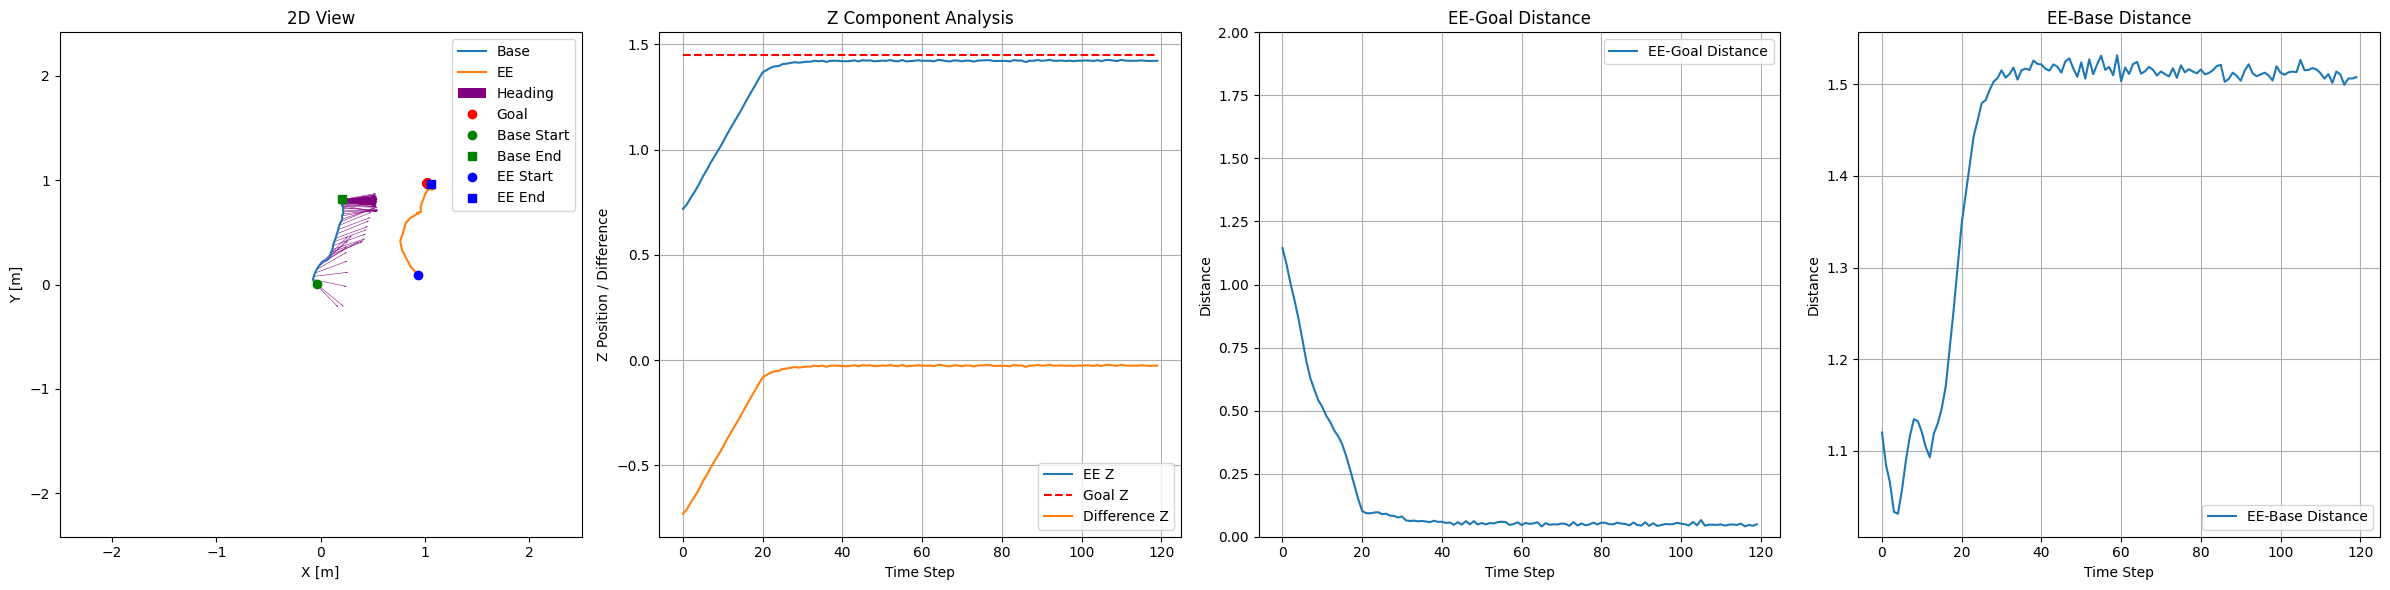

Trajectory 12


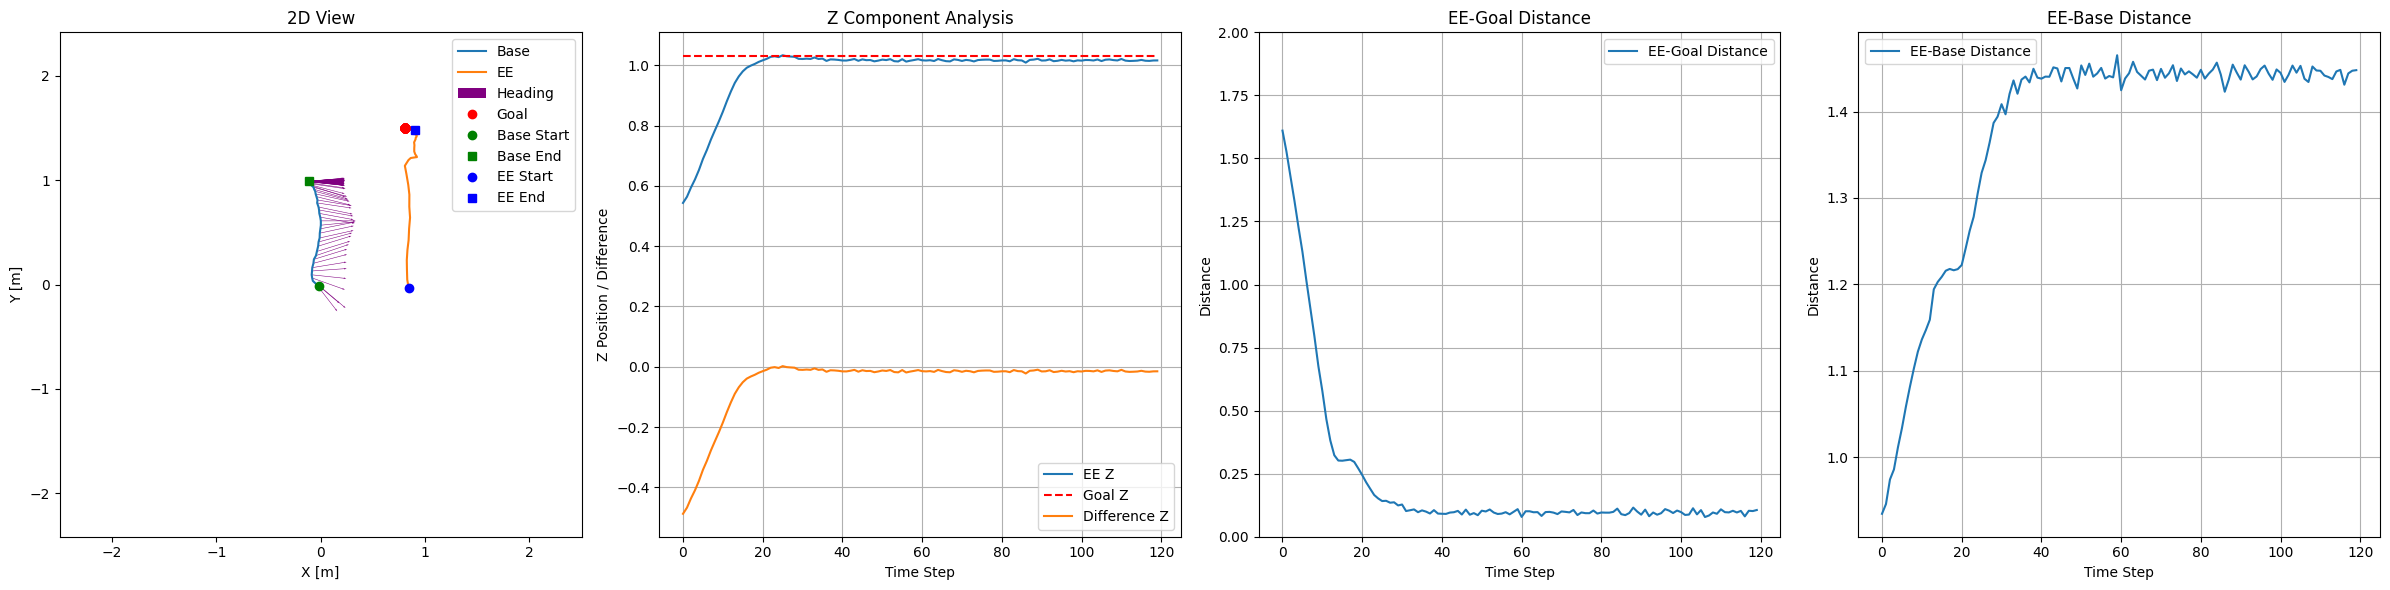

Trajectory 13


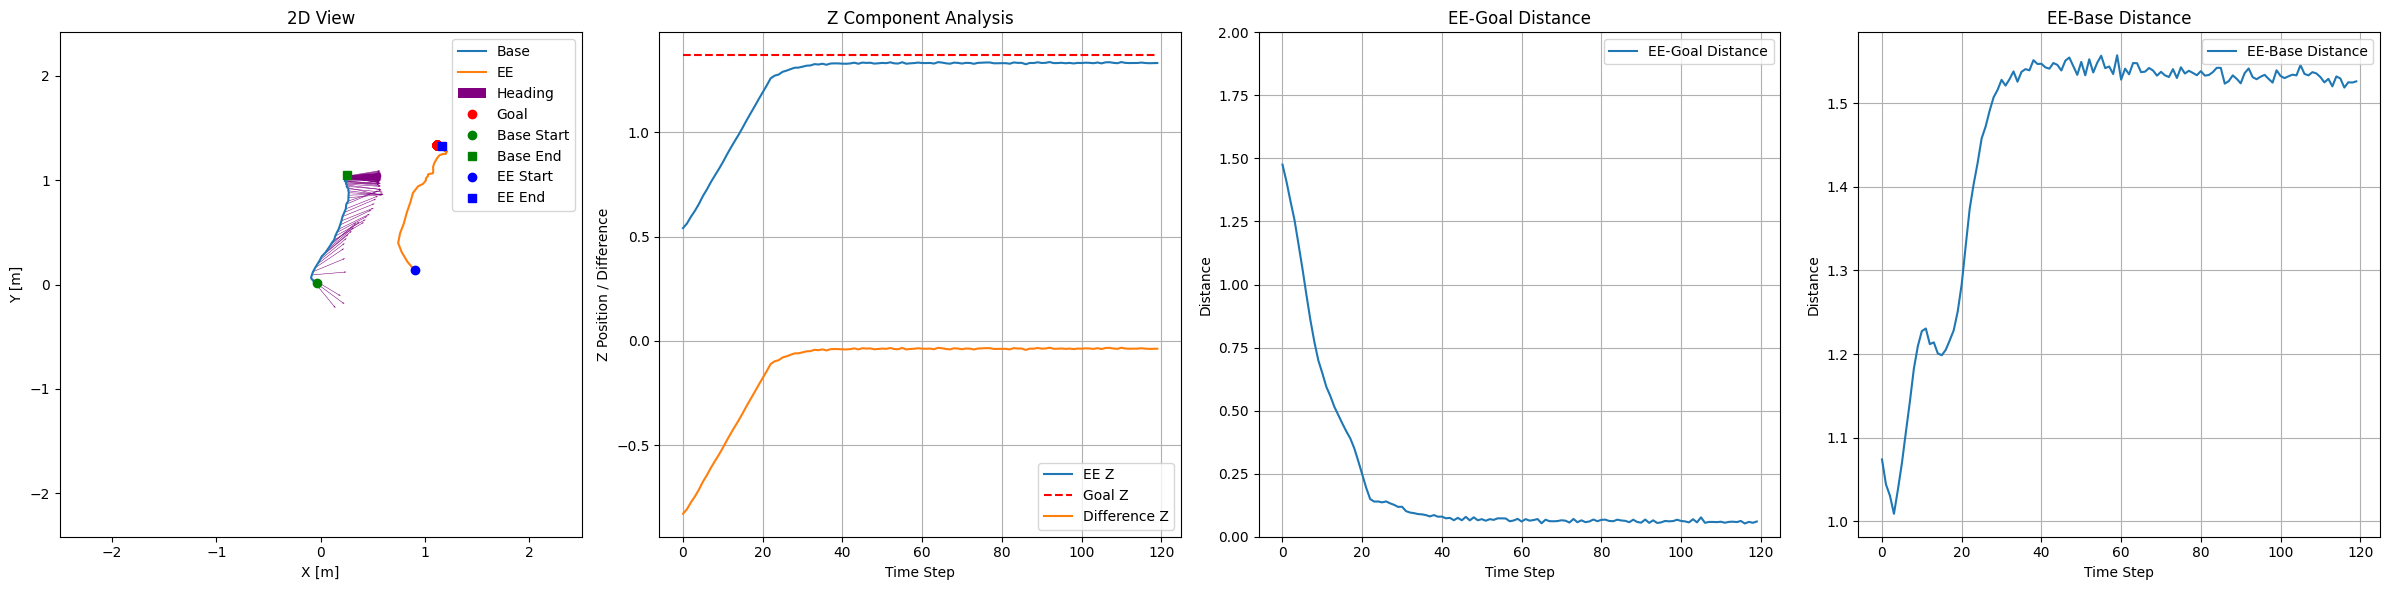

Trajectory 14


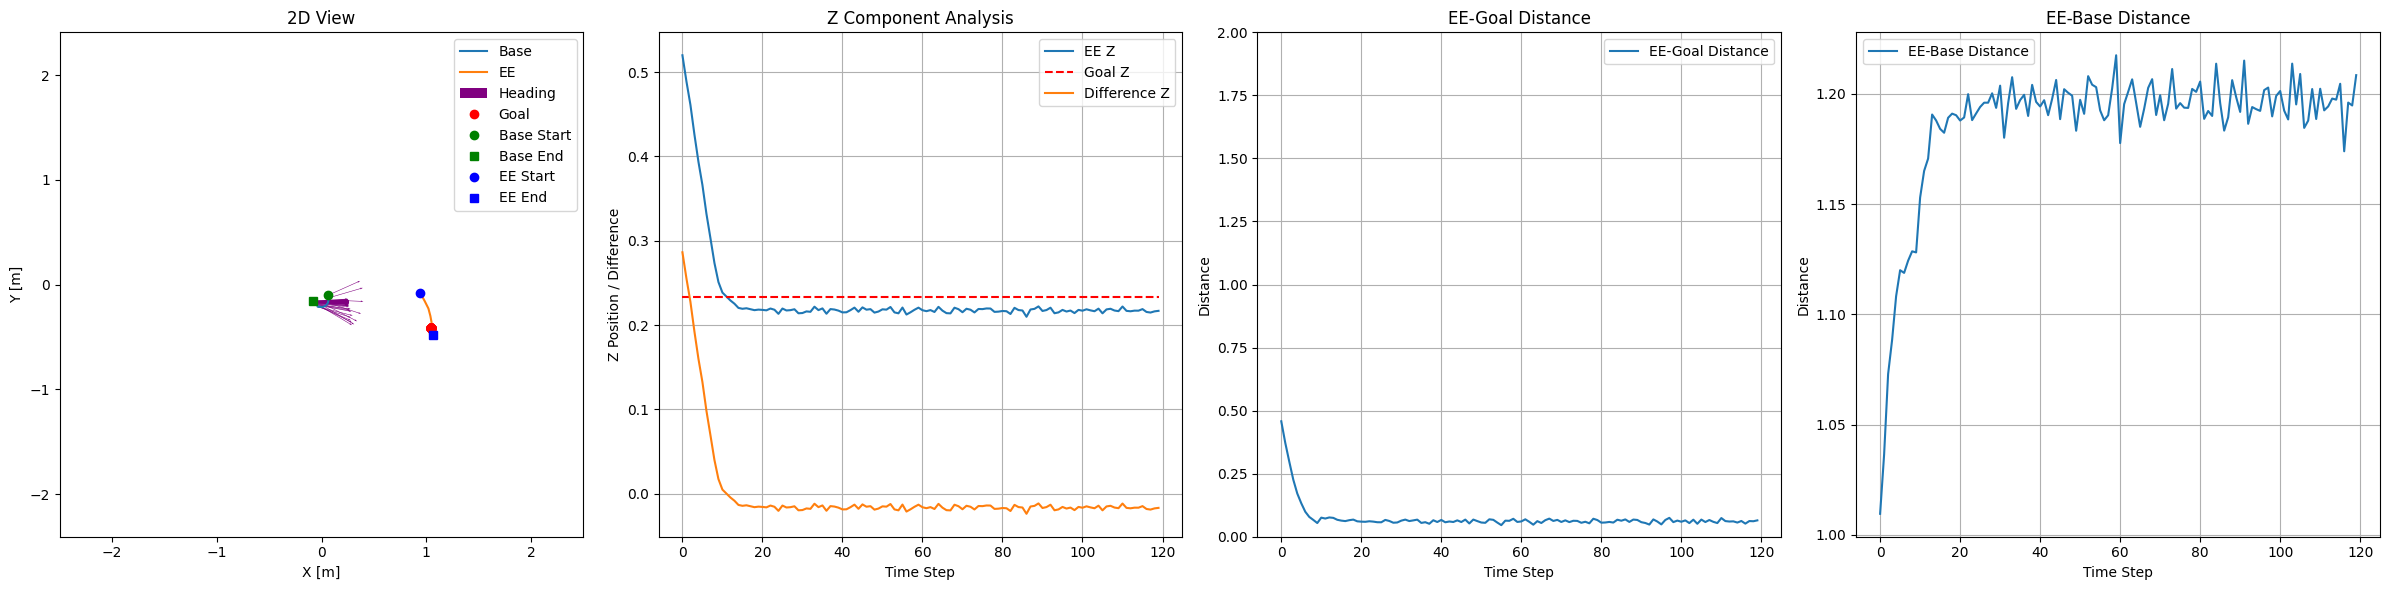

Trajectory 15


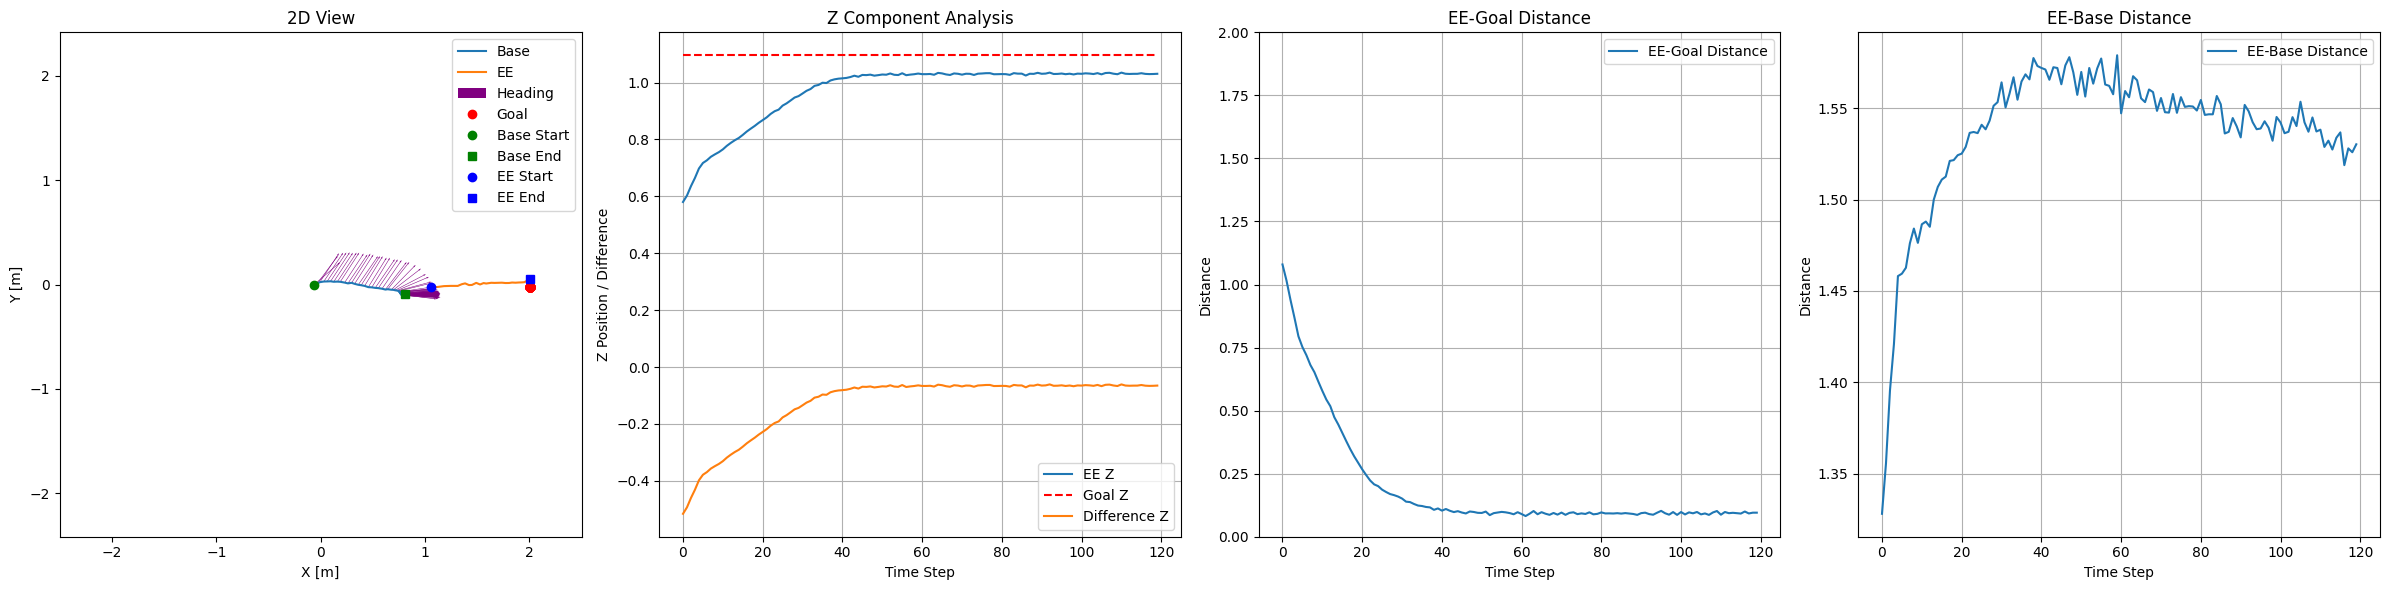

Trajectory 16


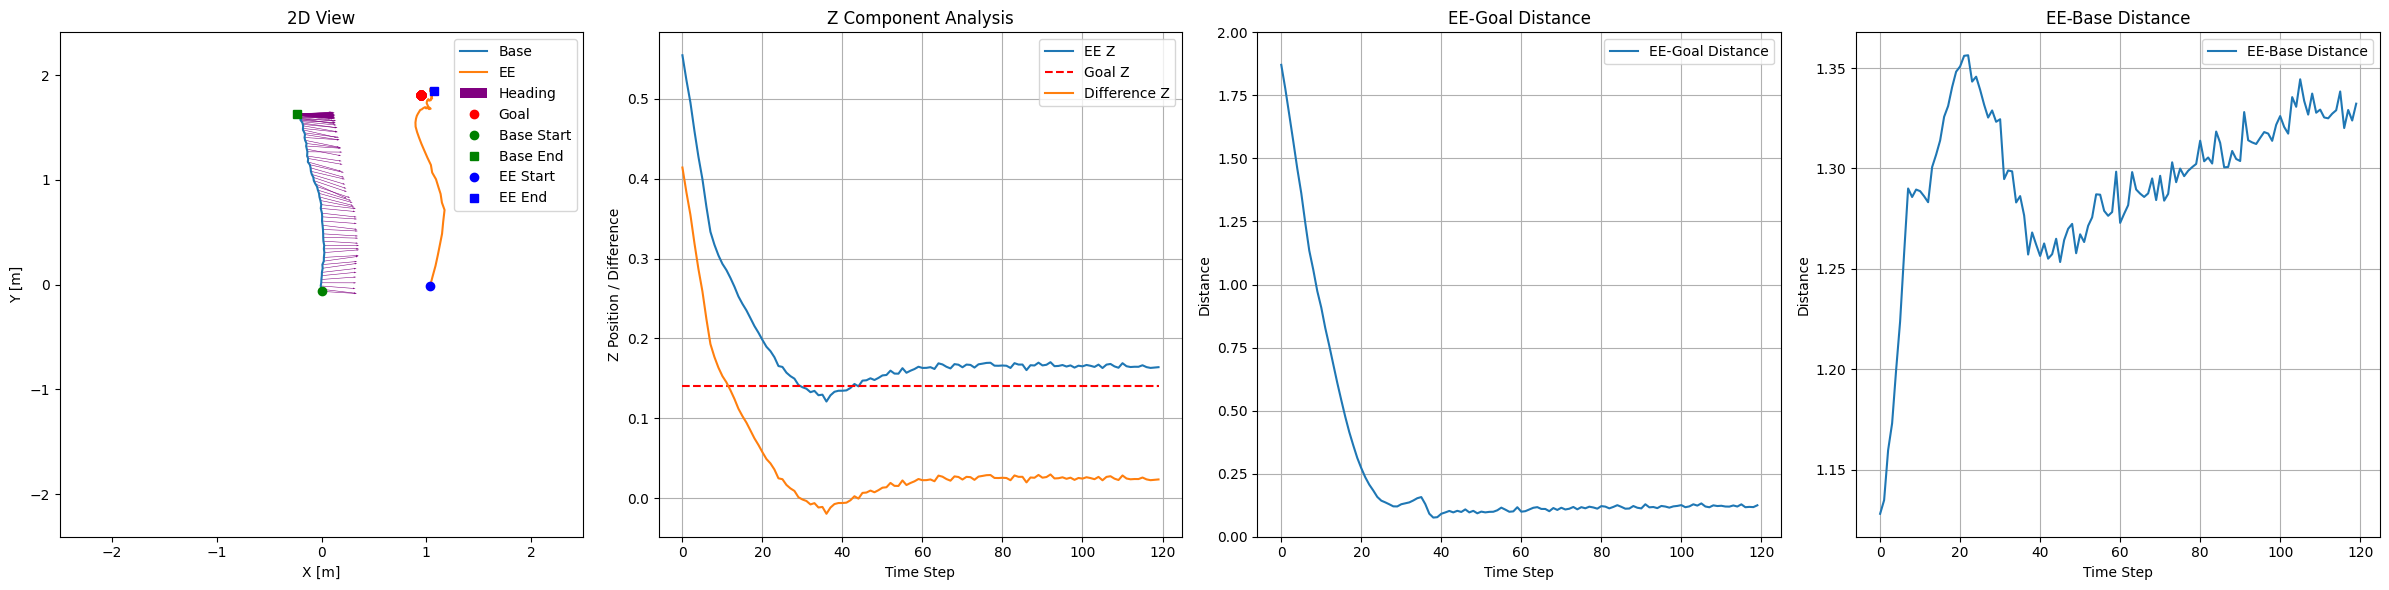

Trajectory 17


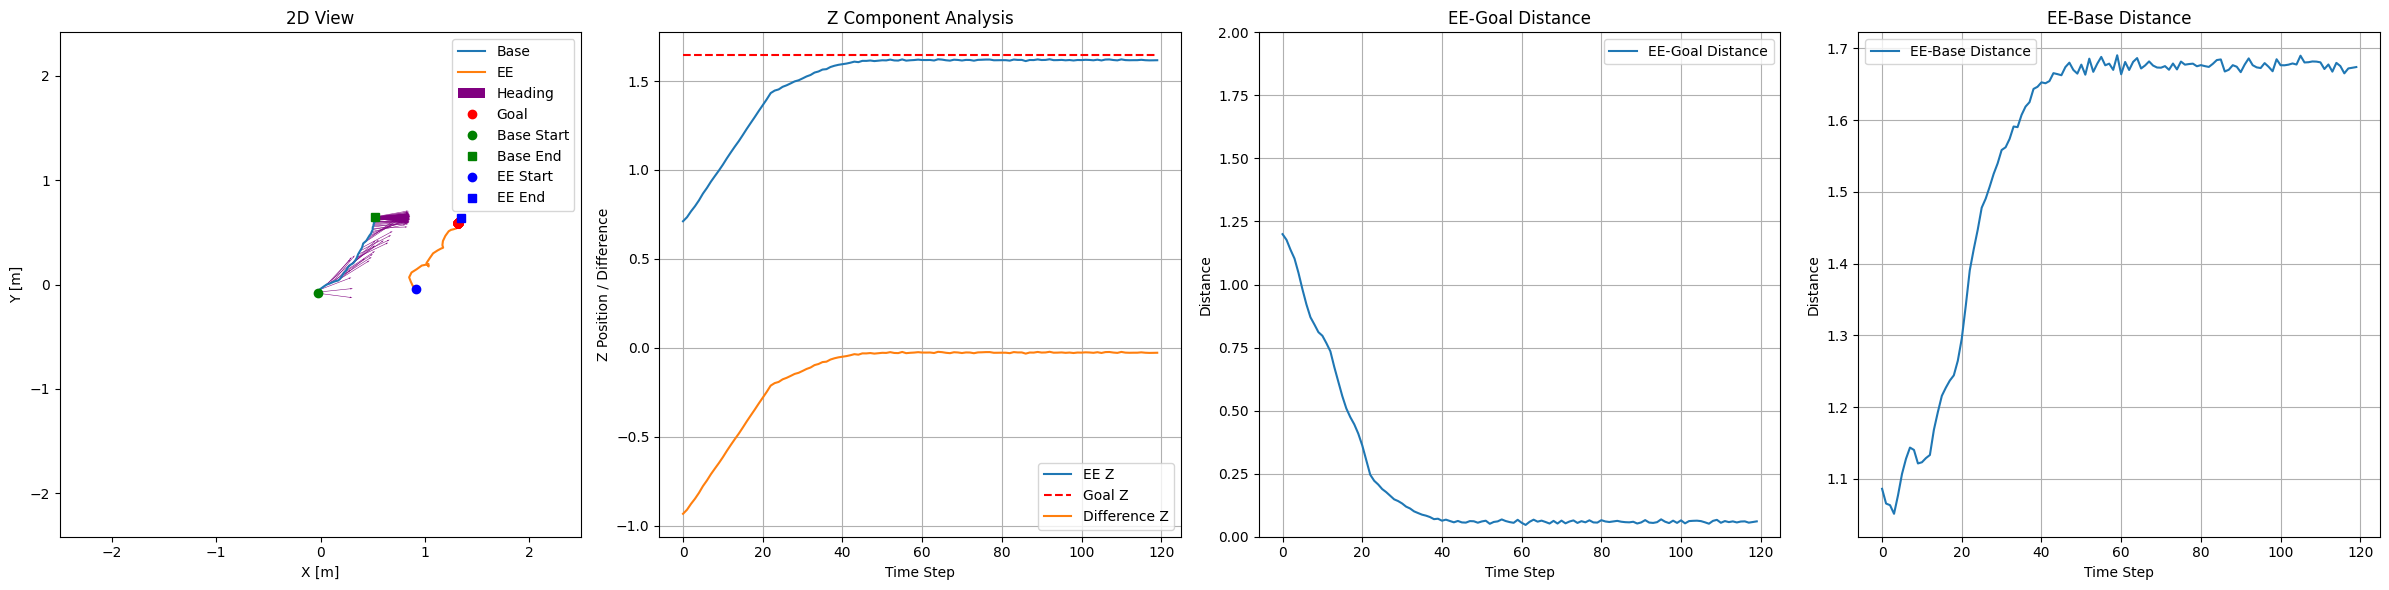

Trajectory 18


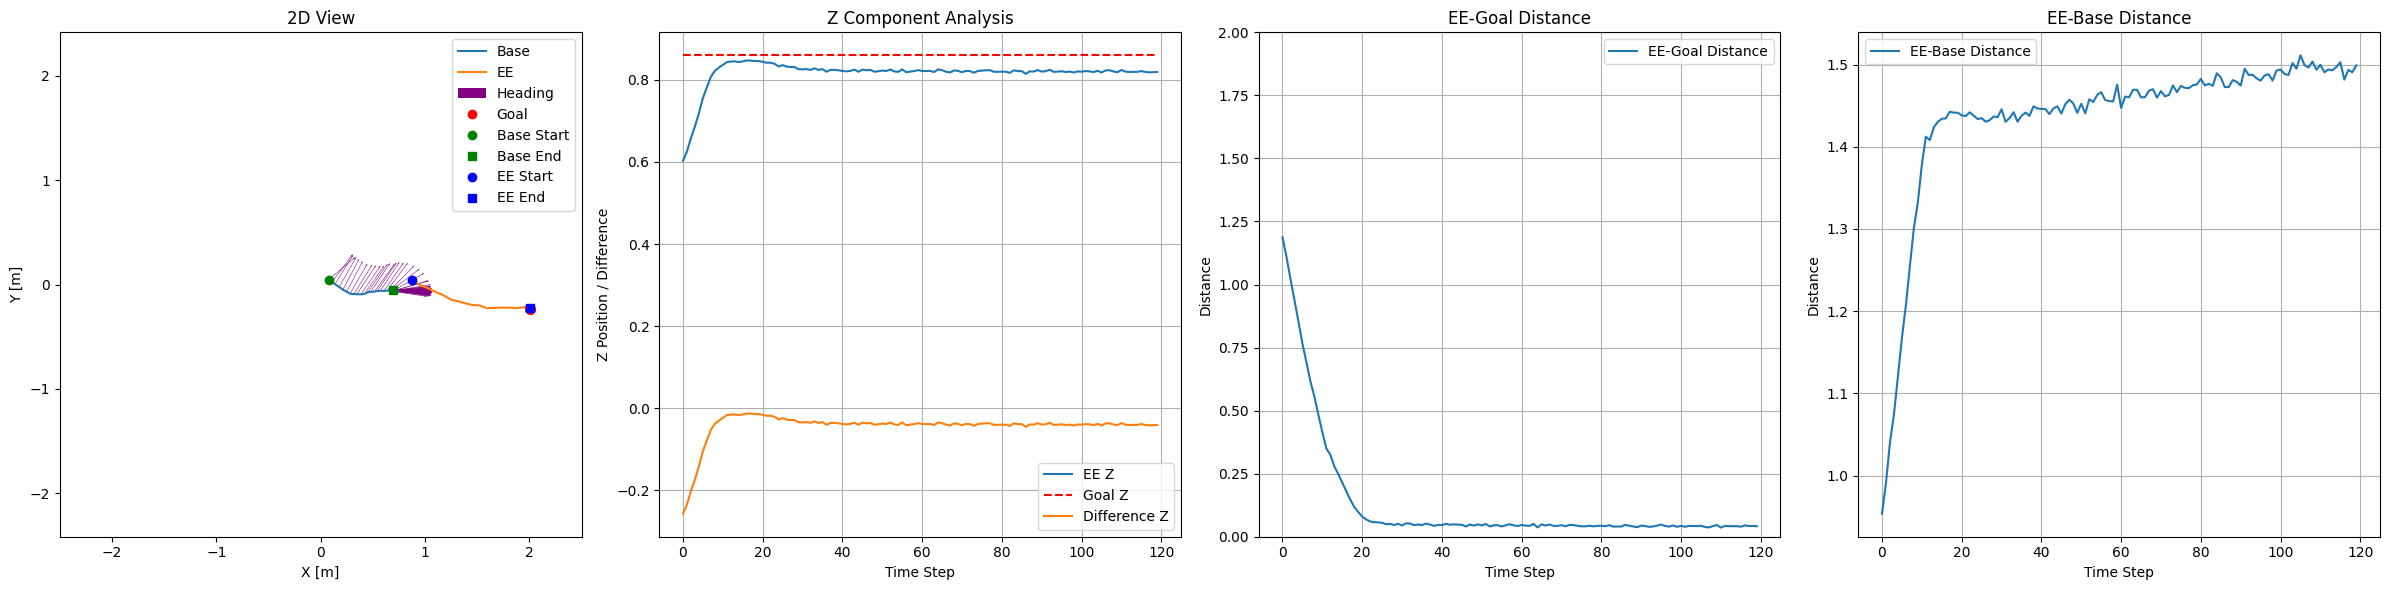

Trajectory 19


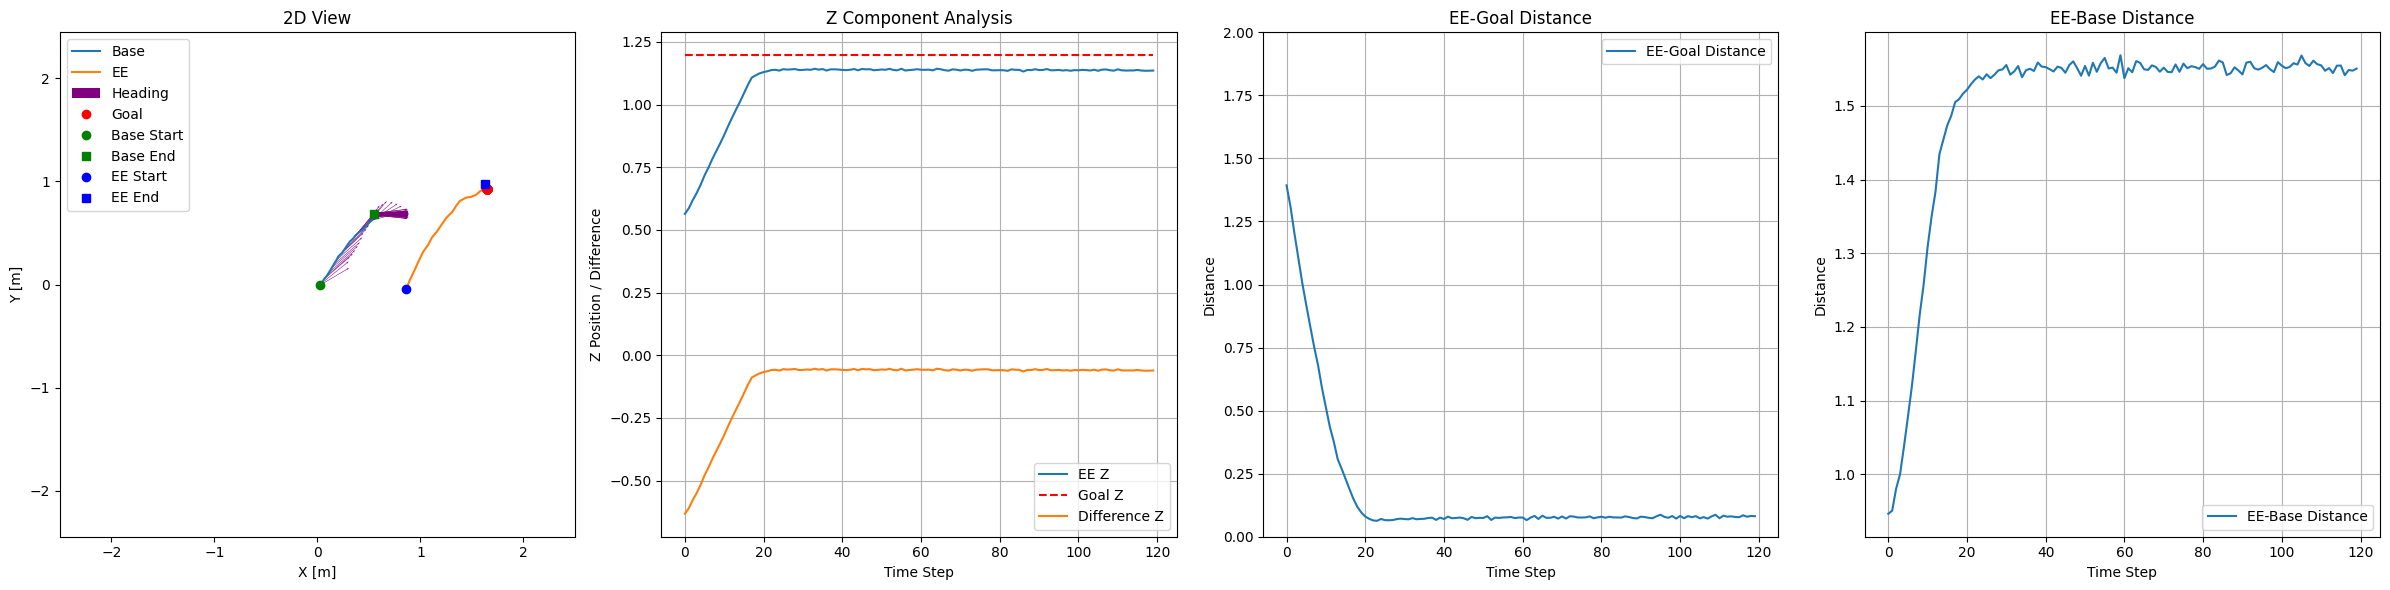

Trajectory 20


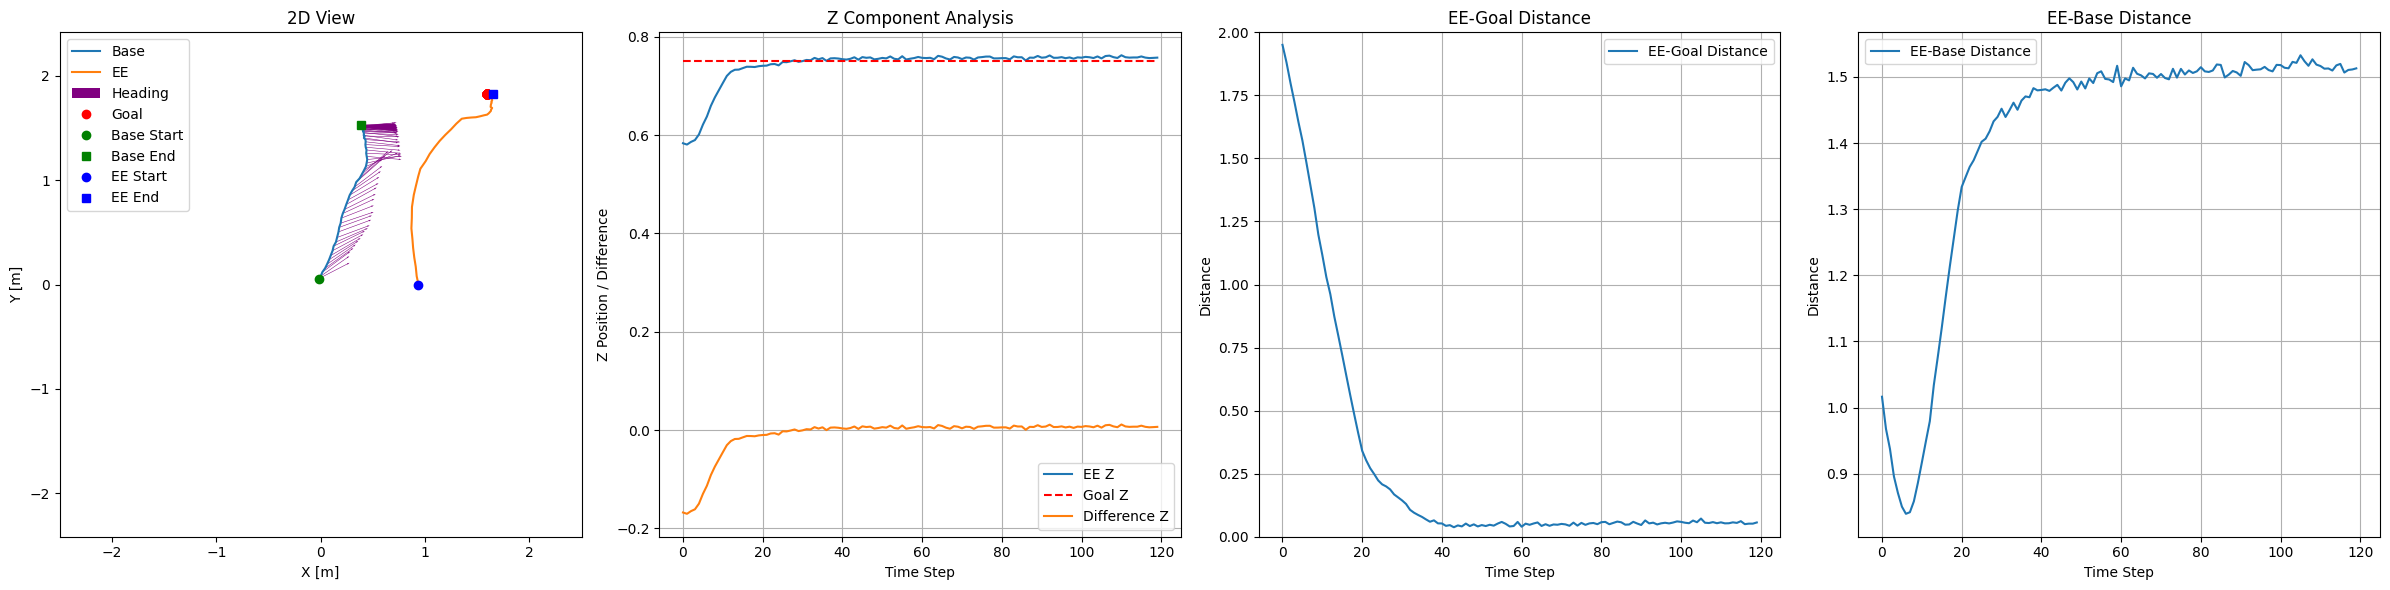

Trajectory 21


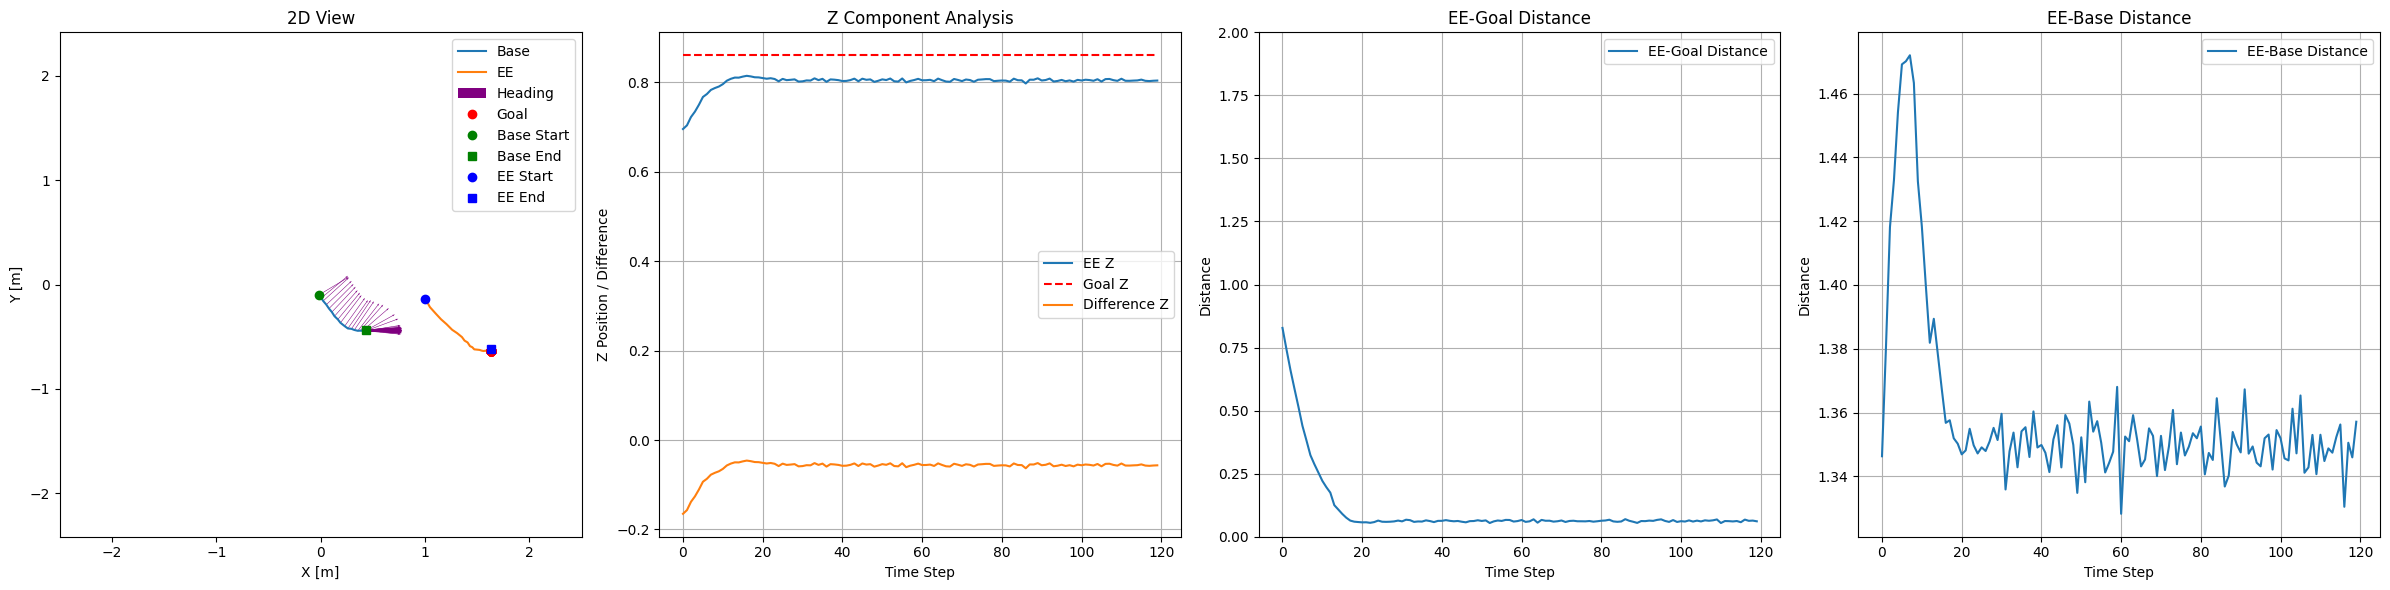

Trajectory 22


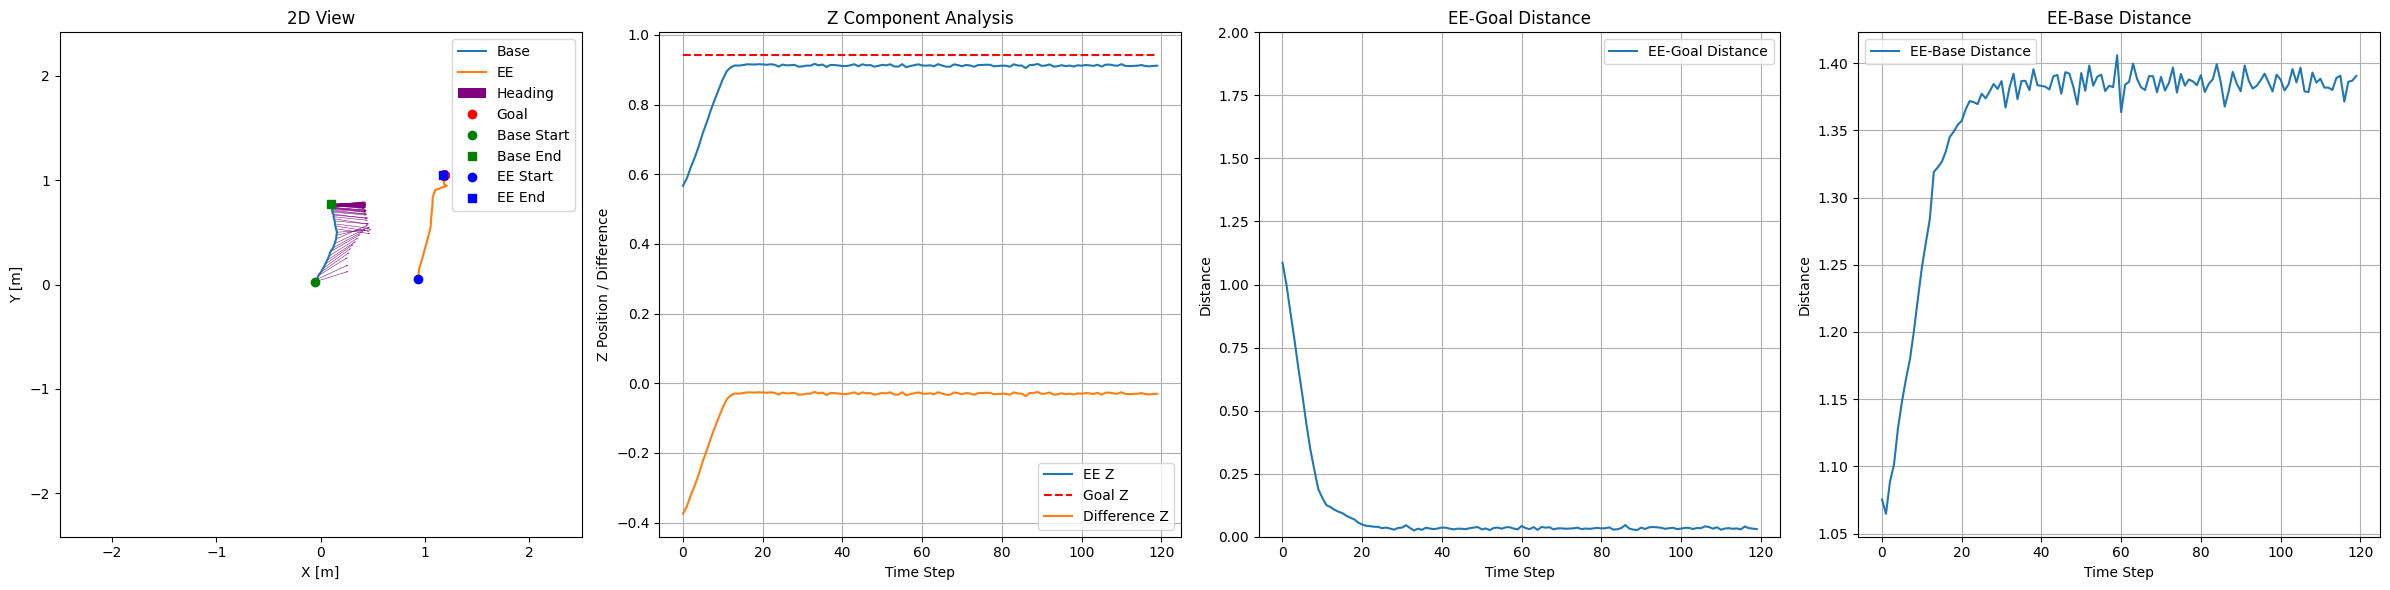

Trajectory 23


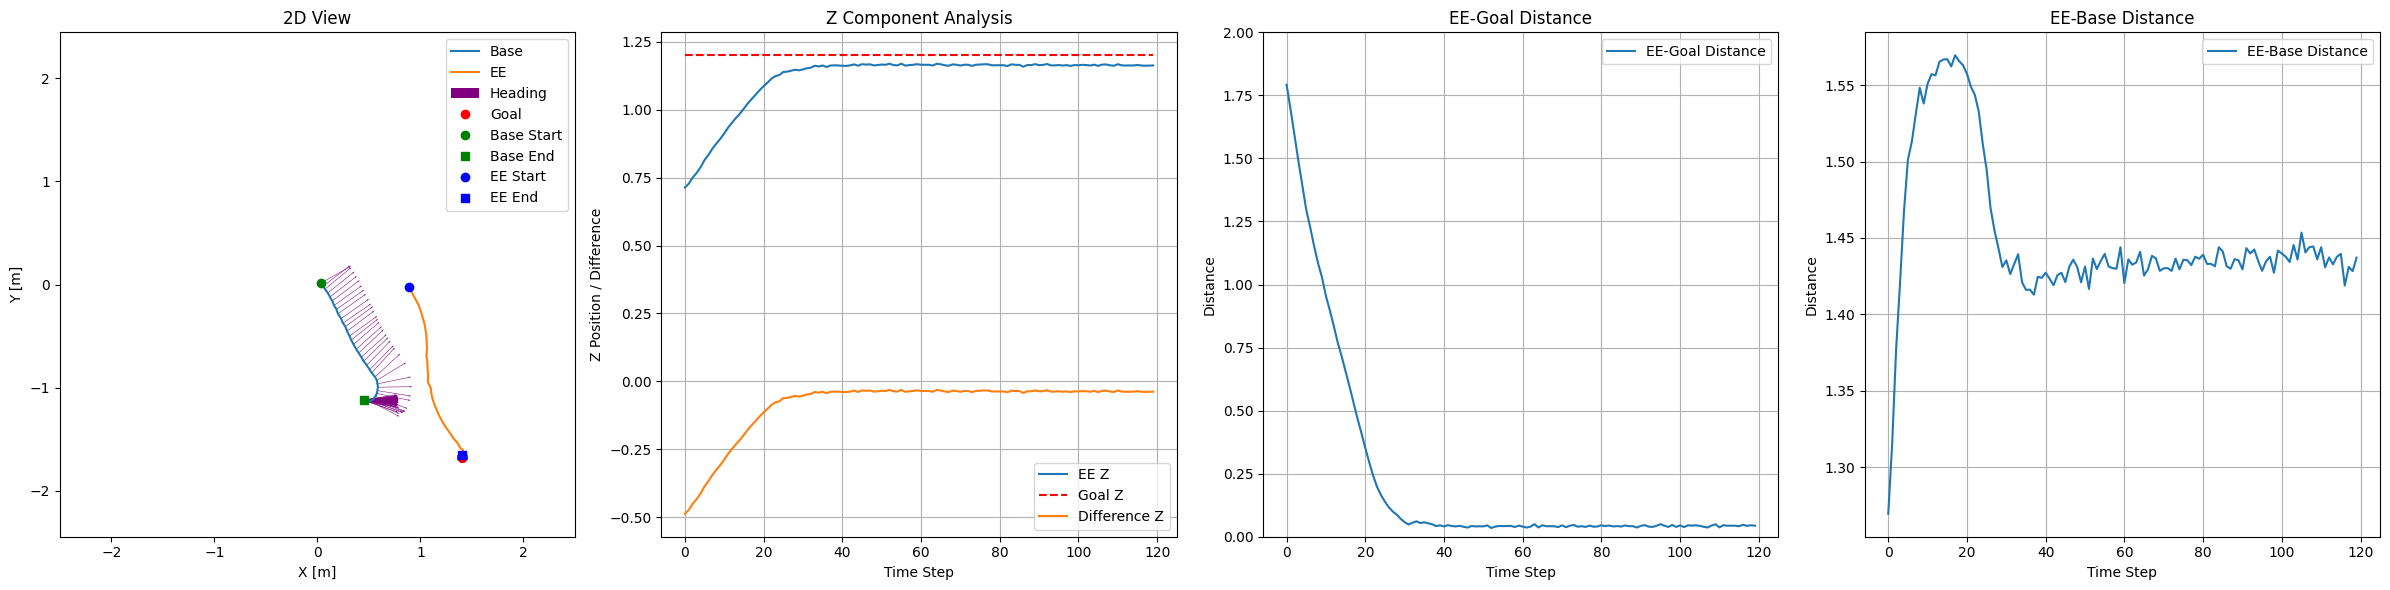

Trajectory 24


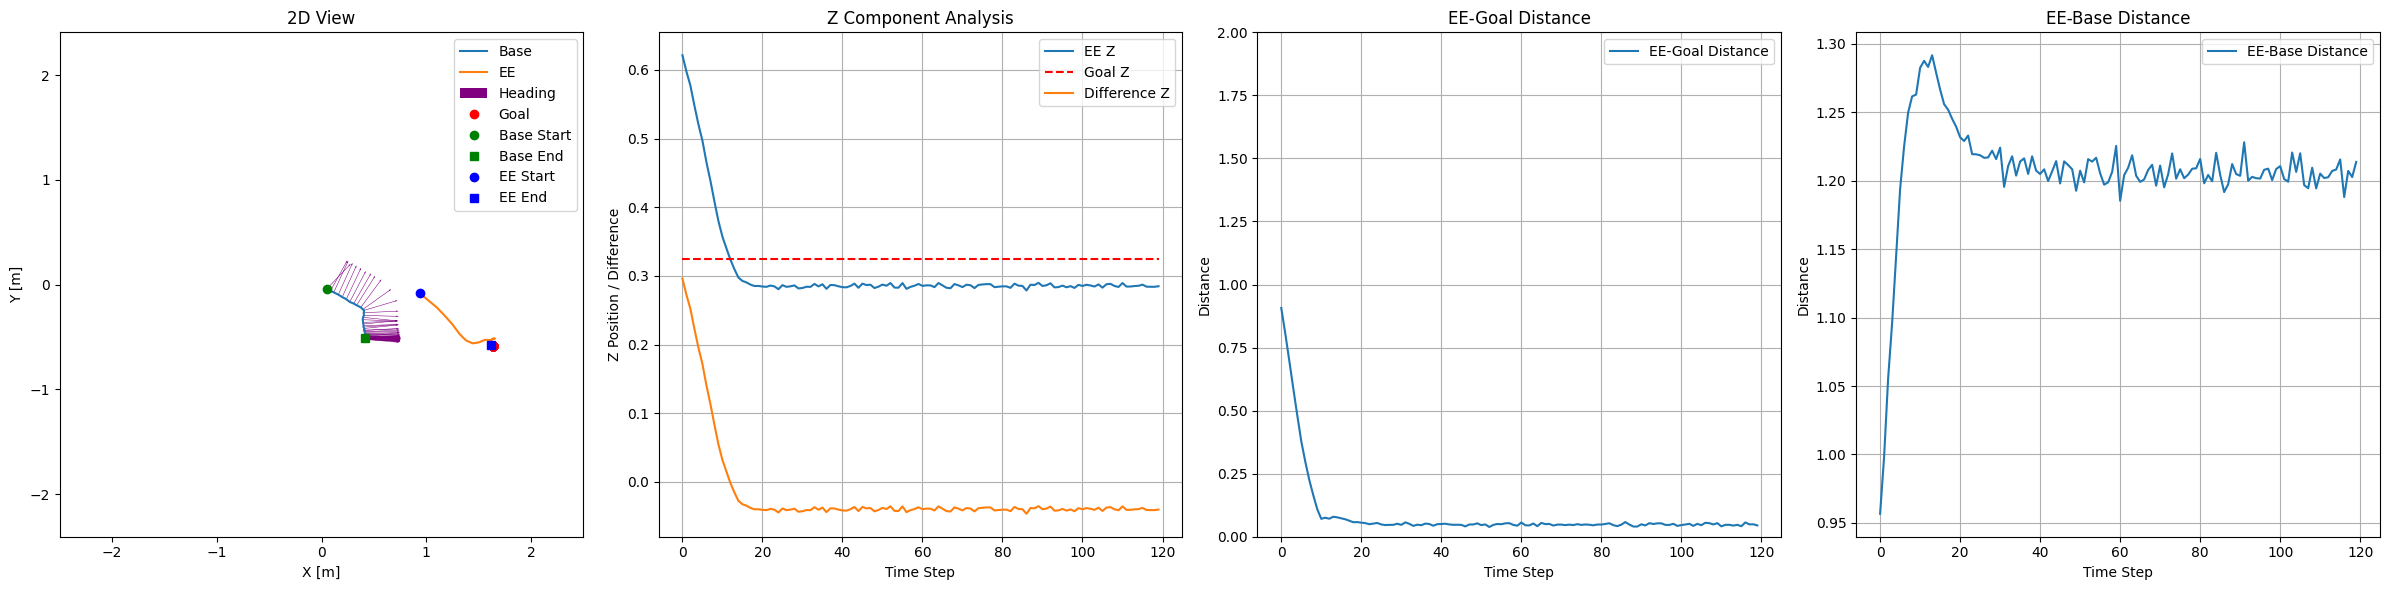

Trajectory 25


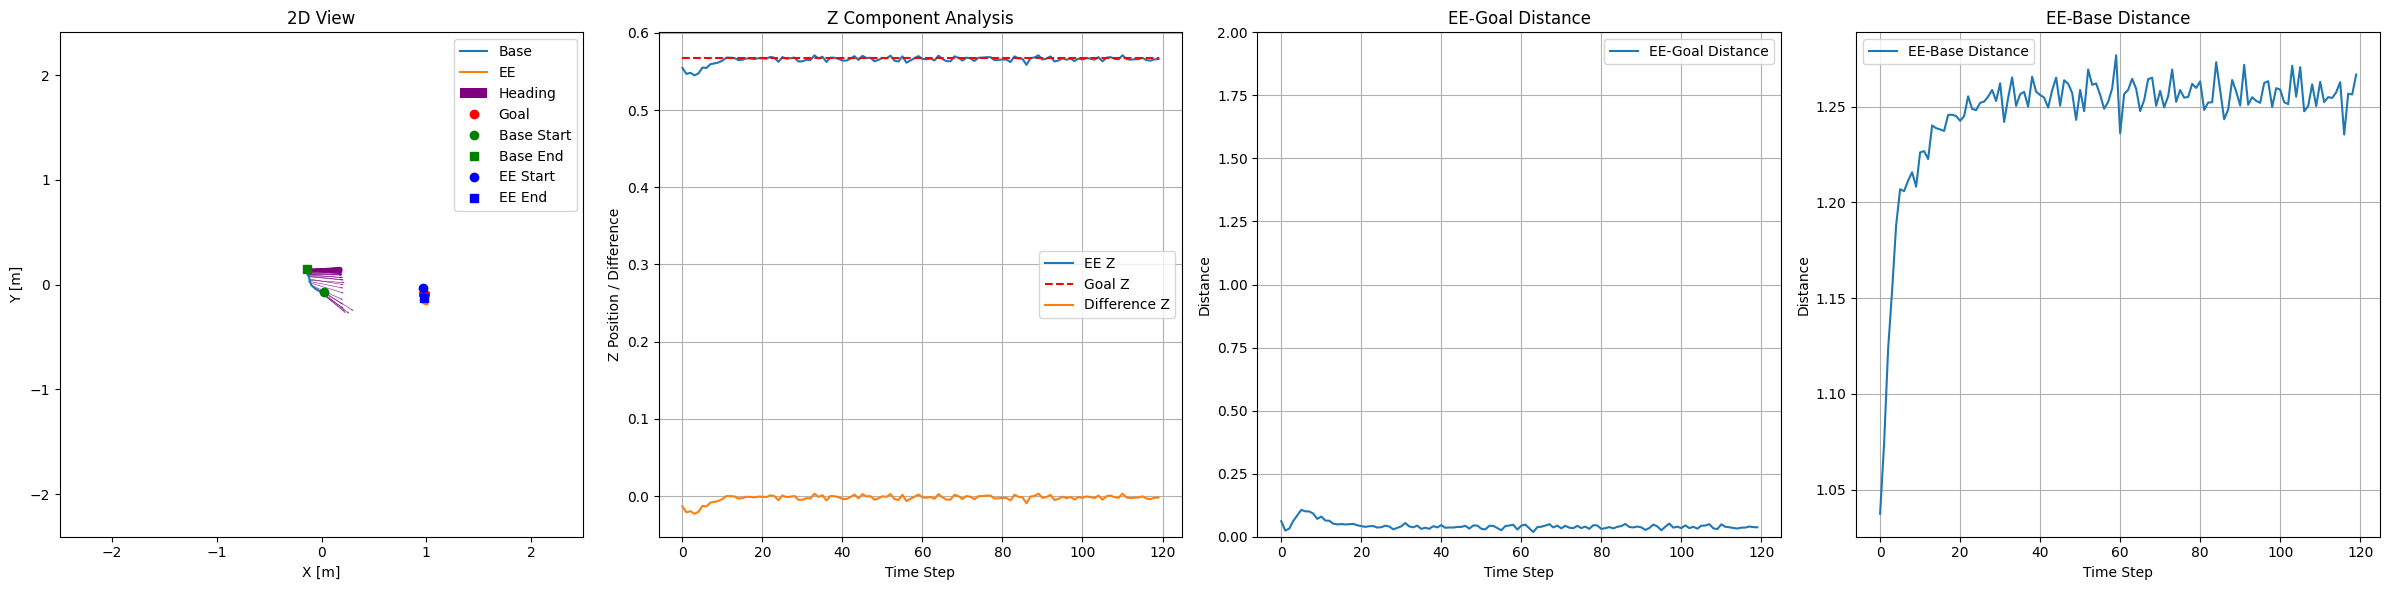

Trajectory 26


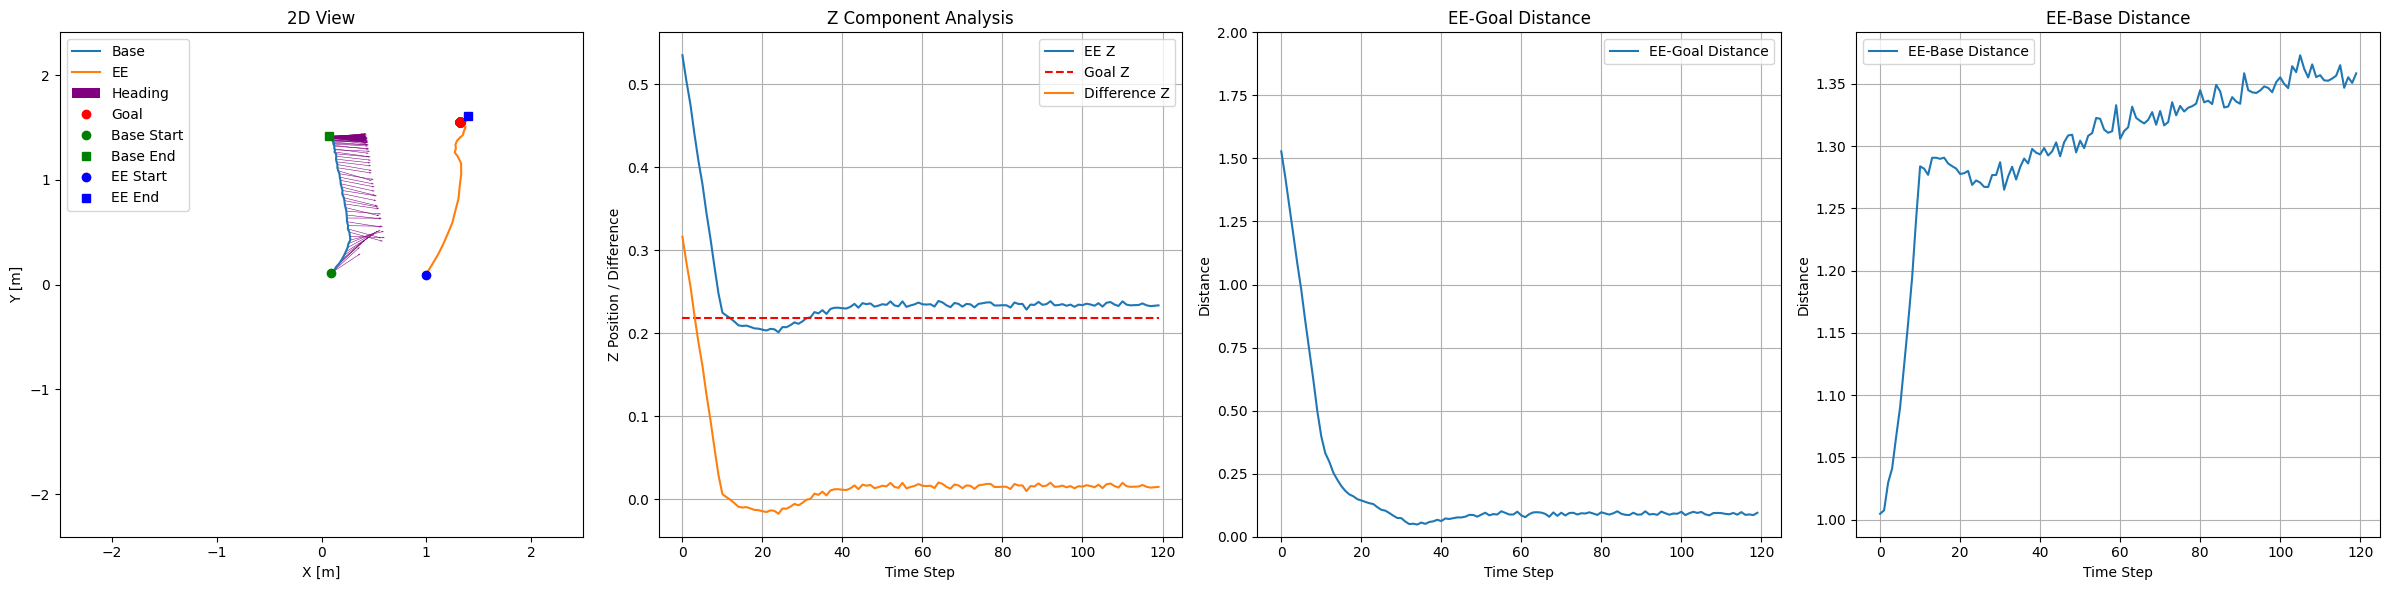

Trajectory 27


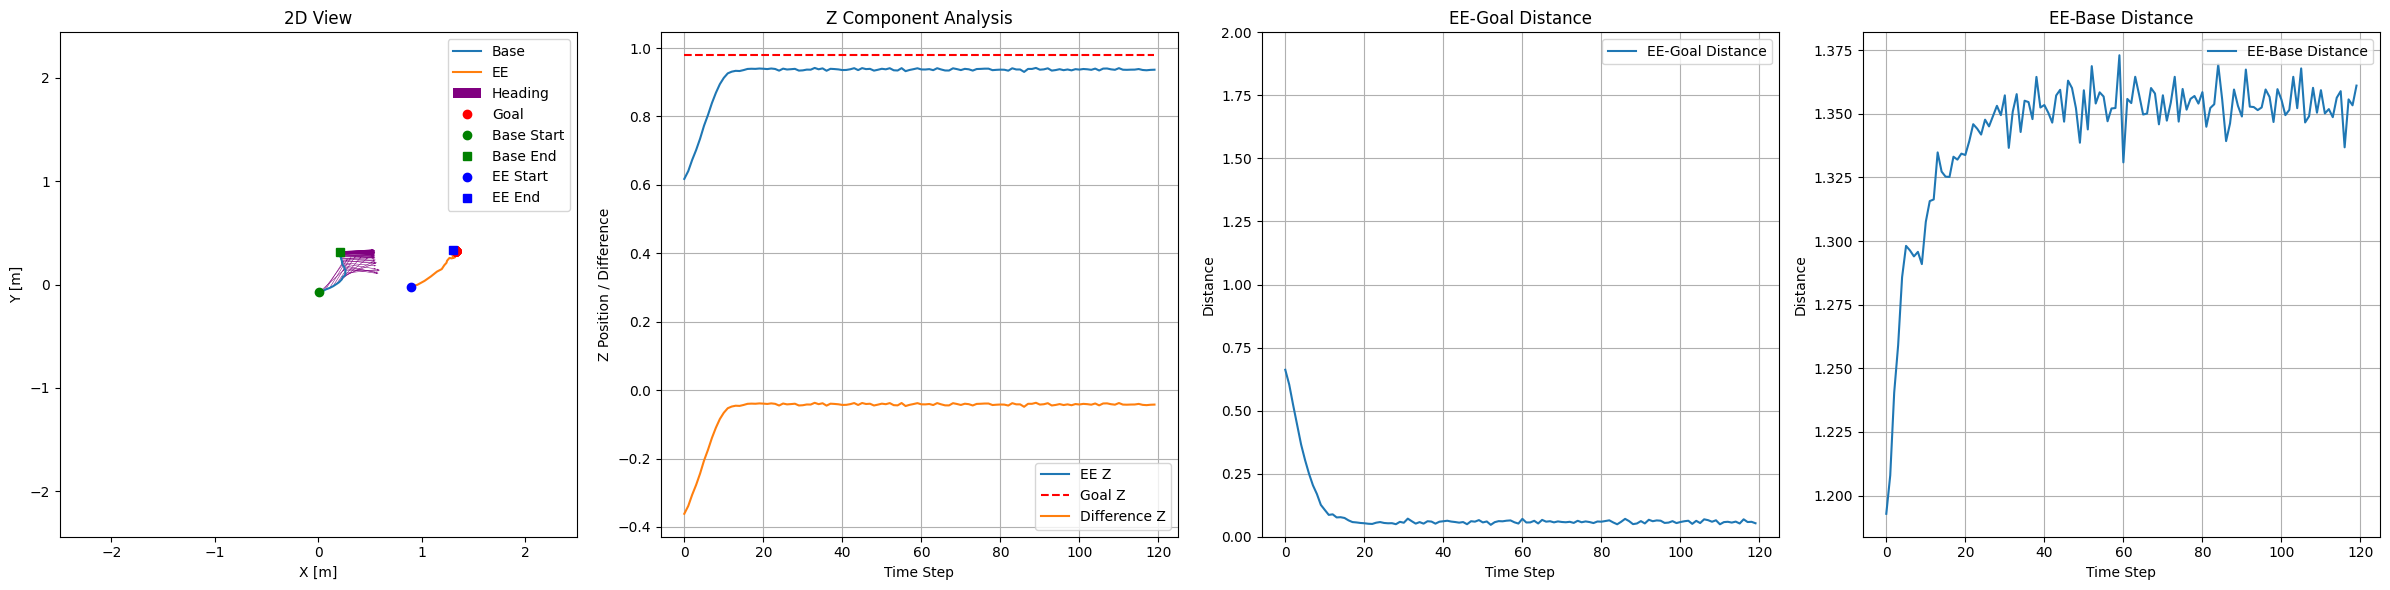

Trajectory 28


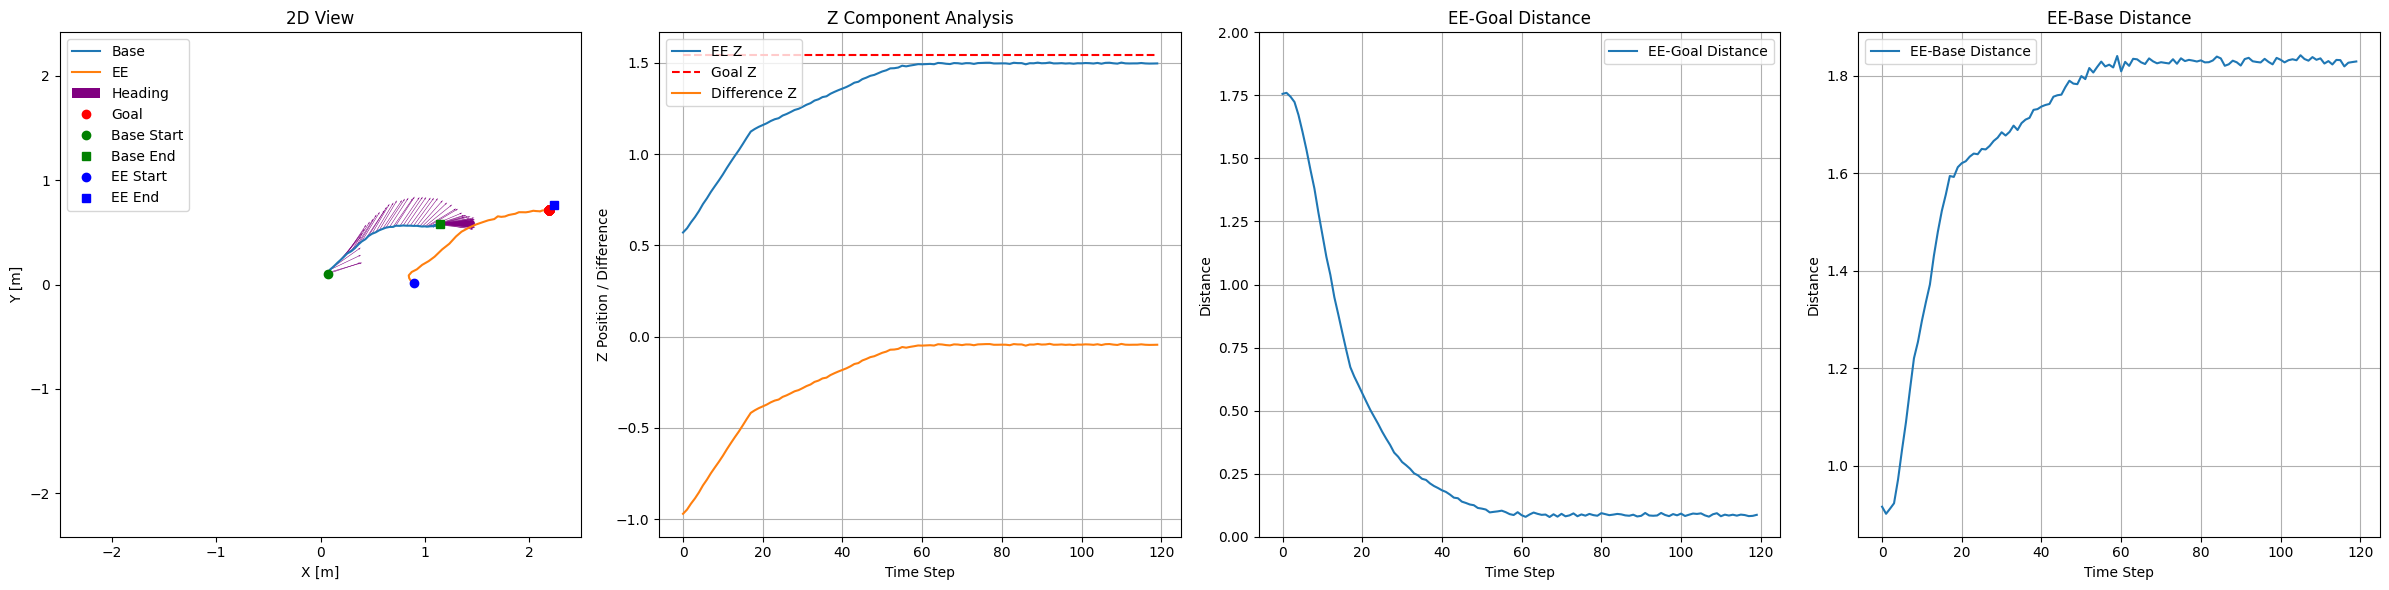

Trajectory 29


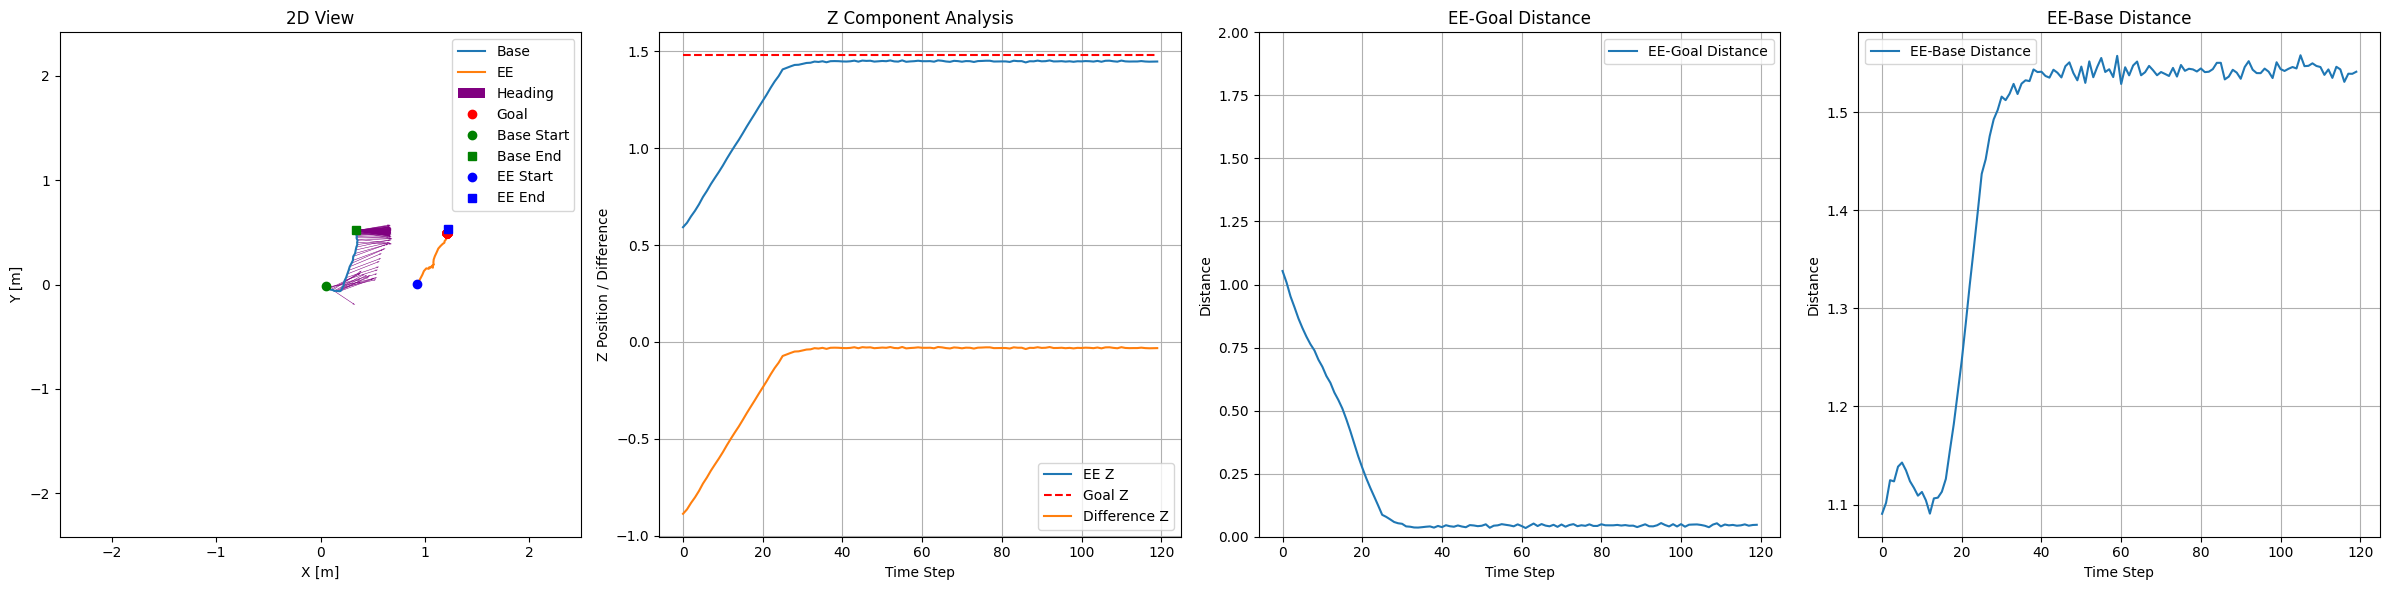

Trajectory 30


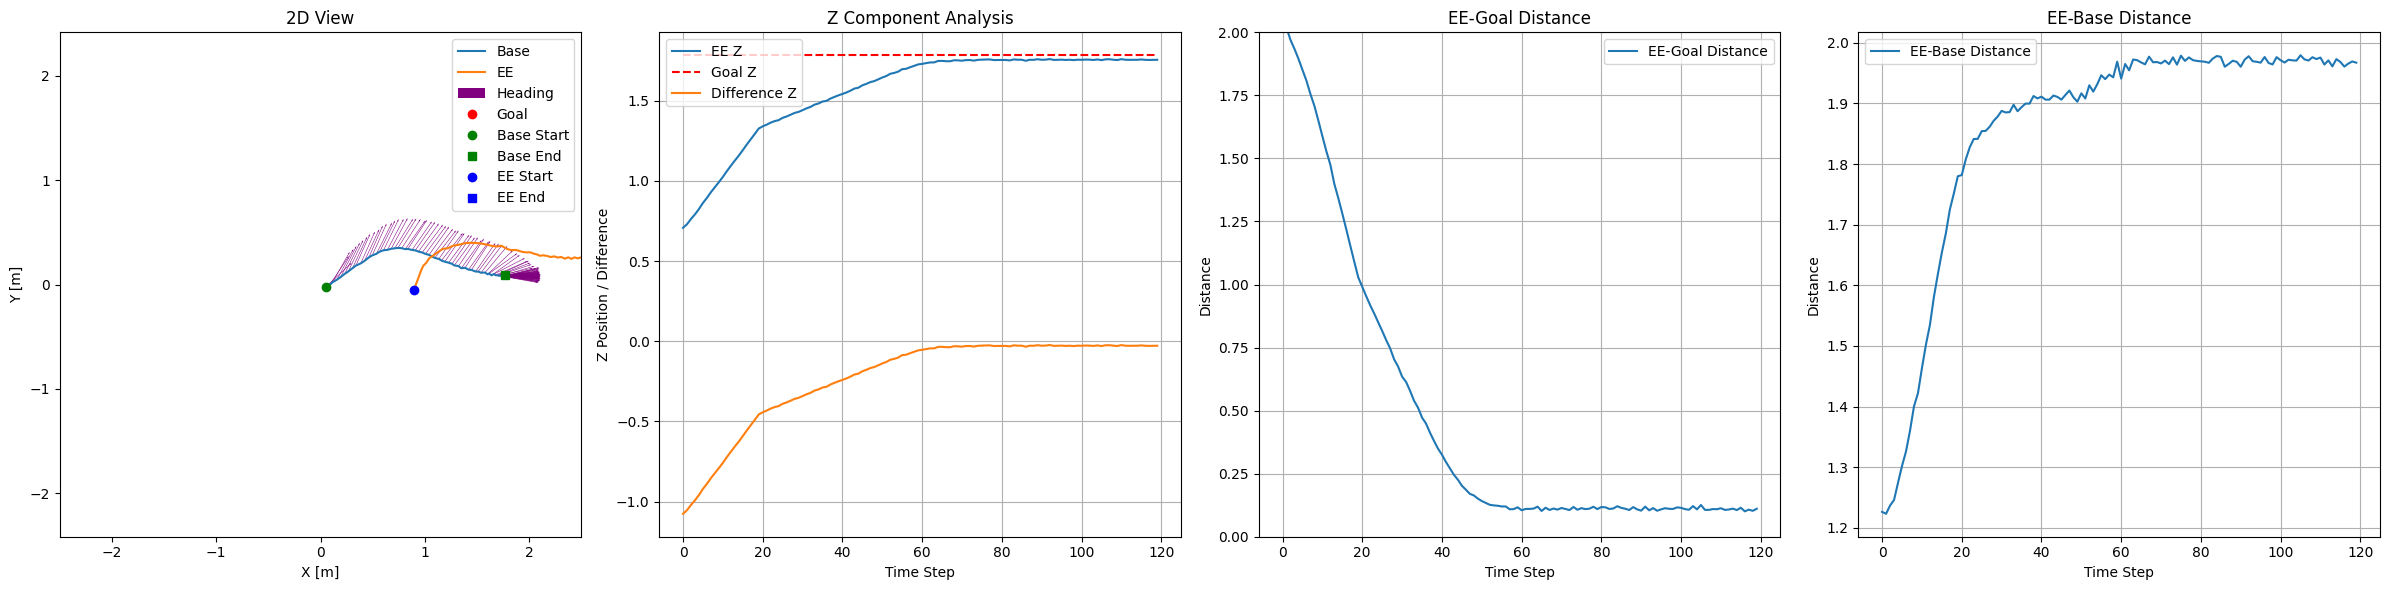

Trajectory 31


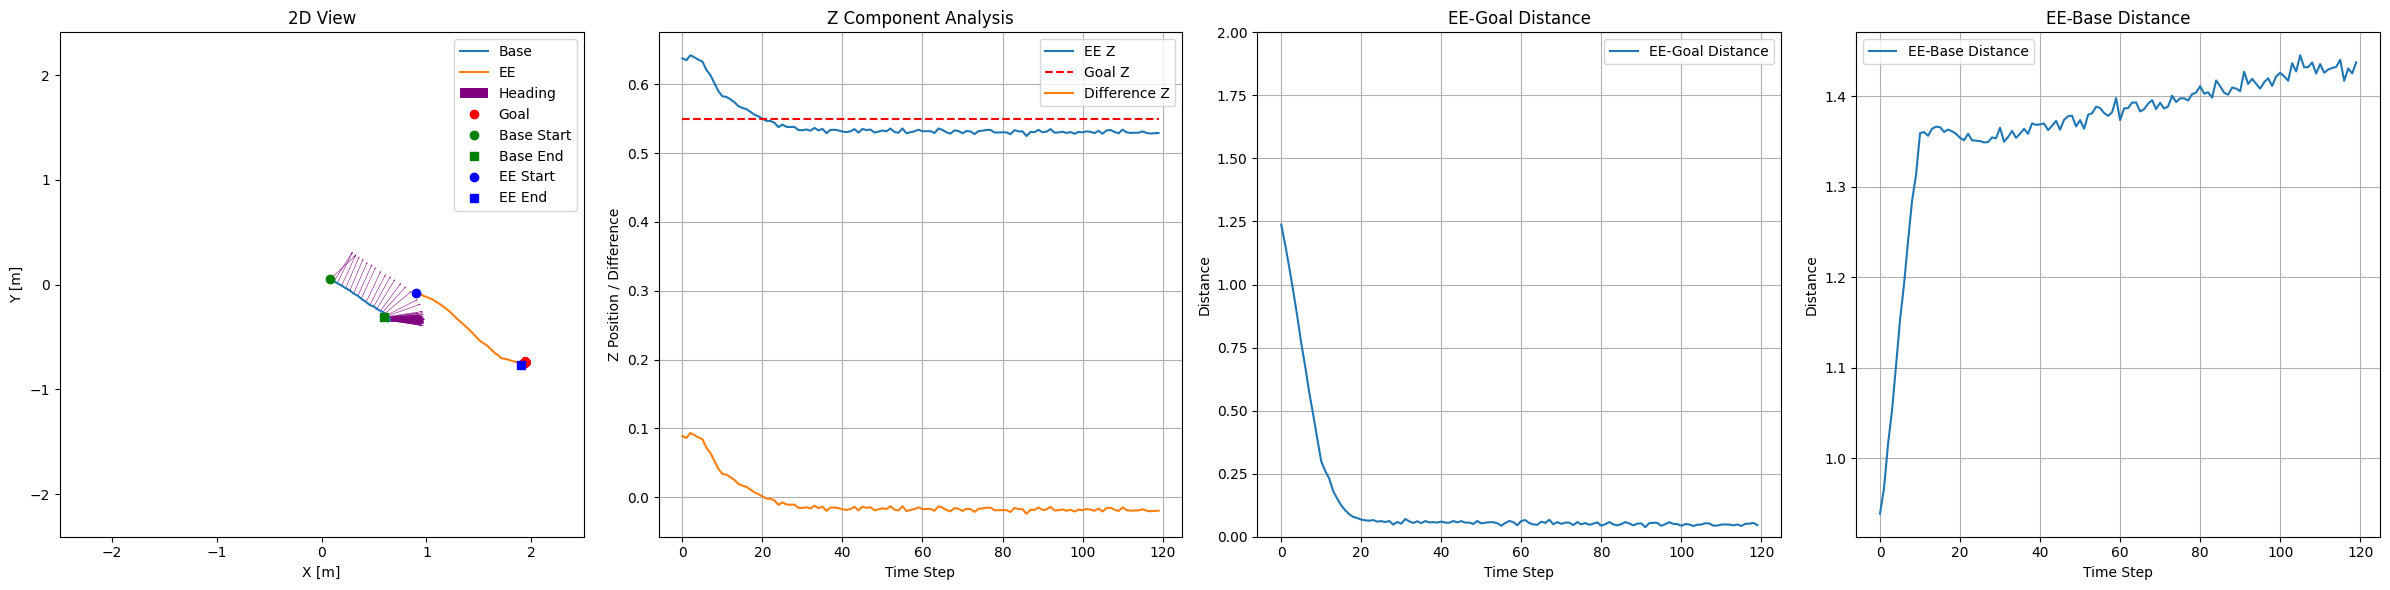

Trajectory 32


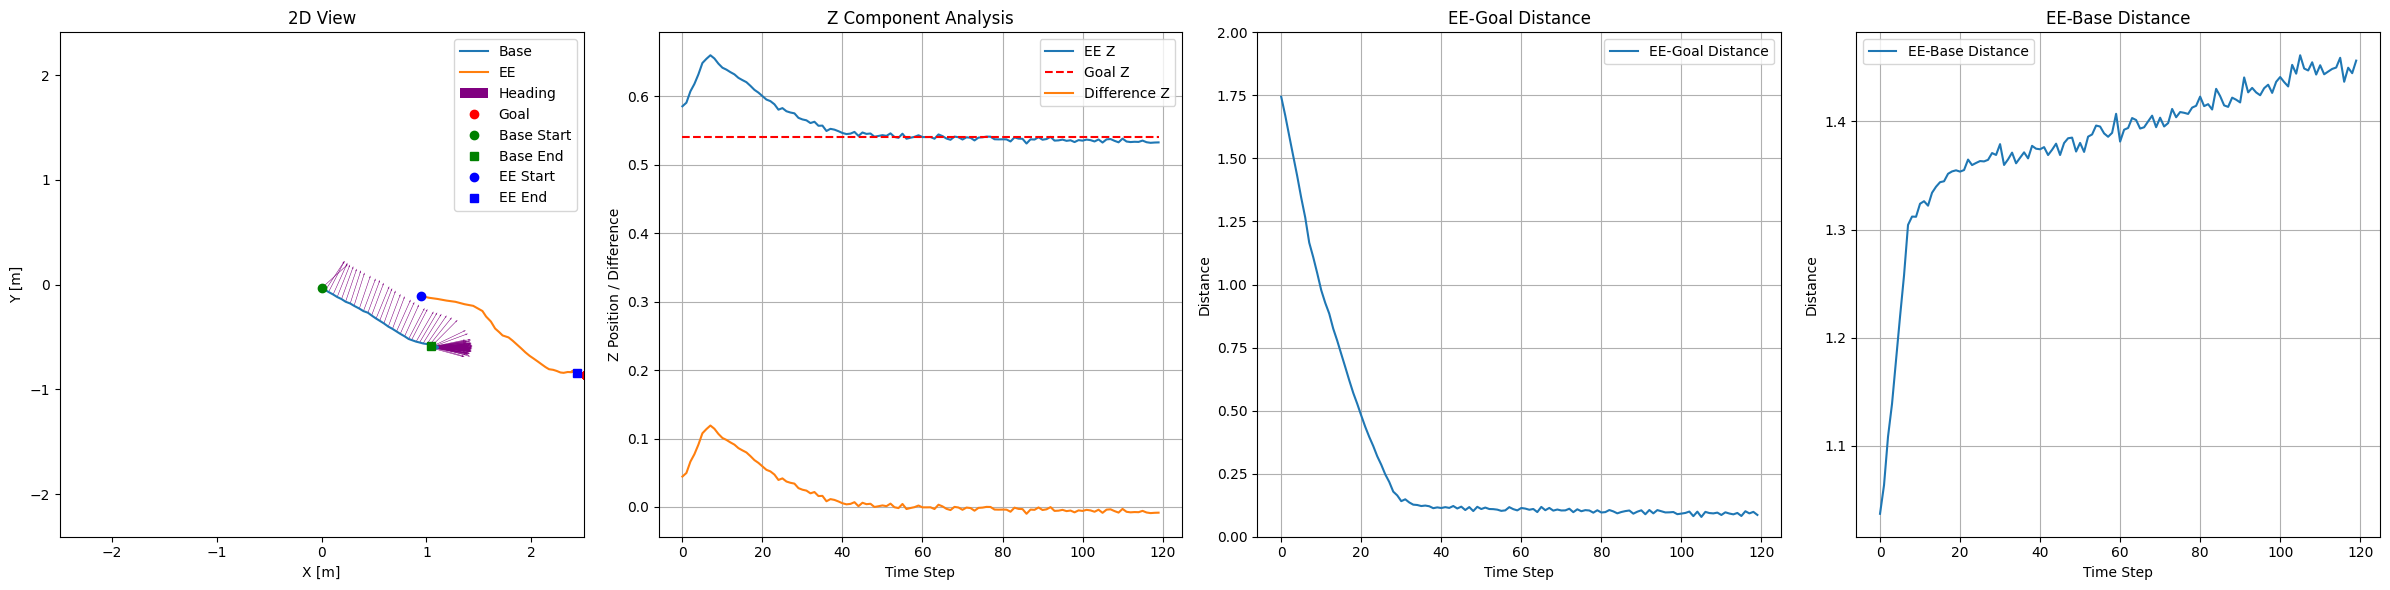

Trajectory 33


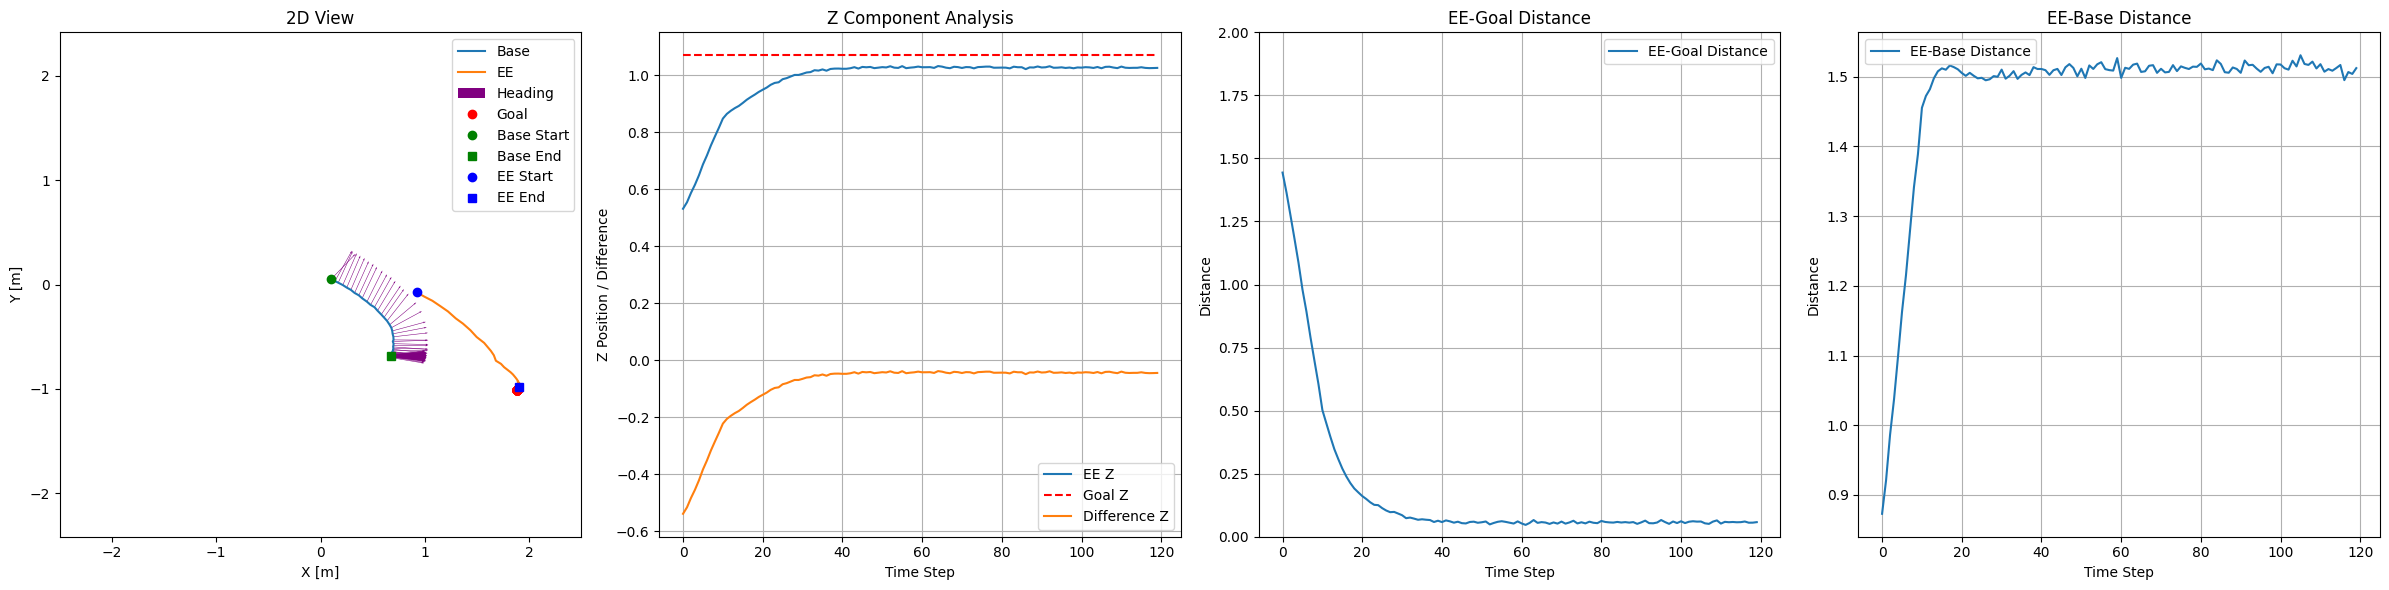

Trajectory 34


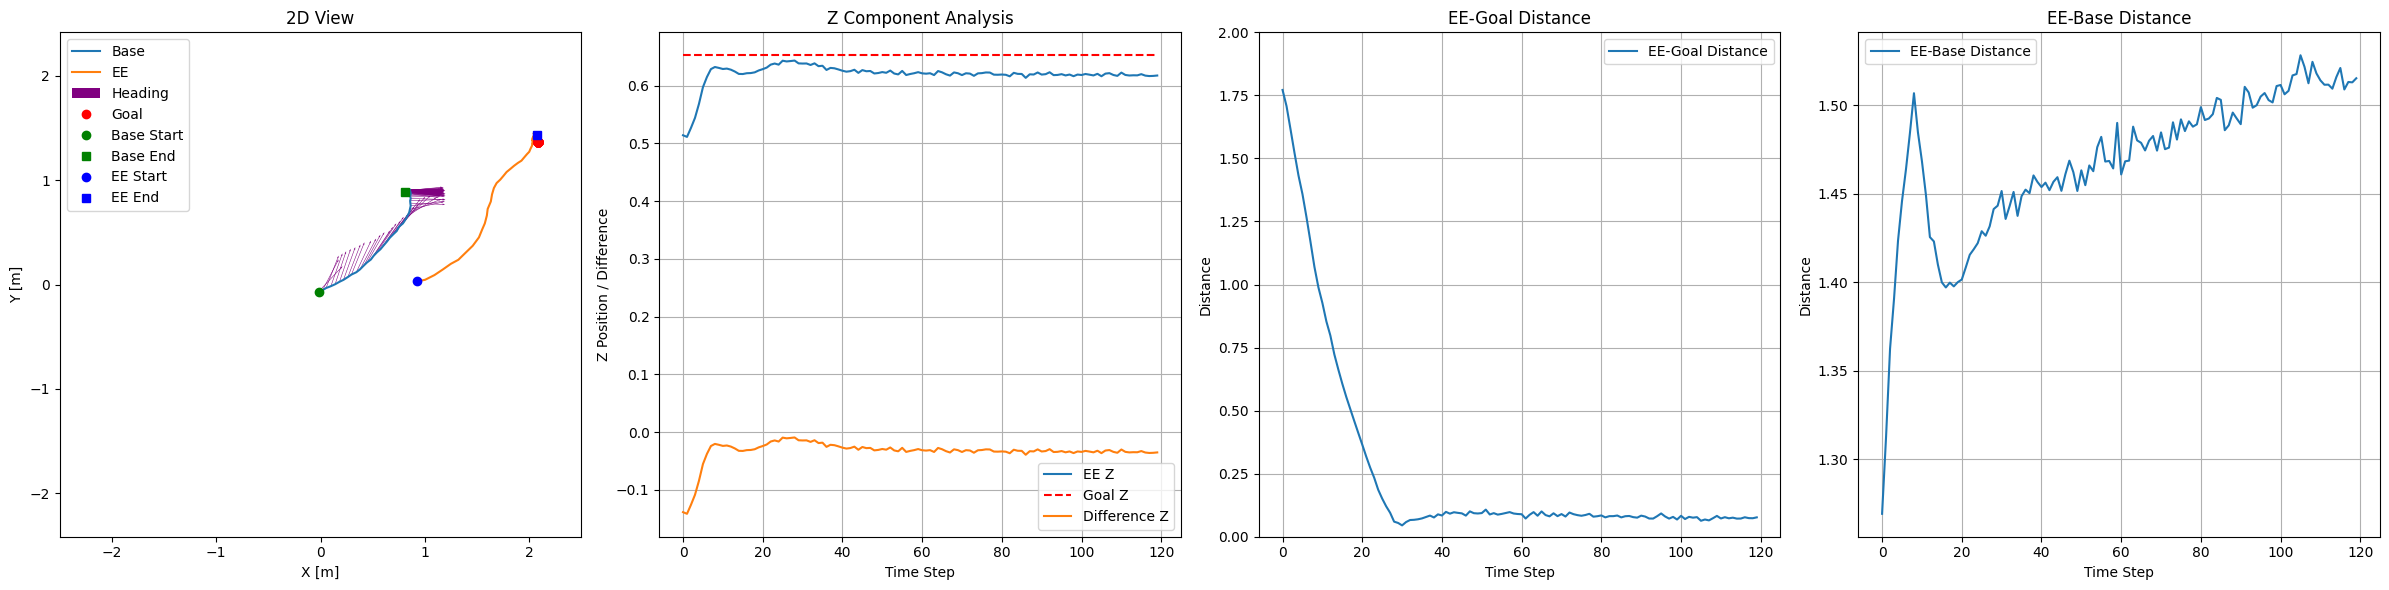

Trajectory 35


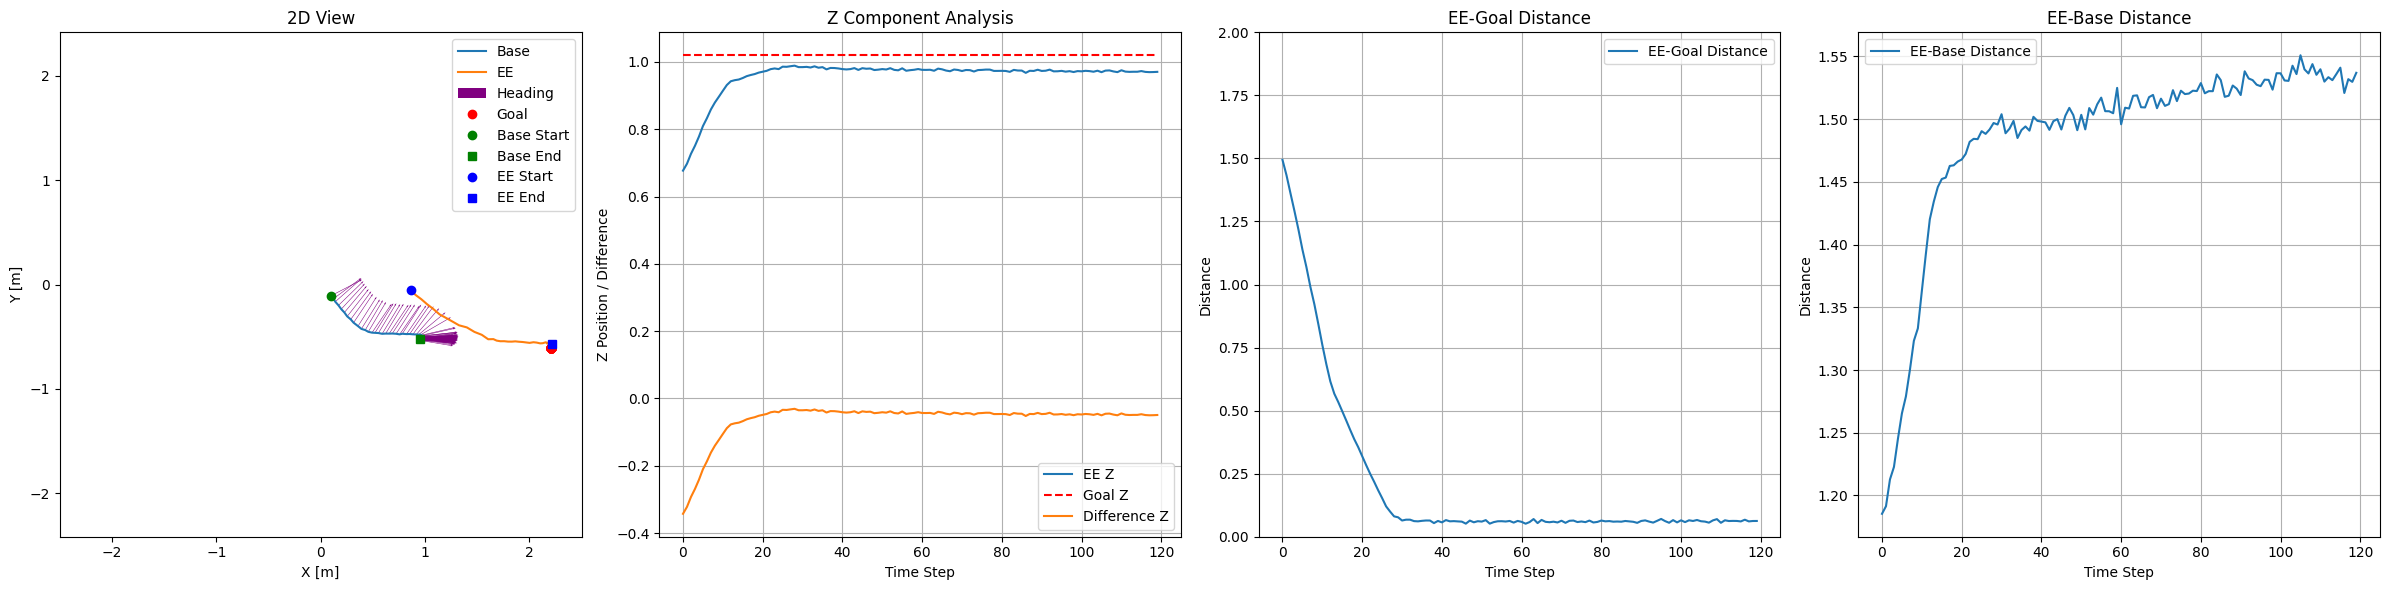

Trajectory 36


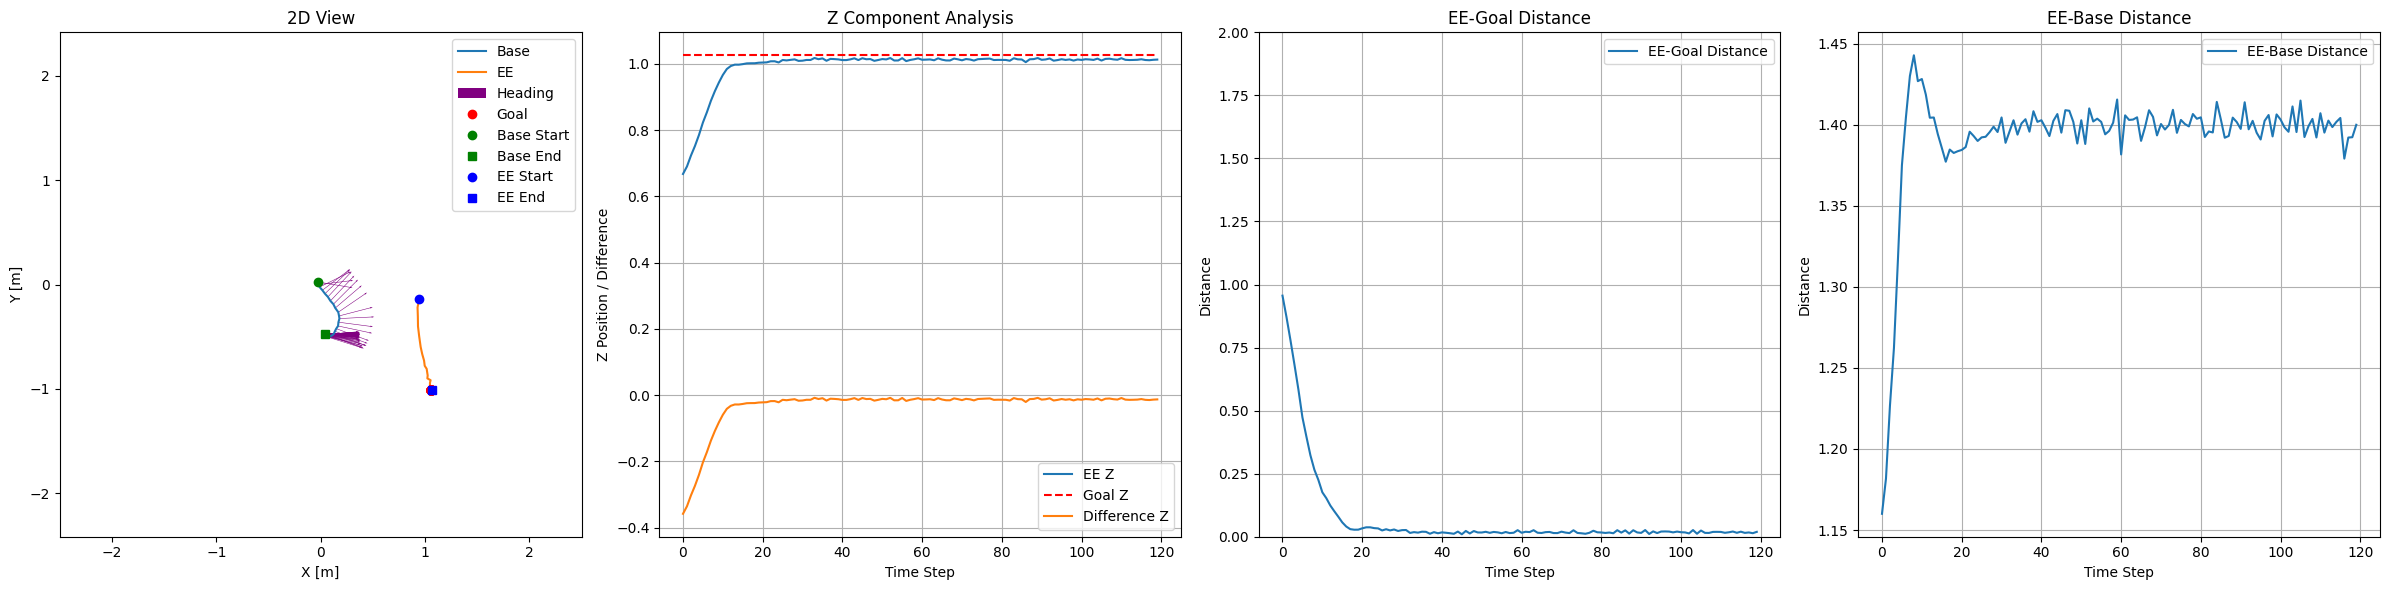

Trajectory 37


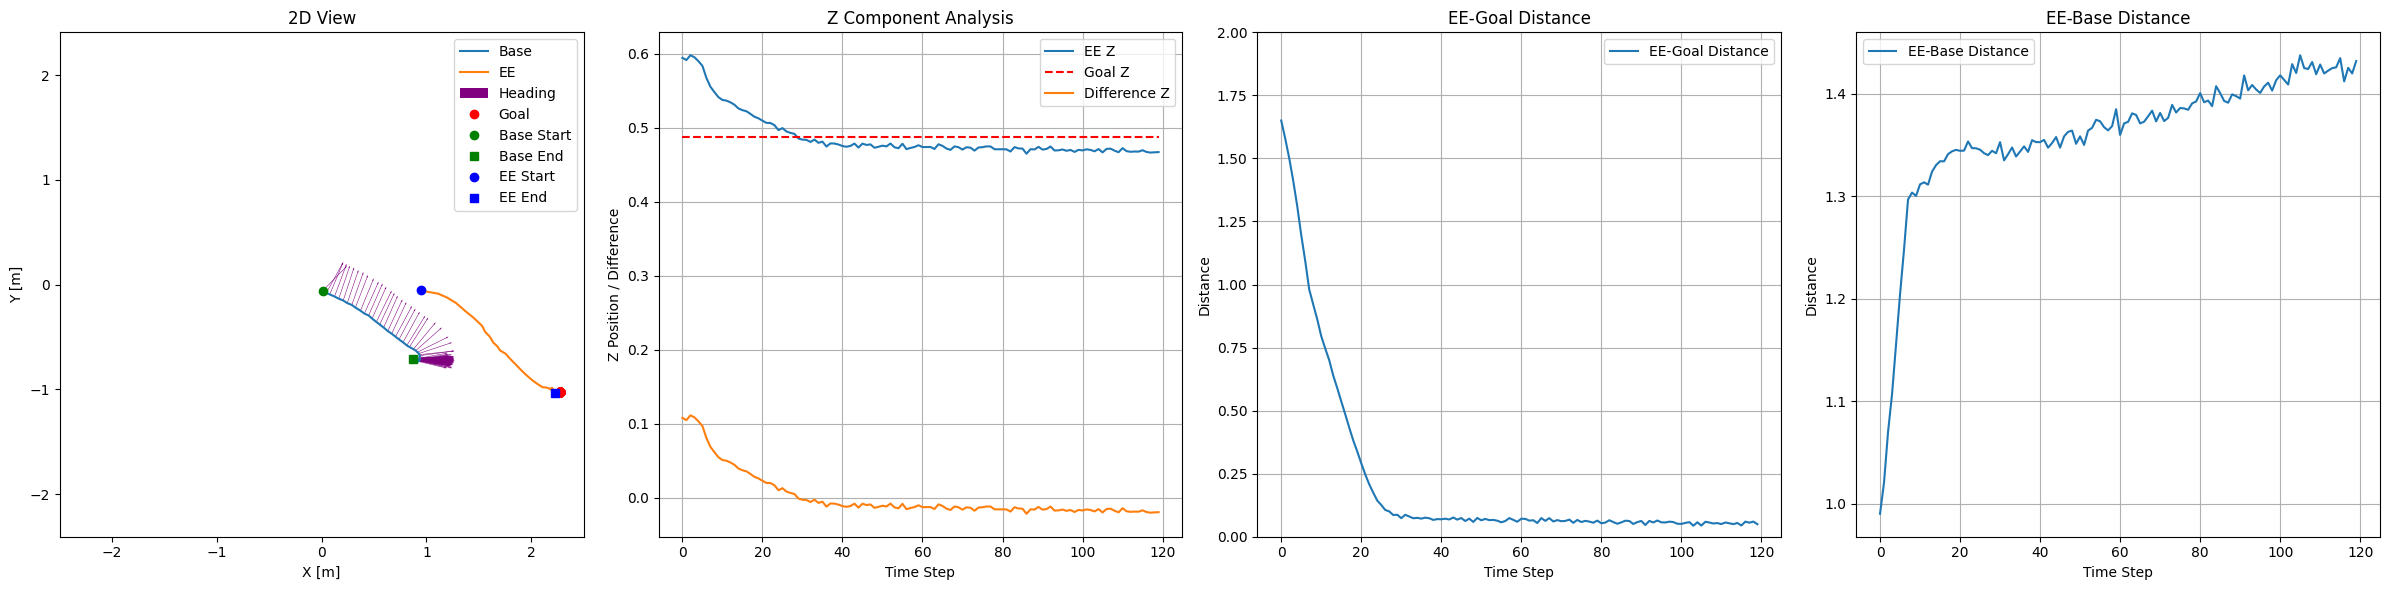

Trajectory 38


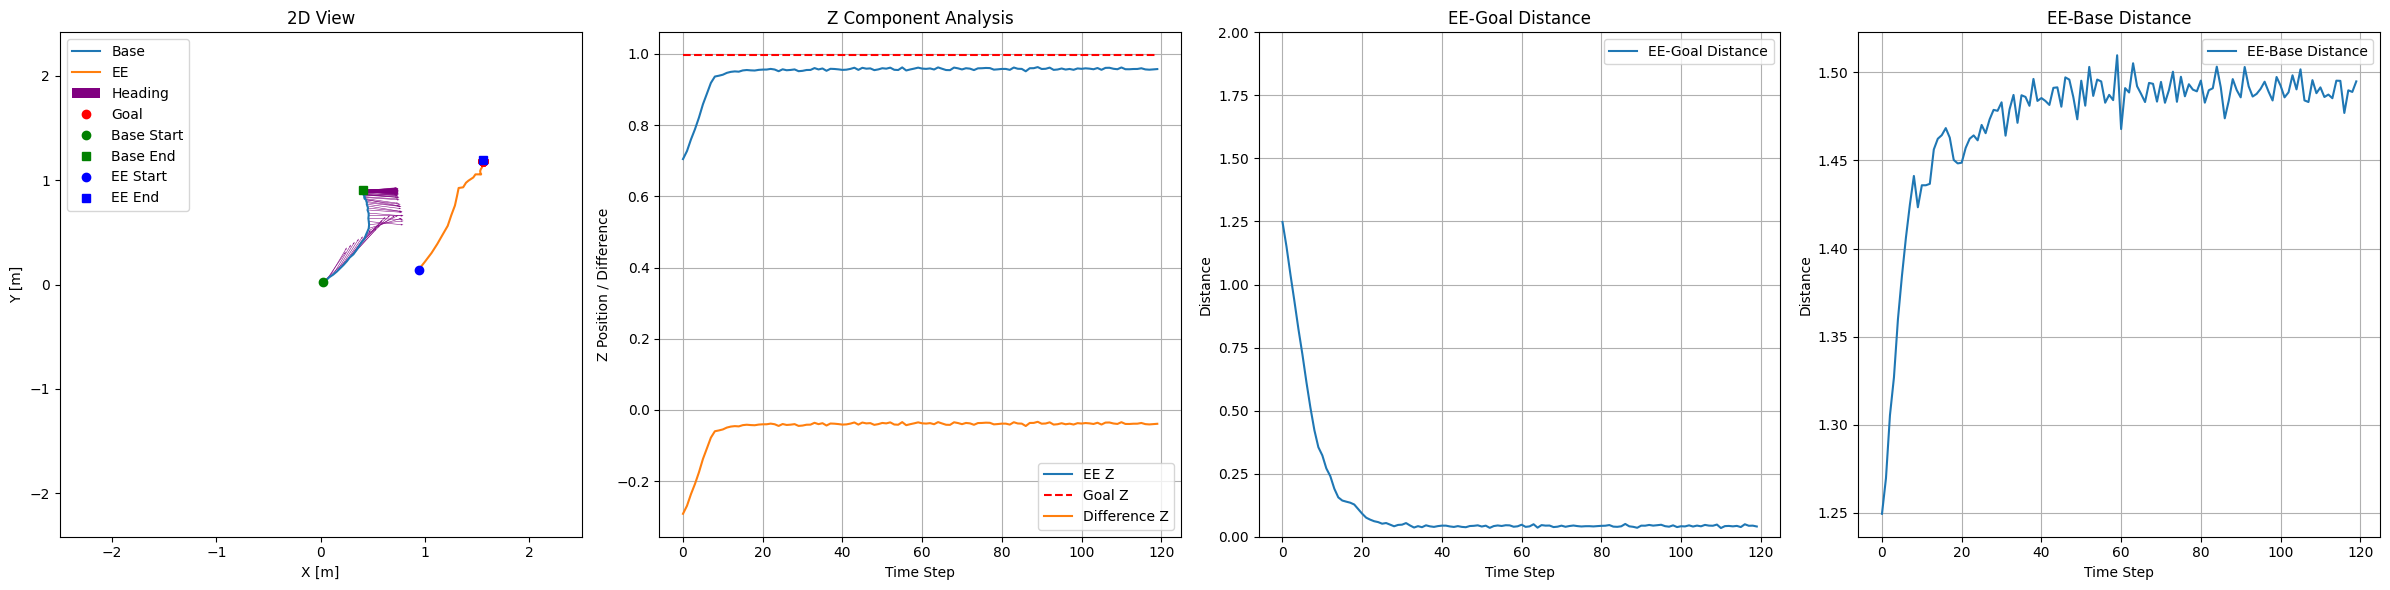

Trajectory 39


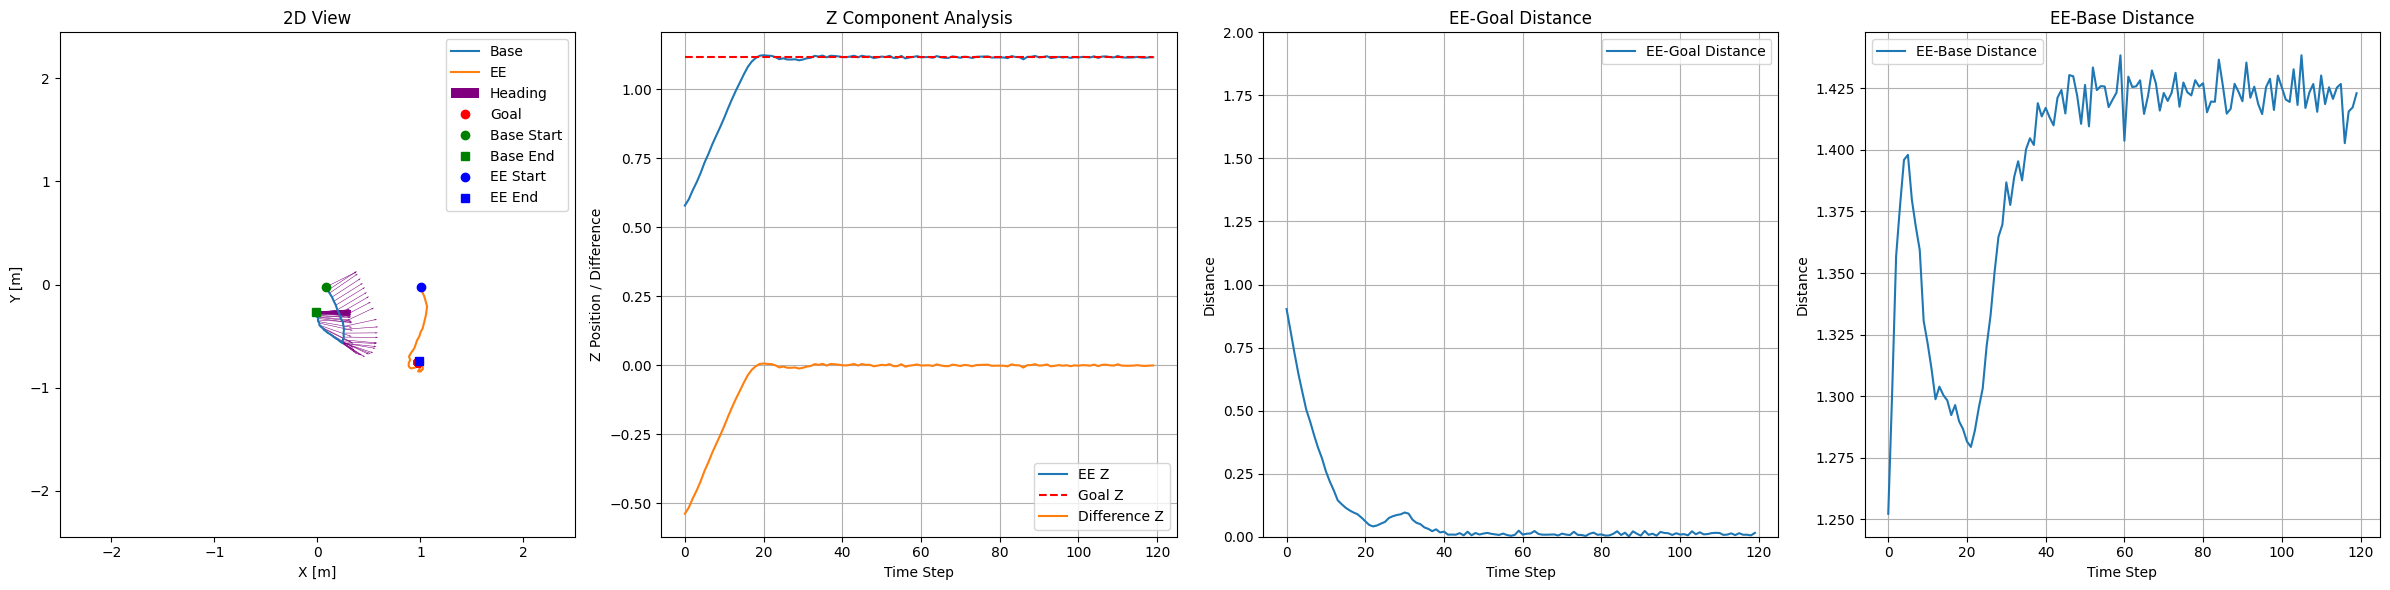

Trajectory 40


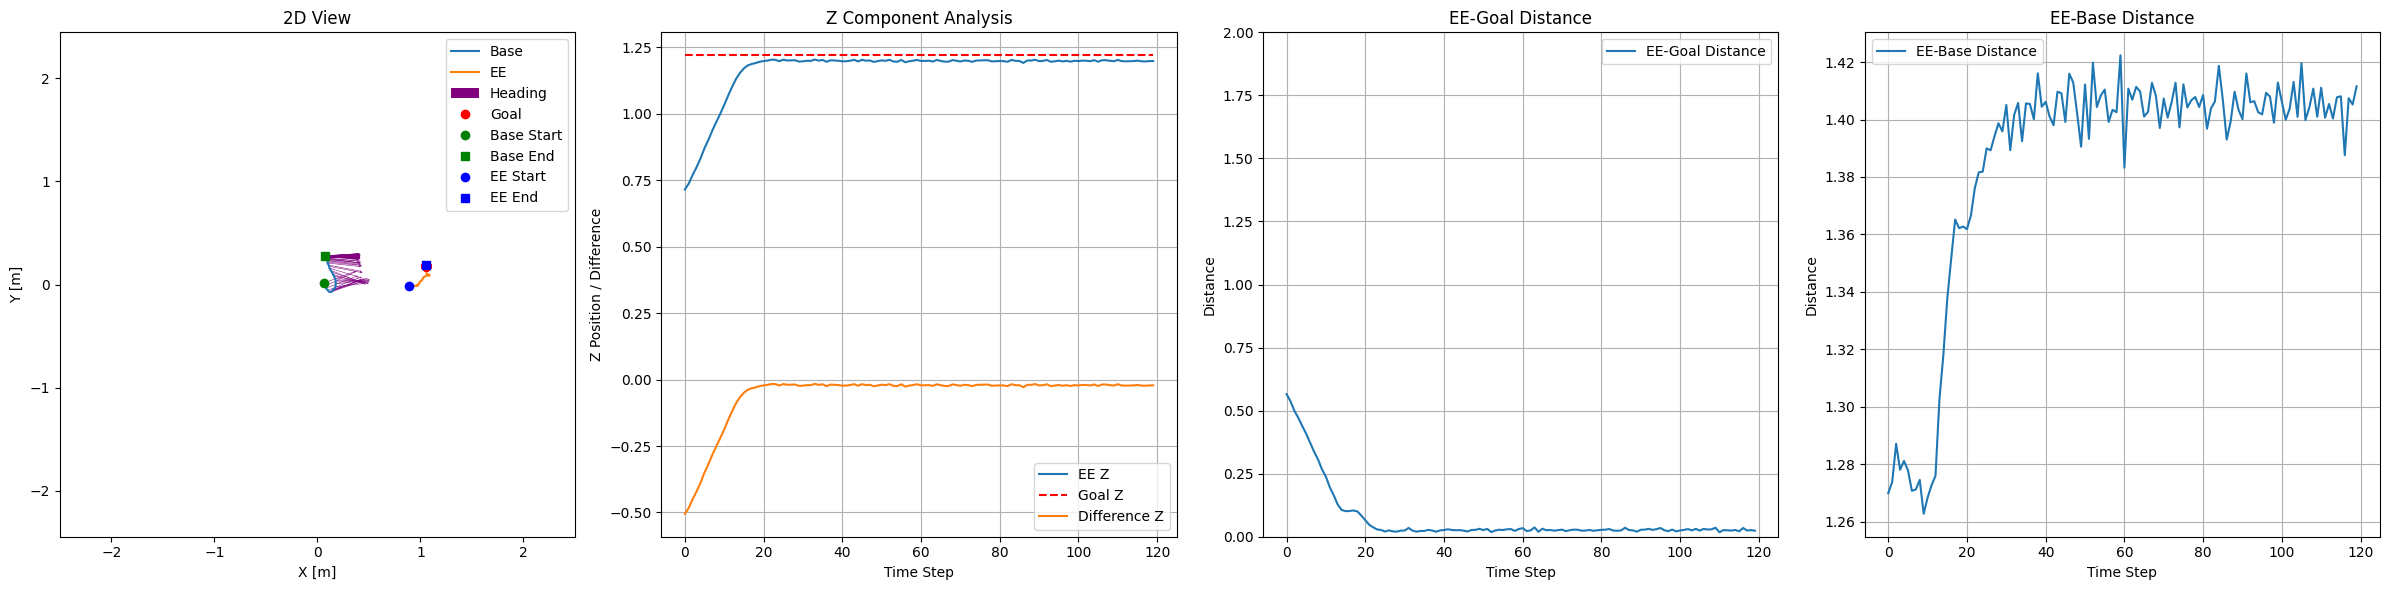

Trajectory 41


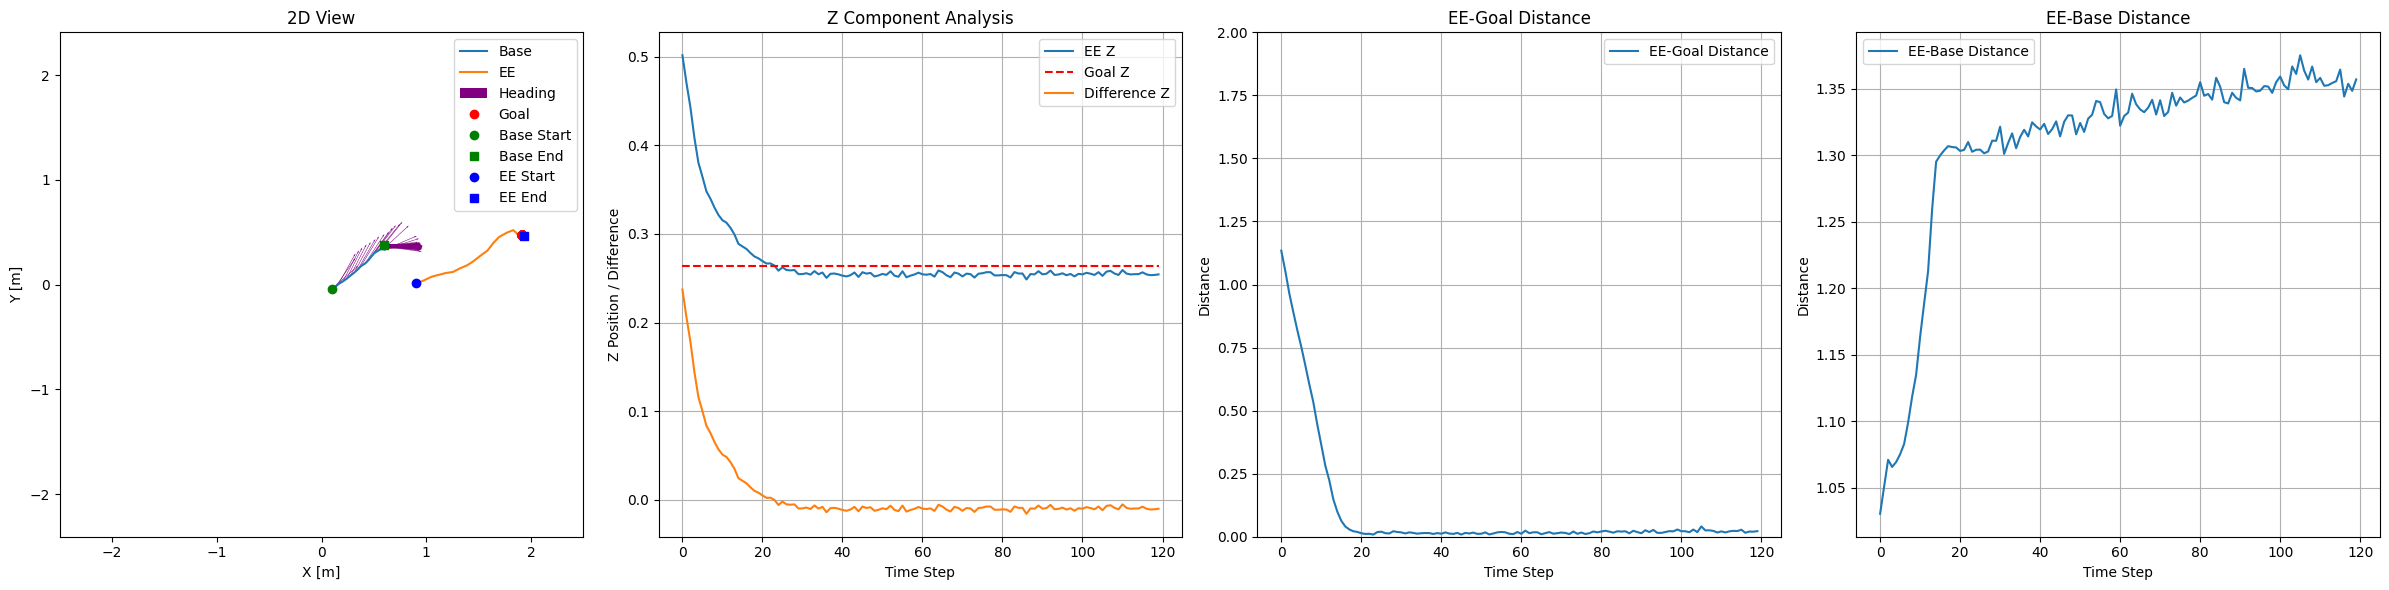

Trajectory 42


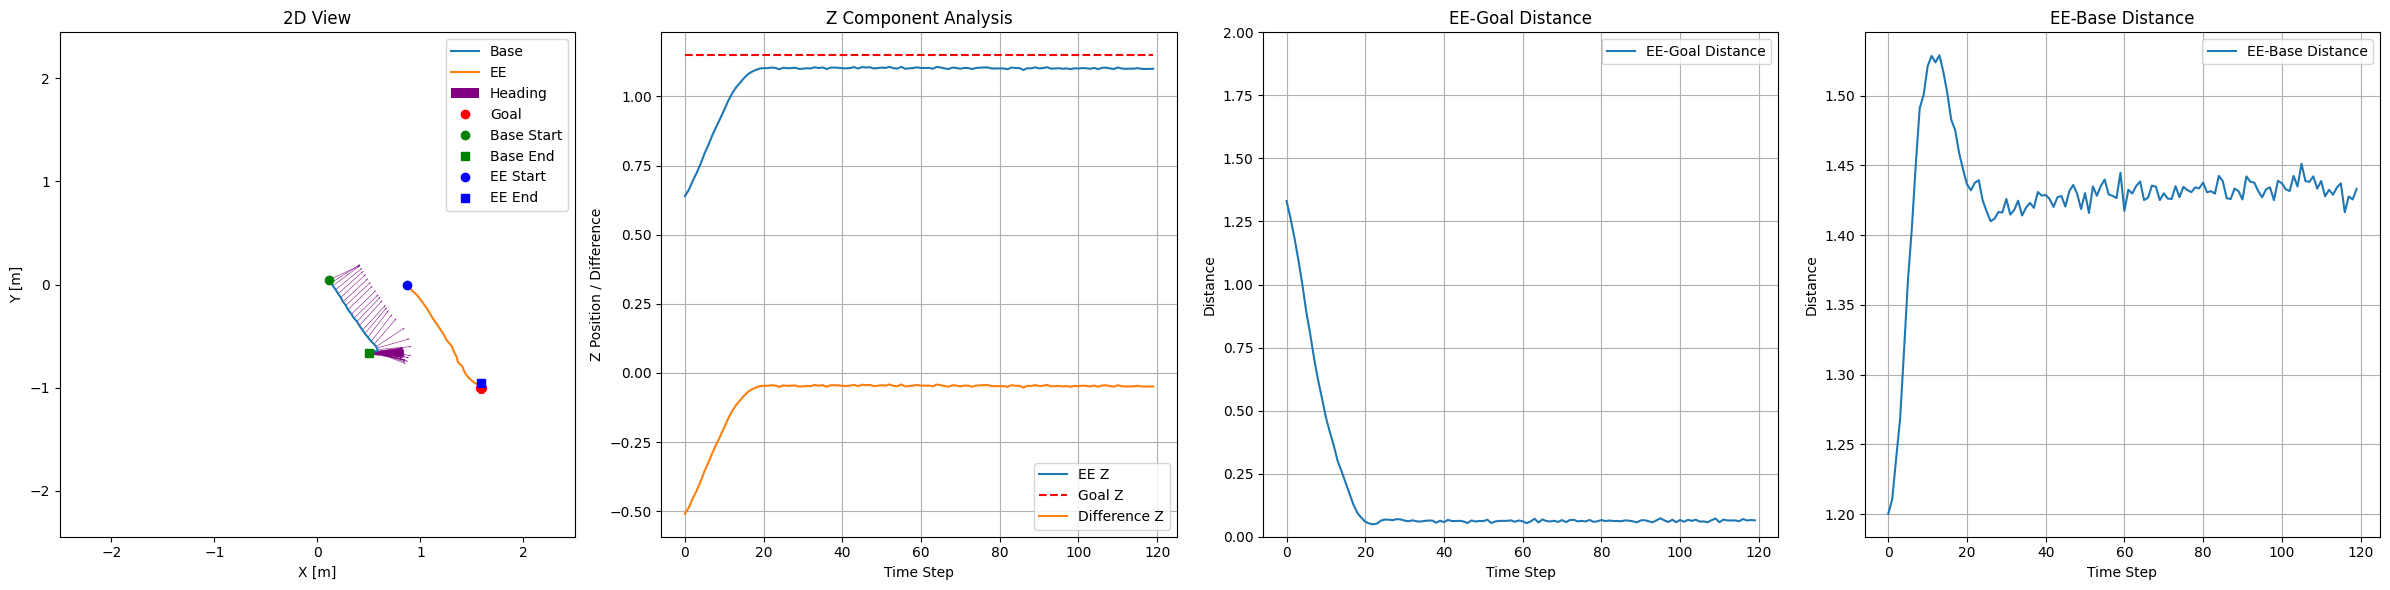

Trajectory 43


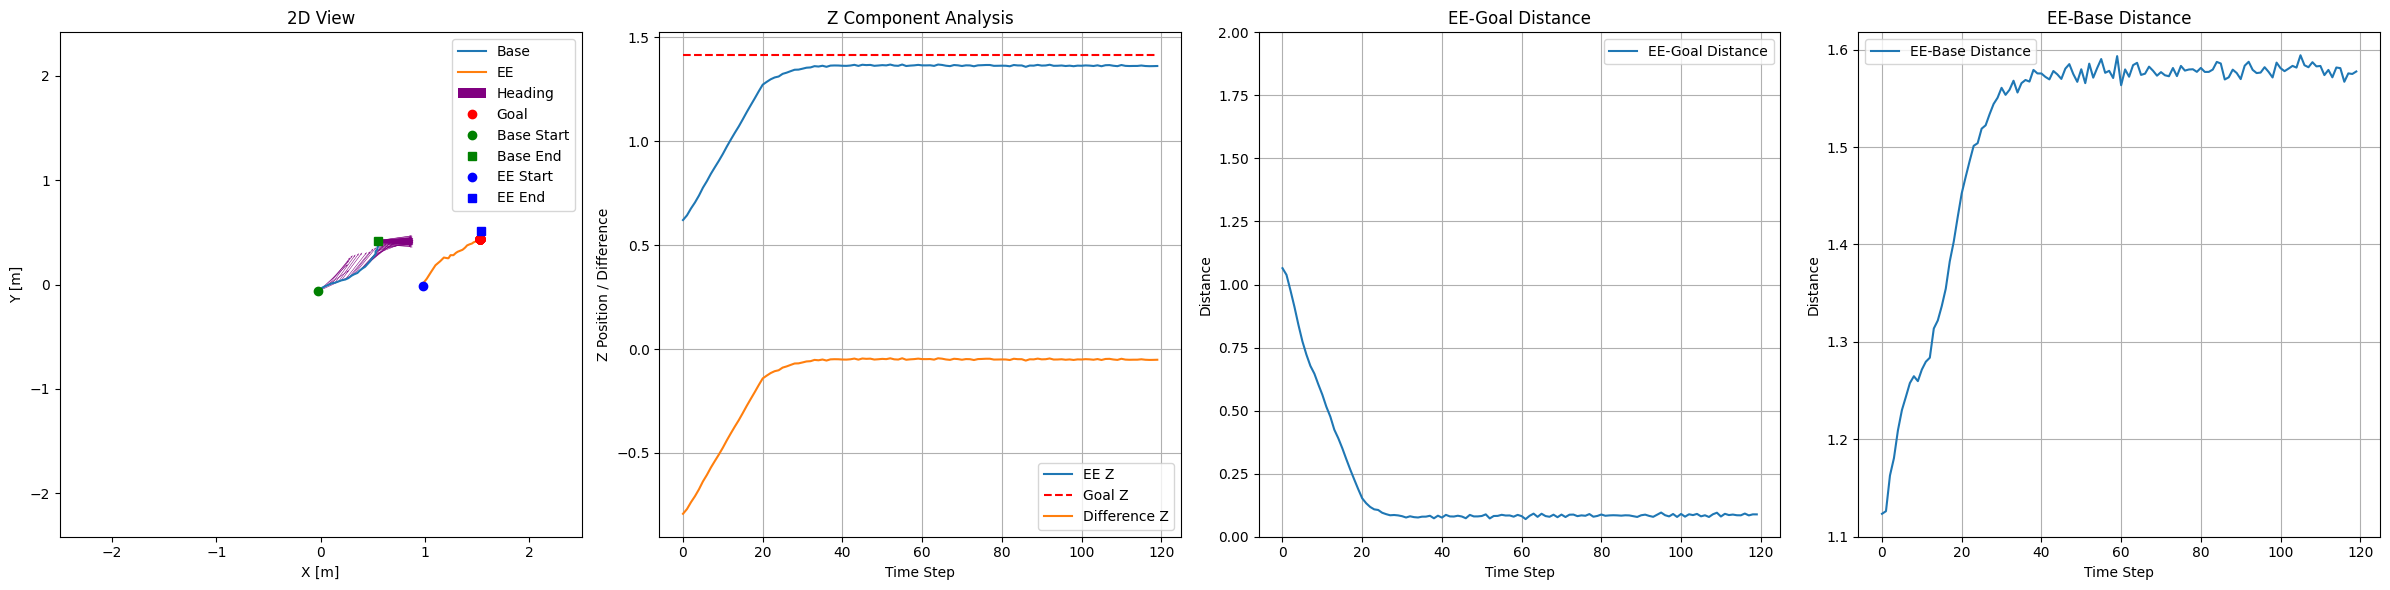

Trajectory 44


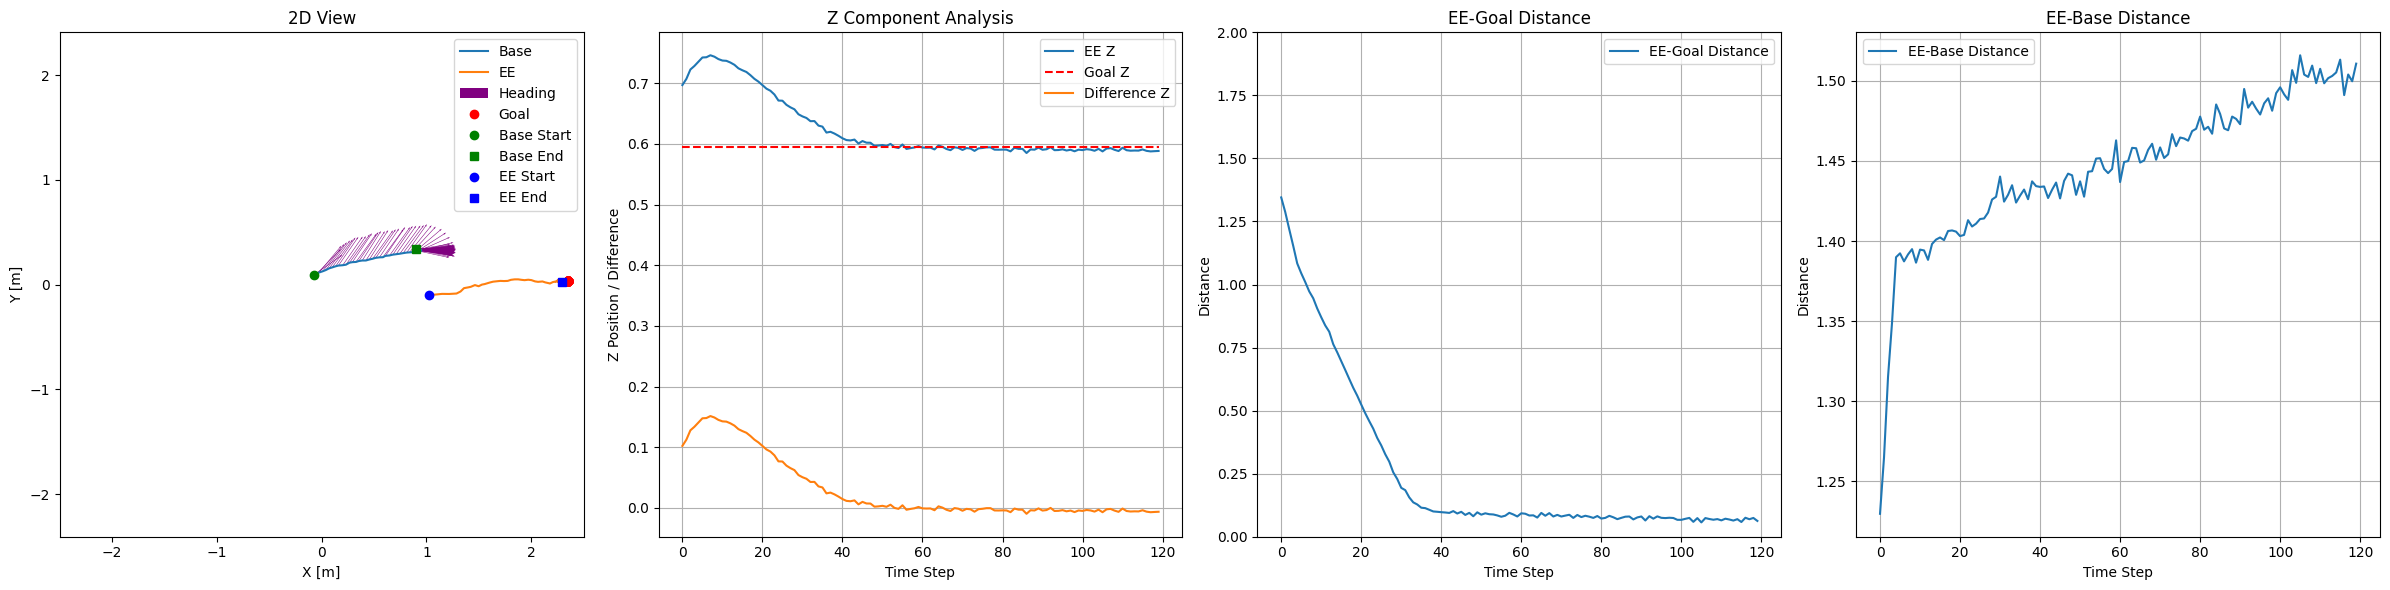

Trajectory 45


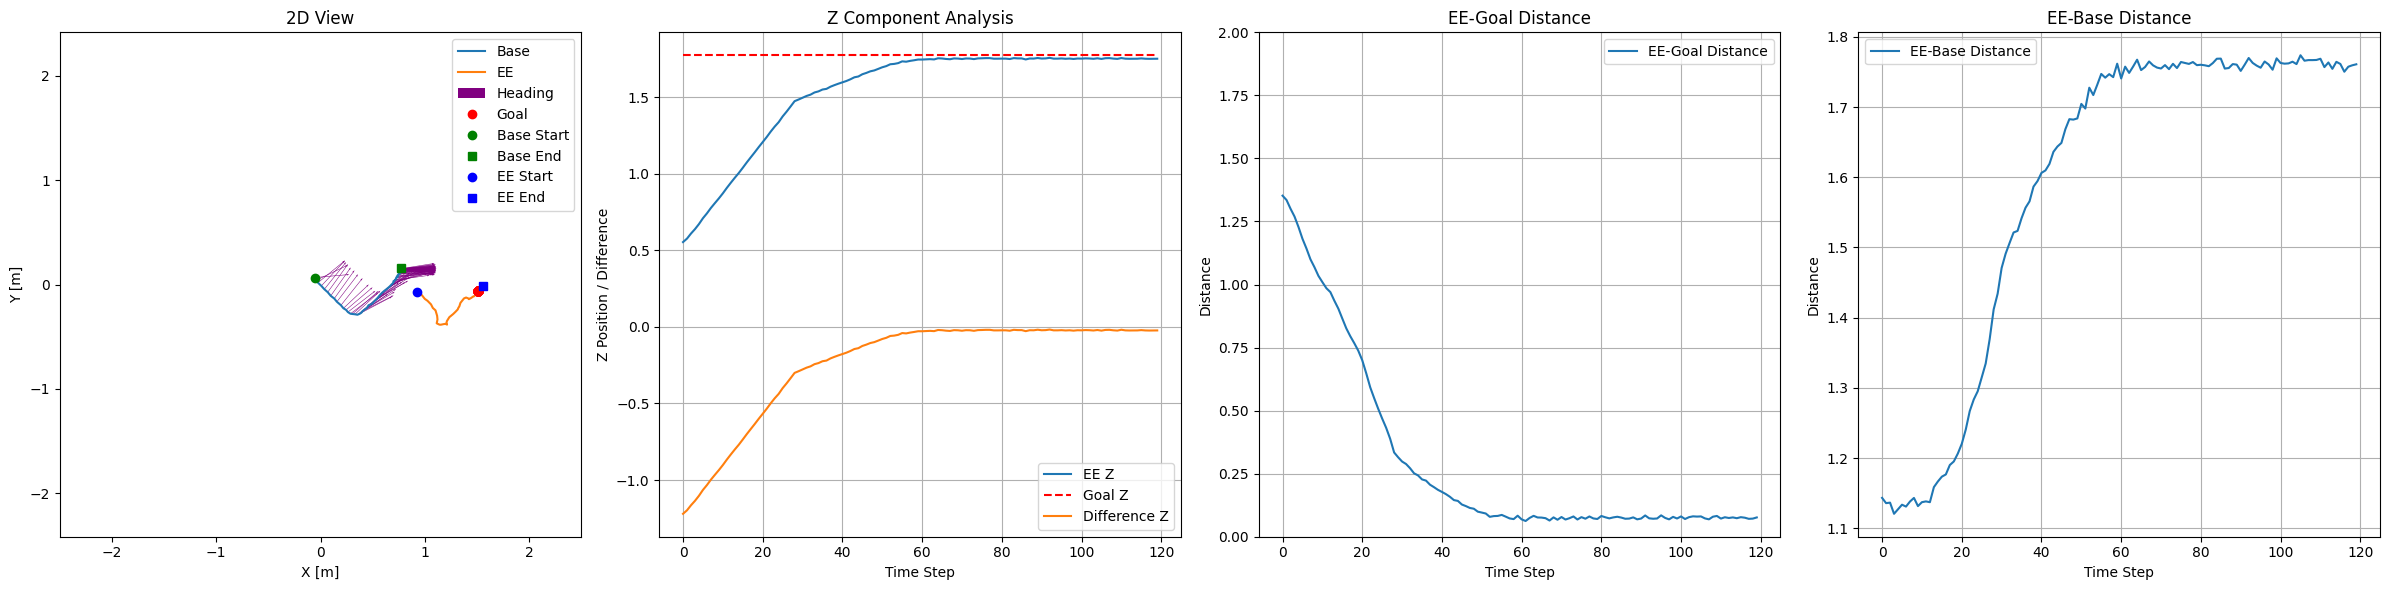

Trajectory 46


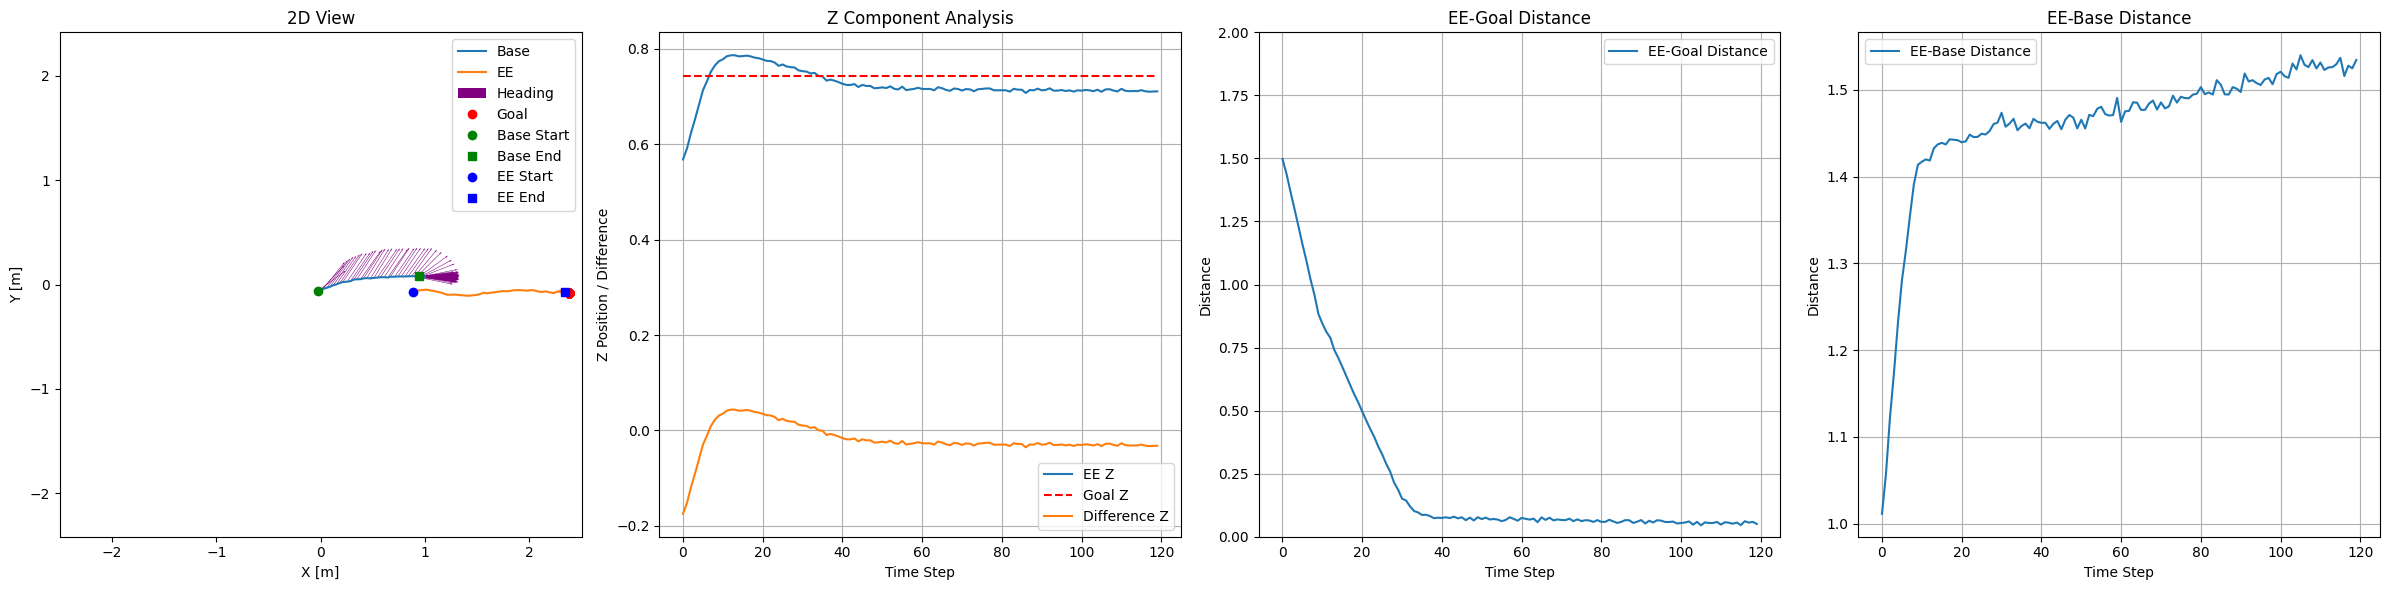

Trajectory 47


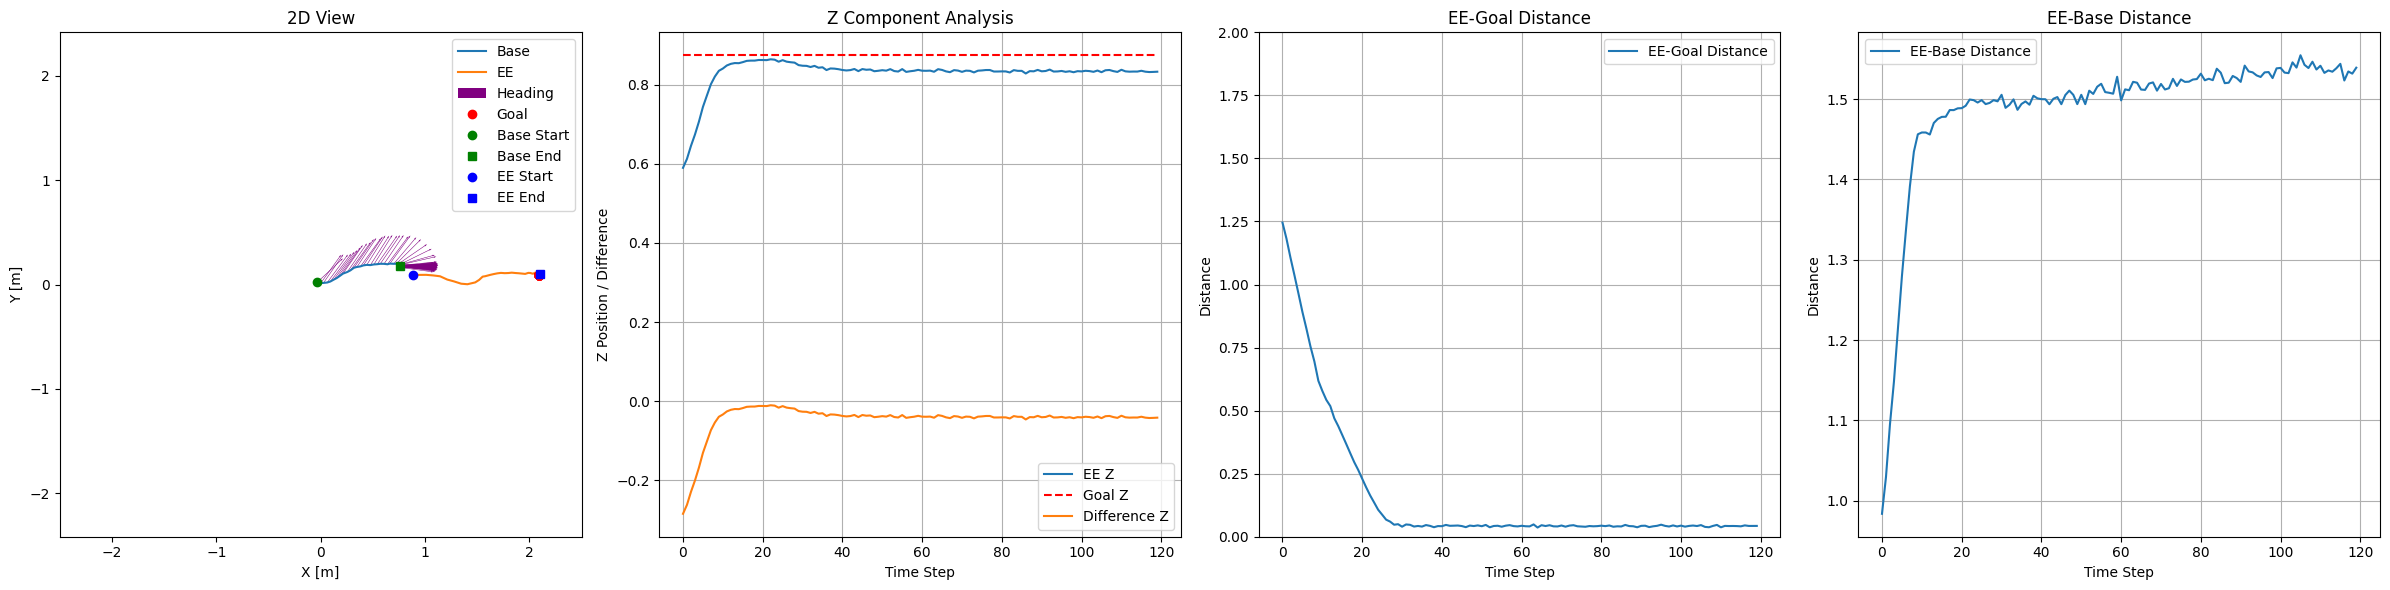

Trajectory 48


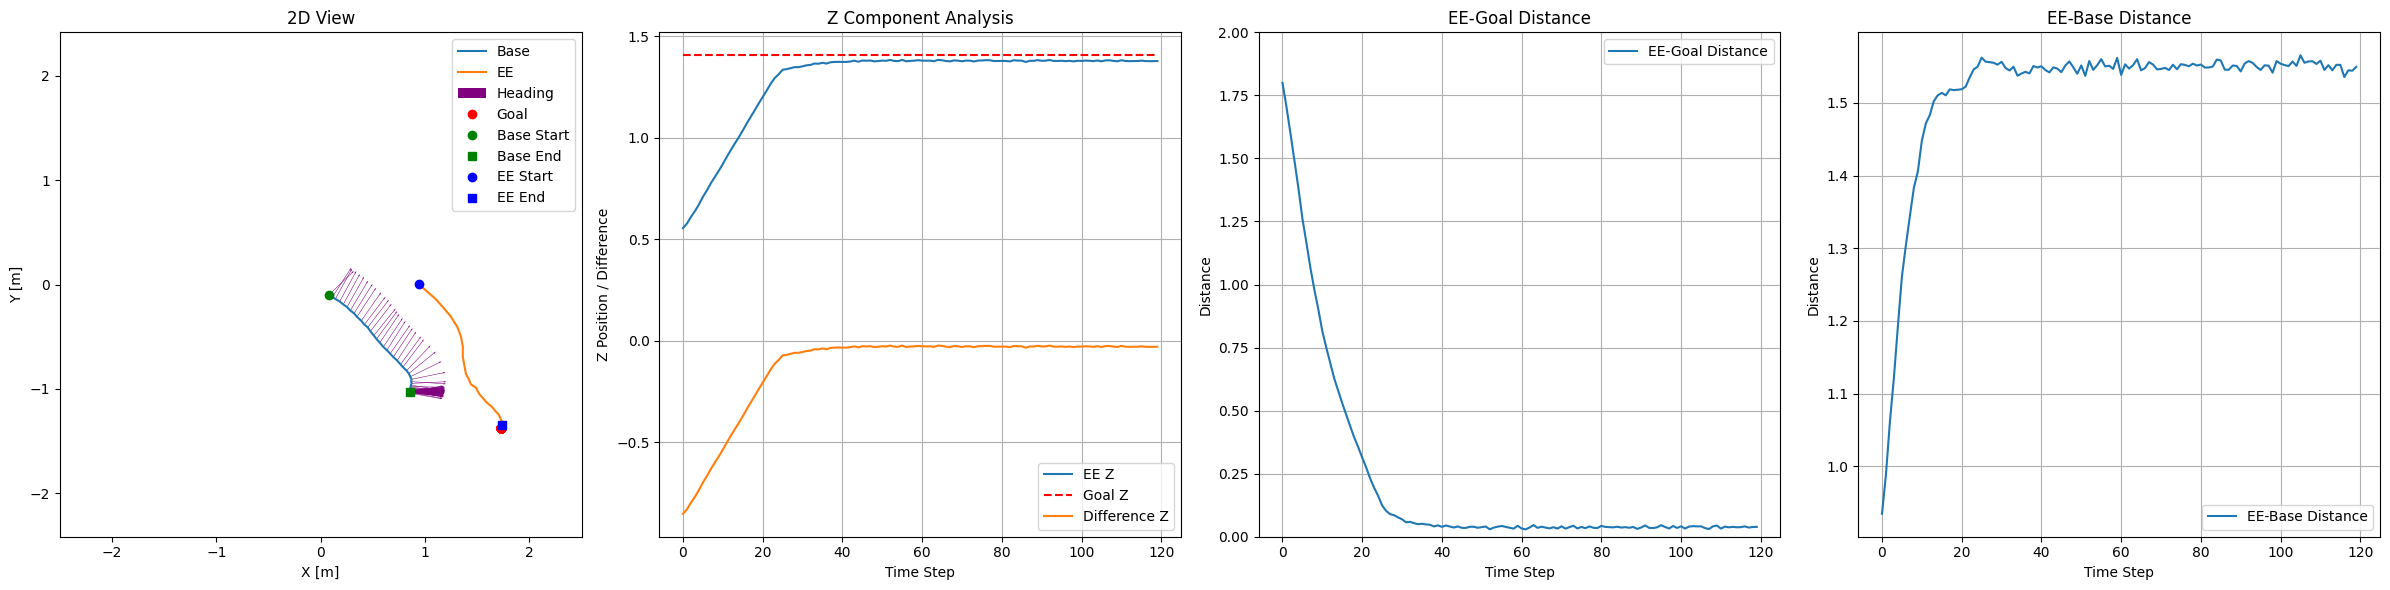

Trajectory 49


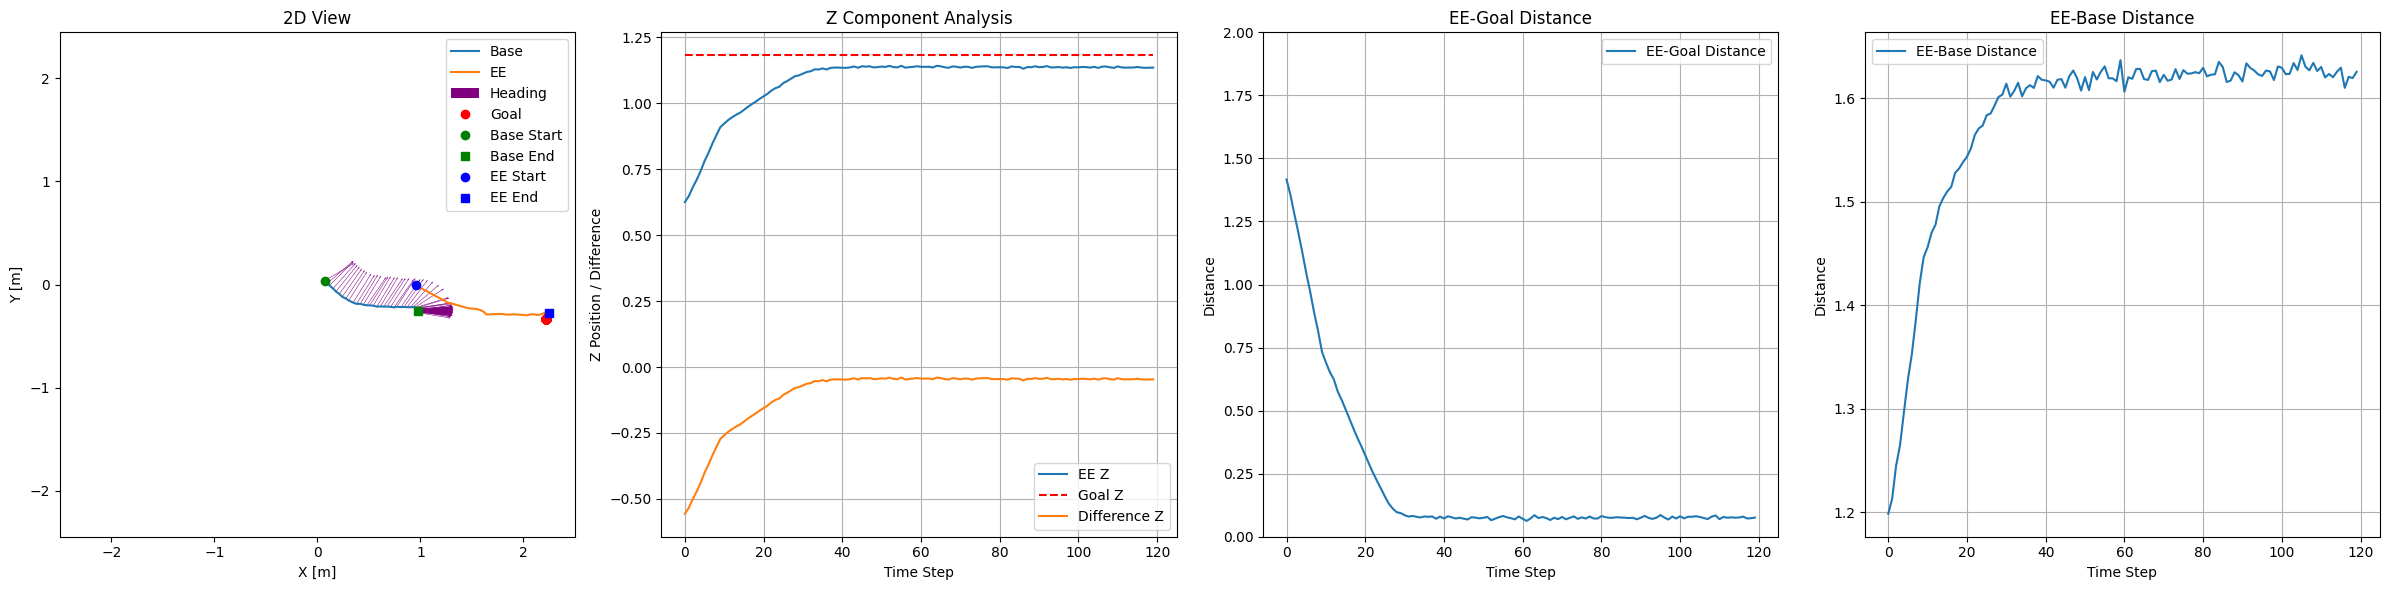

Trajectory 50


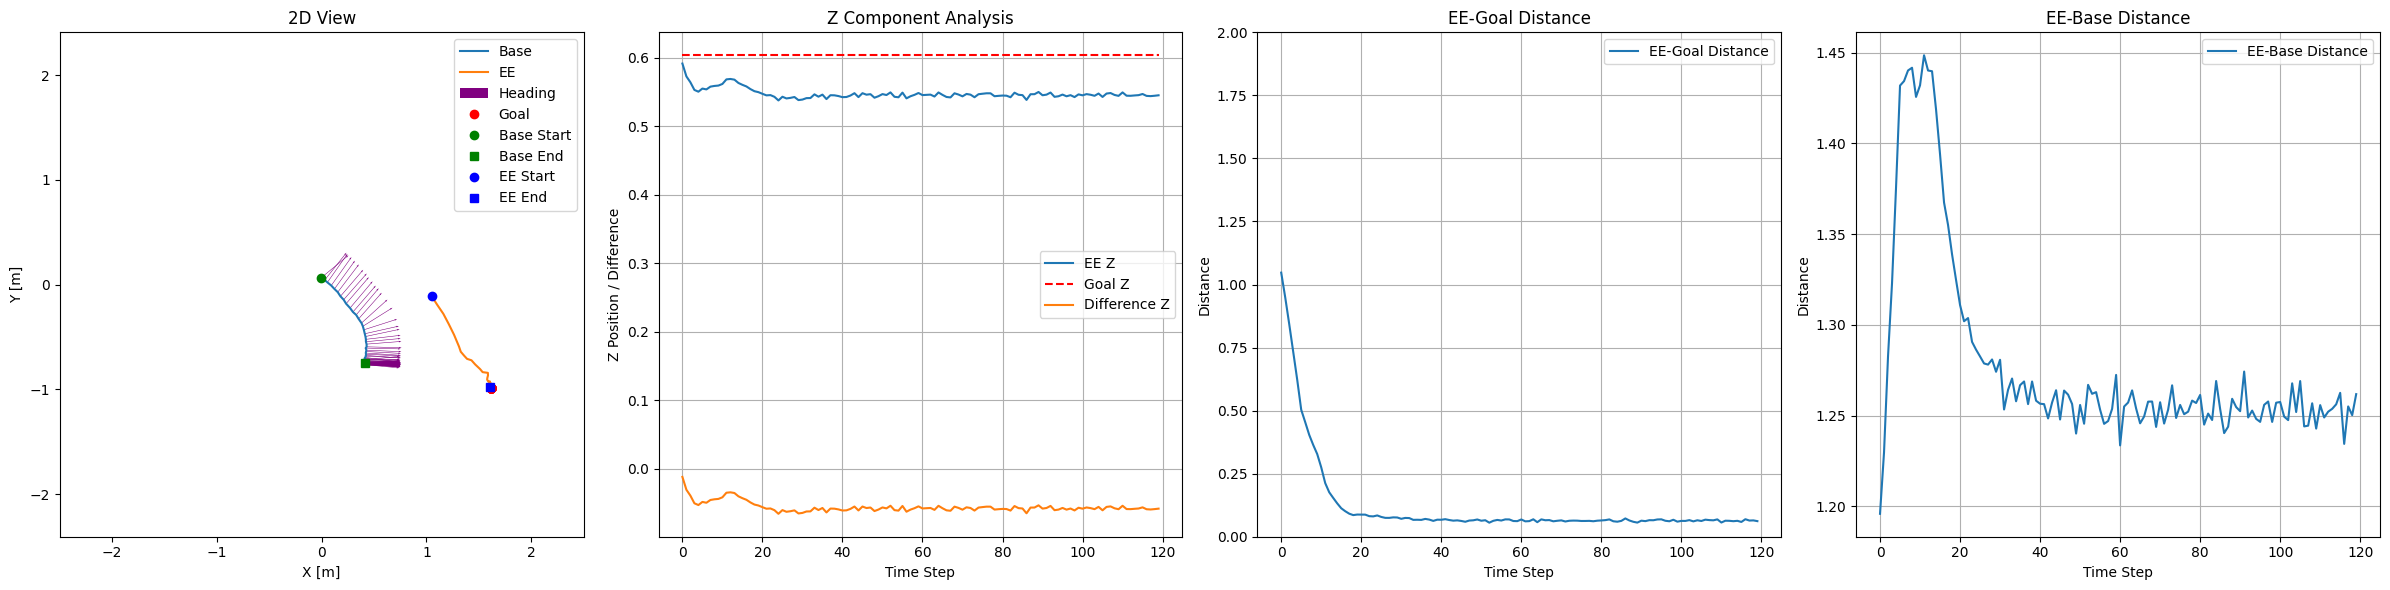

In [9]:
"""Evaluate trajectory created with policy in simulation"""

import ikpy.chain
import pickle
import numpy as np
import matplotlib.pyplot as plt
import ikpy.utils.plot as plot_utils

# load trajectory from policy simulation
file_path = "/home/bhoffman/Documents/MT_FS24/simulation_transfer/results/policies_traj/71yker3m/trajectories_all.pkl"
with open(file_path, 'rb') as file:
    data_all = pickle.load(file)

# plot trajectory evaluation
def plot_goal_and_traj(data_curr):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    ax1, ax2, ax3, ax4 = axs

    # 1. 2D View
    for idx, data in enumerate(data_curr):
        u = np.cos(data[:, 3])
        v = np.sin(data[:, 3])
        if idx == 0:
            ax1.plot(data[:, 0], data[:, 1], label="Base")
            ax1.plot(data[:, 6], data[:, 7], label="EE")
            ax1.quiver(data[:, 0], data[:, 1], u, v, angles='xy', scale_units='xy', scale=3, width=0.001, color='purple', label='Heading')
            ax1.plot(data[:, -3], data[:, -2], 'ro', label="Goal")
            ax1.plot(data[0, 0], data[0, 1], 'go', marker='o', label="Base Start")
            ax1.plot(data[-1, 0], data[-1, 1], 'gs', marker='s', label="Base End")
            ax1.plot(data[0, 6], data[0, 7], 'bo', marker='o', label="EE Start")
            ax1.plot(data[-1, 6], data[-1, 7], 'bs', marker='s', label="EE End")
        else:
            ax1.plot(data[:, 0], data[:, 1], label=f"Base" if idx == 0 else None)
            ax1.plot(data[:, 6], data[:, 7], label=f"EE" if idx == 0 else None)
            ax1.quiver(data[:, 0], data[:, 1], u, v, angles='xy', scale_units='xy', scale=3, width=0.001, color='purple')
            ax1.plot(data[:, -3], data[:, -2], 'ro')
            ax1.plot(data[0, 0], data[0, 1], 'go', marker='o')
            ax1.plot(data[-1, 0], data[-1, 1], 'gs', marker='s')
            ax1.plot(data[0, 6], data[0, 7], 'bo', marker='o')
            ax1.plot(data[-1, 6], data[-1, 7], 'bs', marker='s')
    ax1.set_title("2D View")
    ax1.legend()
    ax1.set_xlabel("X [m]")
    ax1.set_ylabel("Y [m]")
    ax1.axis('equal')
    ax1.set_xlim(-2.5, 2.5)
    ax1.set_ylim(-4.5, 4.5)

    # 2. Z Component Analysis
    for idx, data in enumerate(data_curr):
        ee_z = data[:, 8]
        goal_z = data[0, -1]
        time_steps = np.arange(data.shape[0])
        label_ee_z = f"EE Z" if idx == 0 else None
        label_goal_z = f"Goal Z" if idx == 0 else None
        label_diff_z = f"Difference Z" if idx == 0 else None
        ax2.plot(time_steps, ee_z, label=label_ee_z)
        ax2.hlines(goal_z, time_steps[0], time_steps[-1], colors='r', linestyles='--', label=label_goal_z)
        diff_z = ee_z - goal_z
        ax2.plot(time_steps, diff_z, label=label_diff_z)
    ax2.set_title("Z Component Analysis")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Z Position / Difference")
    ax2.legend()
    ax2.grid(True)

    # 3. EE-Goal Distance
    for idx, data in enumerate(data_curr):
        ee_pos = data[:, 6:9]
        goal_pos = data[:, -3:]
        distance = np.linalg.norm(ee_pos - goal_pos, axis=1)
        time_steps = np.arange(data.shape[0])
        label_distance = f"EE-Goal Distance" if idx == 0 else None
        ax3.plot(time_steps, distance, label=label_distance)
    ax3.set_title("EE-Goal Distance")
    ax3.set_xlabel("Time Step")
    ax3.set_ylabel("Distance")
    ax3.set_ylim(0, 2)
    ax3.legend()
    ax3.grid(True)

    # 4. EE-Base Distance
    for idx, data in enumerate(data_curr):
        ee_pos = data[:, 6:9]
        base_pos = data[:, 0:3]
        distance = np.linalg.norm(ee_pos - base_pos, axis=1)
        time_steps = np.arange(data.shape[0])
        label_distance = f"EE-Base Distance" if idx == 0 else None
        ax4.plot(time_steps, distance, label=label_distance)
    ax4.set_title("EE-Base Distance")
    ax4.set_xlabel("Time Step")
    ax4.set_ylabel("Distance")
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

# goal_switch_steps = 10
# amount_of_plots = len(data_all) // goal_switch_steps
# for i in range(amount_of_plots):
#     plot_goal_and_traj(data_all[i*goal_switch_steps:(i+1)*goal_switch_steps])

for id, data in enumerate(data_all):
    print(f"Trajectory {id+1}")
    plot_goal_and_traj(data_all[id:id+1])

# plot_goal_and_traj(data_all)

In [ ]:
"""Test data conversion for visualizer"""

# load data from json file
import json
file_path = "/home/bhoffman/Documents/MT FS24/spot_visualizer/data/collected data/dataset_vis_policy_test_policy_new.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# get joint angles
angles = []

for d in data:
    angles.append(d["jointStates"])

# plot joint angles
n_joints = len(angles[0])
joints = np.array([[joint["jointPos"] for joint in state] for state in angles])

fig, axs = plt.subplots(n_joints, 1, figsize=(30, 60))

for i in range(n_joints):
    # between -pi and pi
    joints_converted = np.array([angle if angle < np.pi else angle - 2*np.pi for angle in joints[:, i]])
    axs[i].plot(joints_converted, label="joint " + str(i))
    axs[i].set_title("joint " + str(i))
    axs[i].legend()